In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from glob import glob
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, balanced_accuracy_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import ttest_rel
from scipy.stats import t

# Adiciona o diretório pai ao path, caso necessário
sys.path.append(os.path.abspath("../"))

# Importa os módulos do src
import src.BCE_Logistic_regression
import src.BCE_Logistic_Sigmoid
import src.Weighted_BCE_Logistic_regression
import src.Weighted_BCE_Logistic_regression_New_Sigmoid
import src.Focal_Loss_Logistic_Regression
import src.Focal_Loss_DynamicAlpha_Logistic_Regression

# Recarrega os módulos para refletir alterações
importlib.reload(src.BCE_Logistic_regression)
importlib.reload(src.BCE_Logistic_Sigmoid)
importlib.reload(src.Weighted_BCE_Logistic_regression)
importlib.reload(src.Weighted_BCE_Logistic_regression_New_Sigmoid)
importlib.reload(src.Focal_Loss_Logistic_Regression)
importlib.reload(src.Focal_Loss_DynamicAlpha_Logistic_Regression)

# Importa as classes após reload
from src.BCE_Logistic_regression import LogisticRegression as BCE_Logistic
from src.BCE_Logistic_Sigmoid import BCE_Logistic_Sigmoid
from src.Weighted_BCE_Logistic_regression import LogisticRegression as Weighted_Logistic
from src.Weighted_BCE_Logistic_regression_New_Sigmoid import LogisticRegression as WeightedNewSigmoid_Logistic
from src.Focal_Loss_Logistic_Regression import LogisticRegression as Focal_Logistic
from src.Focal_Loss_DynamicAlpha_Logistic_Regression import LogisticRegression as Focal_Loss_DynamicAlpha_Logistic


In [81]:
# Caminho para os datasets
data_dir = "../data/class_imbalance/"
csv_files = glob(os.path.join(data_dir, "*.csv"))

In [82]:
# Observando que há label de target diferentes mas padronizado. 
for file in csv_files:
    try:
        df = pd.read_csv(file)
        target_col = df.columns[-1]
        unique_vals = df[target_col].dropna().unique()

        print(f"\n📄 Arquivo: {os.path.basename(file)}")
        print(f"🎯 Coluna alvo: {target_col}")
        print(f"🔍 Valores únicos: {unique_vals}")
    except Exception as e:
        print(f"⚠️ Erro ao processar {file}: {e}")


📄 Arquivo: dataset_1000_hypothyroid.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1002_ipums_la_98-small.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1004_synthetic_control.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_1013_analcatdata_challenger.csv
🎯 Coluna alvo: Damaged
🔍 Valores únicos: [0 1]

📄 Arquivo: dataset_1014_analcatdata_dmft.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['N' 'P']

📄 Arquivo: dataset_1016_vowel.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1018_ipums_la_99-small.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1020_mfeat-karhunen.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1021_page-blocks.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: dataset_1022_mfeat-pixel.csv
🎯 Coluna alvo: binaryClass
🔍 Valores únicos: ['P' 'N']

📄 Arquivo: datas

In [83]:
# Função robusta para processar um dataframe
def preprocessamento_robusto(df):
    df = df.copy()

    # Substituição segura
    df.replace({"t": 1, "f": 0, "M": 1, "F": 0}, inplace=True)

    # Substituição de "?" por NaN
    df.replace("?", np.nan, inplace=True)

    # Conversão de colunas categóricas
    for col in df.select_dtypes(include=["object", "bool"]).columns:
        df[col] = df[col].replace("nan", np.nan)  # corrige strings "nan"
        df[col] = df[col].fillna("missing")
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Conversão de colunas numéricas
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        df[col] = df[col].fillna(df[col].mean())

    # Remoção de colunas completamente nulas (já vem do seu código)
    df.dropna(axis=1, how='all', inplace=True)

    # Remoção final de linhas com NaNs restantes
    df.dropna(inplace=True)

    return df

# Função para binarizar variável alvo
def binarizar_target(y):
    uniques = pd.Series(y).dropna().unique()
    if len(uniques) != 2:
        raise ValueError(f"Target não é binária: {uniques}")

    if set(uniques) == {0, 1}:
        return pd.Series(y)
    elif set(uniques) == {True, False}:
        return pd.Series(y).astype(int)
    elif set(uniques) == {-1, 1}:
        return (pd.Series(y) == 1).astype(int)
    else:
        mapping = {val: i for i, val in enumerate(sorted(uniques))}
        return pd.Series(y).map(mapping)



📁 Processando: dataset_1000_hypothyroid.csv
Convergência alcançada em 967 iterações.
Convergência alcançada em 895 iterações.


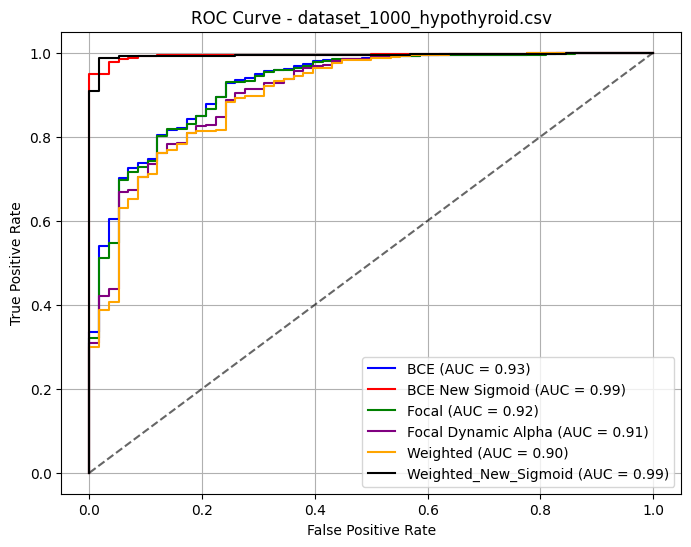

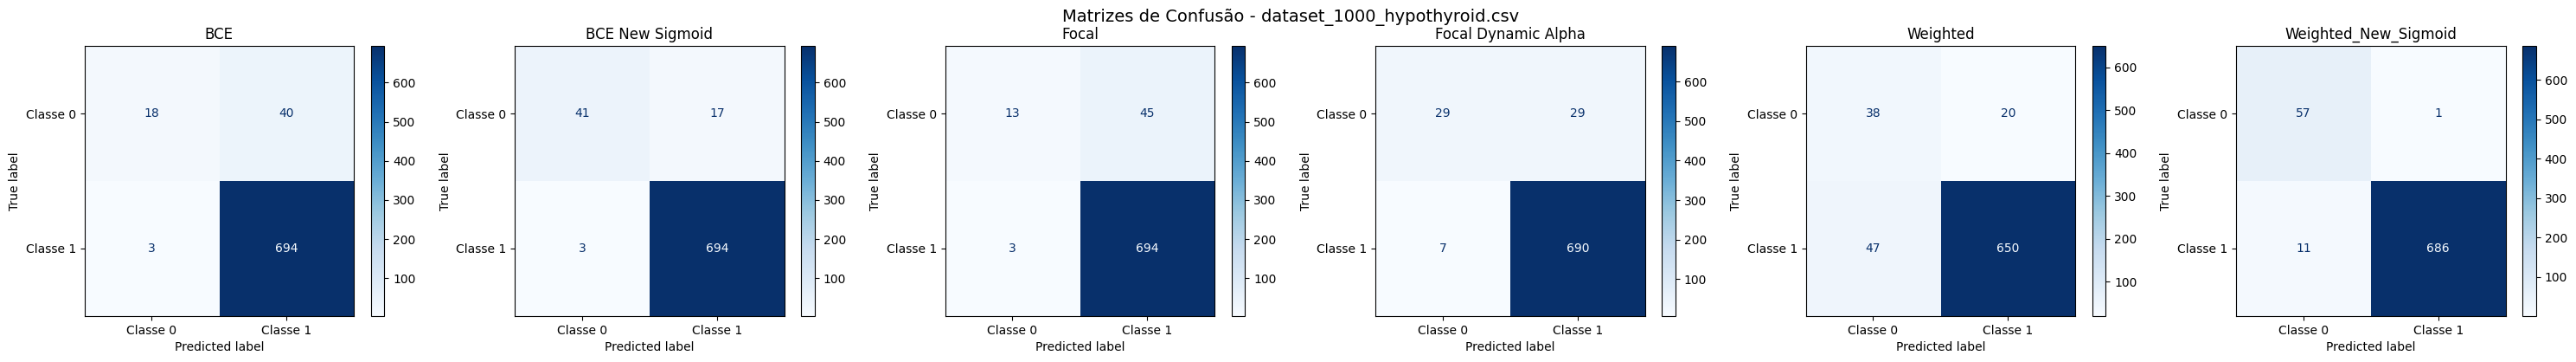


📁 Processando: dataset_1002_ipums_la_98-small.csv
Convergência alcançada em 970 iterações.


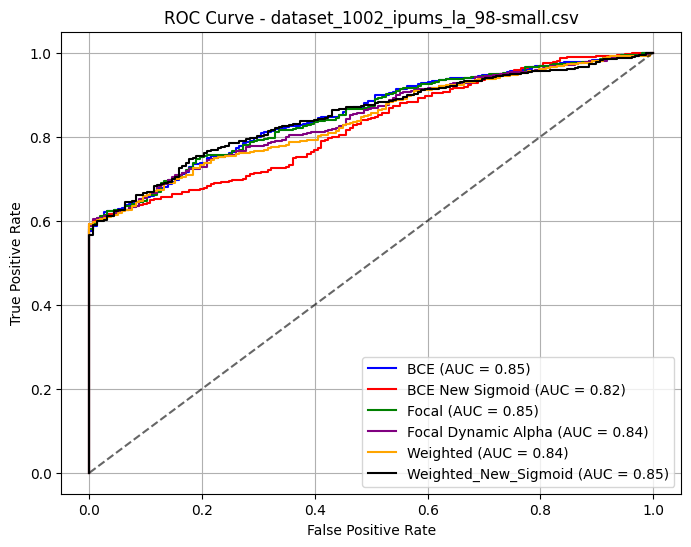

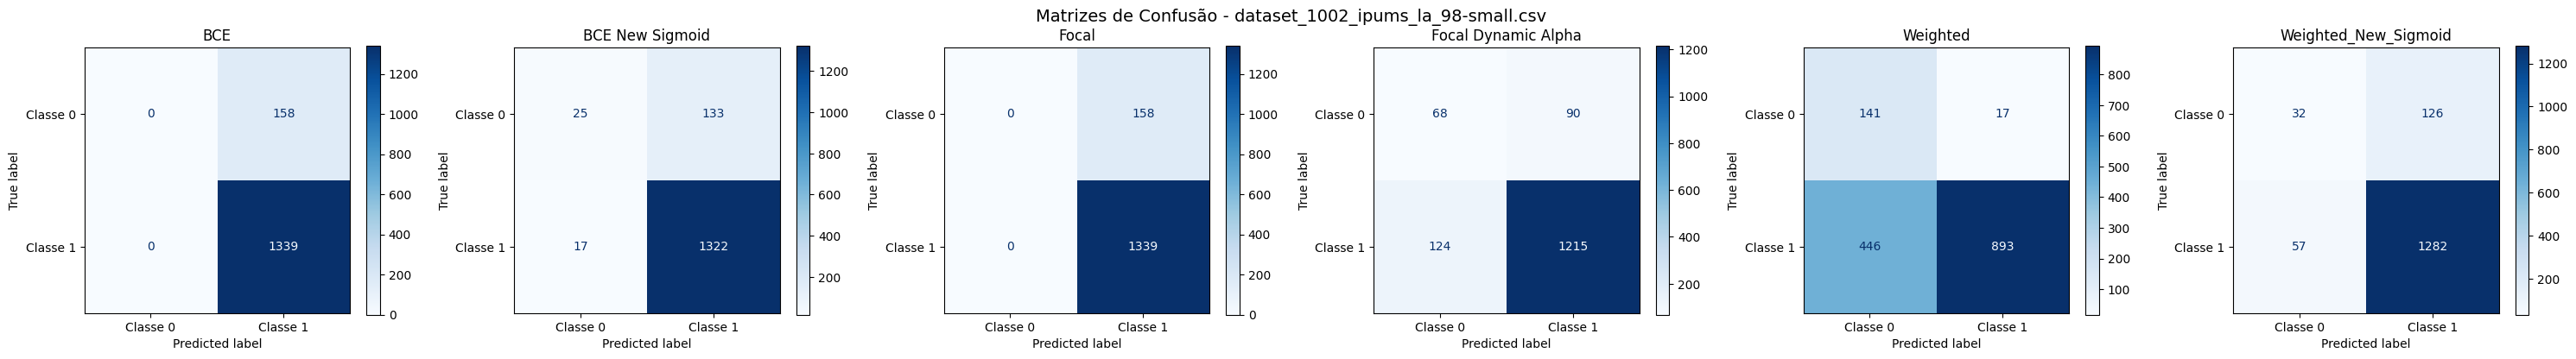


📁 Processando: dataset_1004_synthetic_control.csv


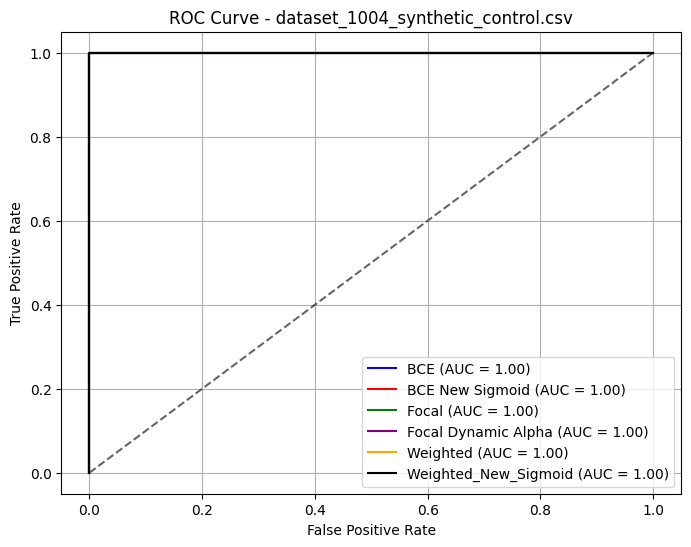

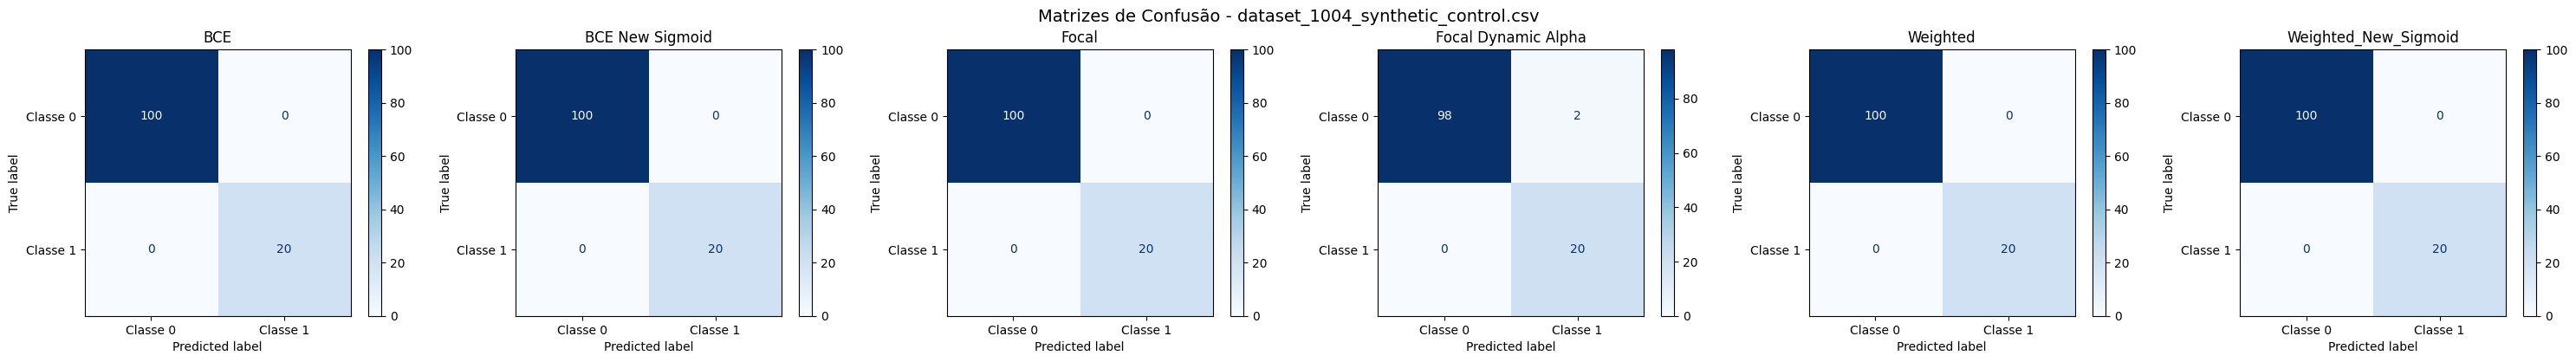


📁 Processando: dataset_1013_analcatdata_challenger.csv
Convergência alcançada em 24 iterações.
Convergência alcançada em 813 iterações.
Convergência alcançada em 441 iterações.
Convergência alcançada em 908 iterações.
Convergência alcançada em 7 iterações.


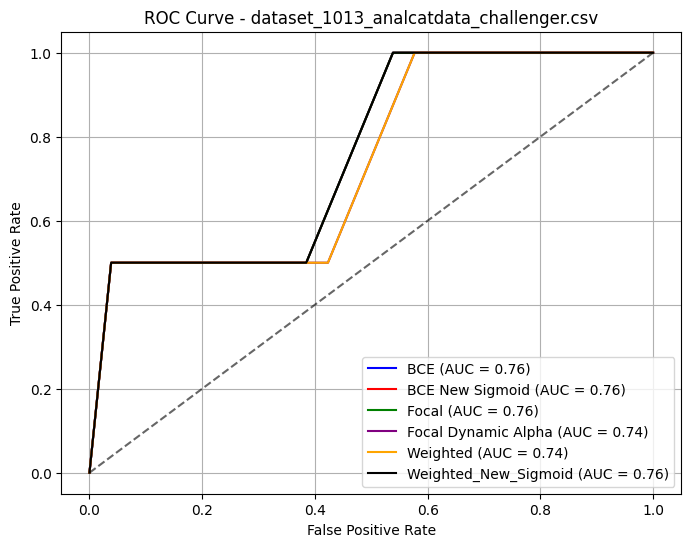

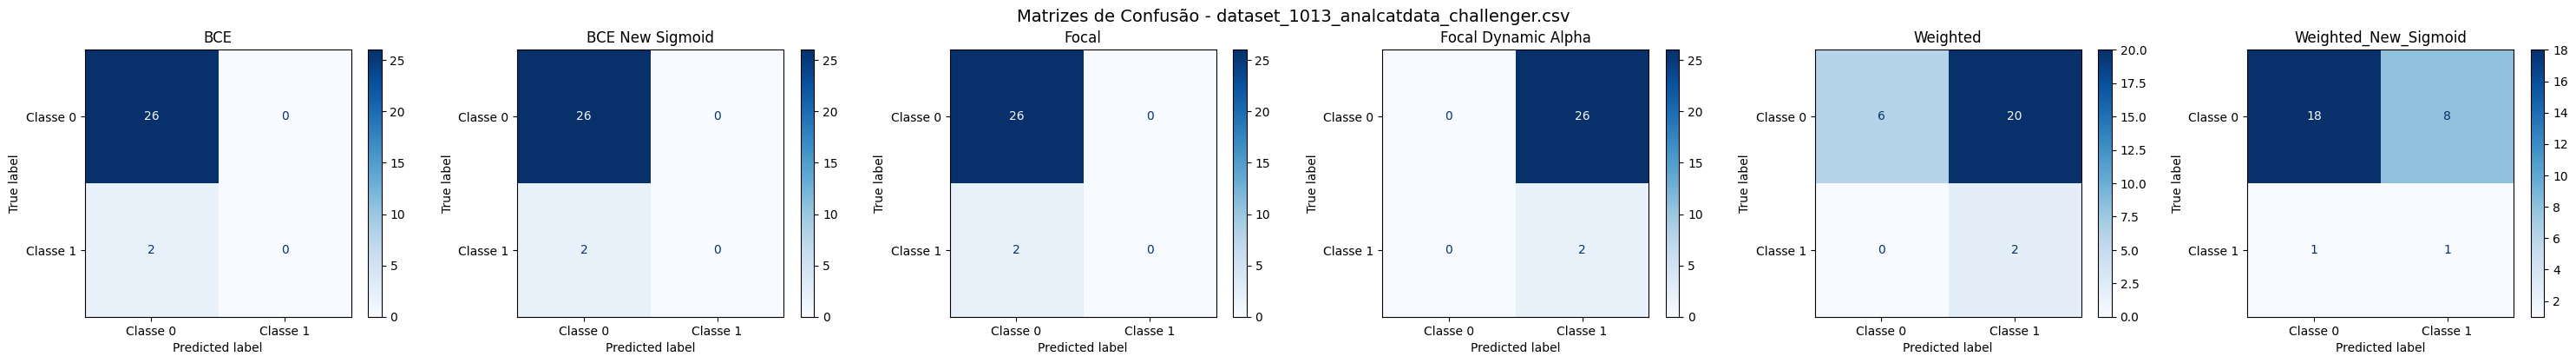


📁 Processando: dataset_1014_analcatdata_dmft.csv
Convergência alcançada em 532 iterações.
Convergência alcançada em 10 iterações.
Convergência alcançada em 400 iterações.
Convergência alcançada em 189 iterações.
Convergência alcançada em 453 iterações.


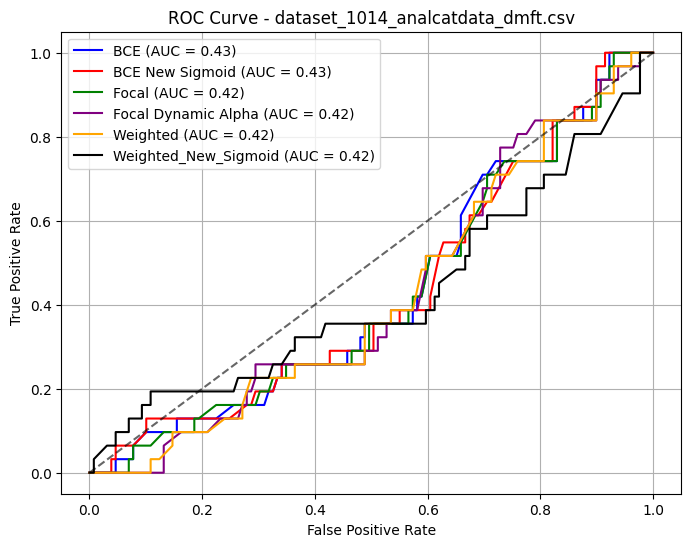

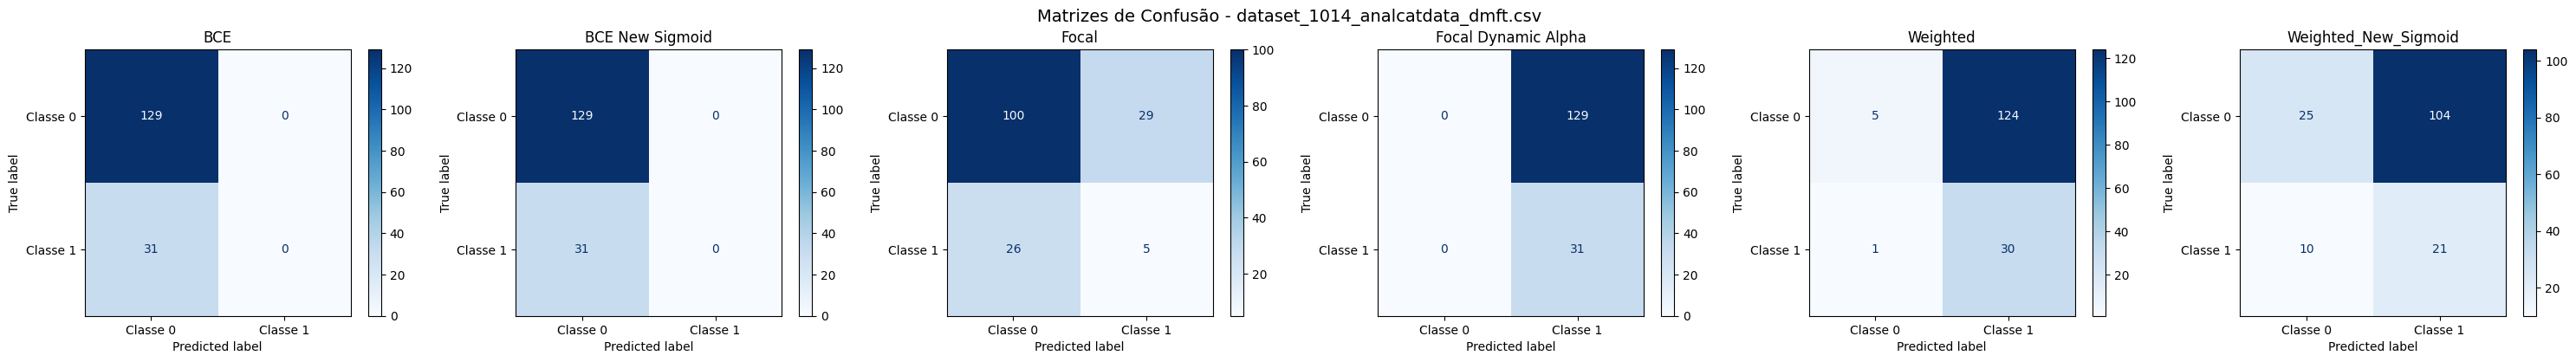


📁 Processando: dataset_1016_vowel.csv
Convergência alcançada em 812 iterações.
Convergência alcançada em 572 iterações.


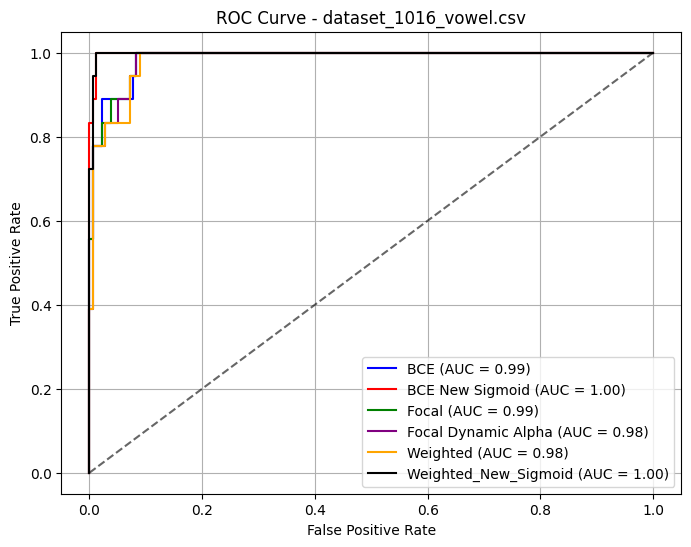

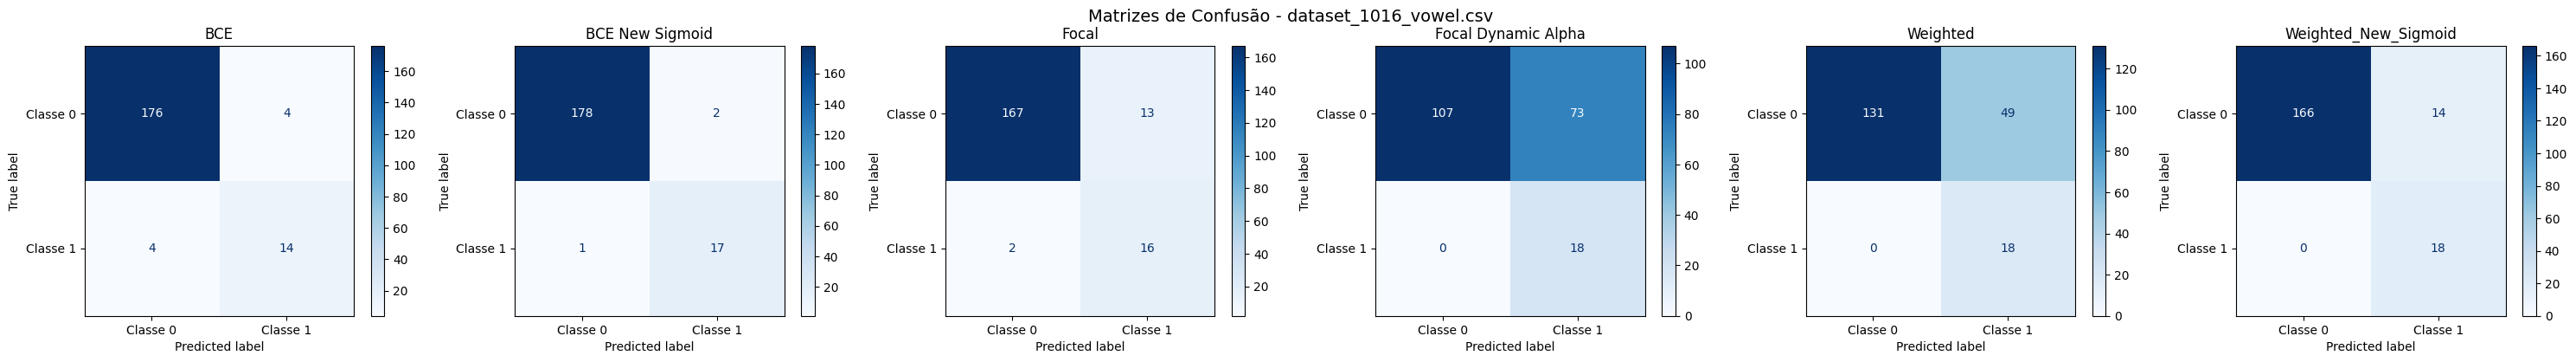


📁 Processando: dataset_1018_ipums_la_99-small.csv
Convergência alcançada em 941 iterações.


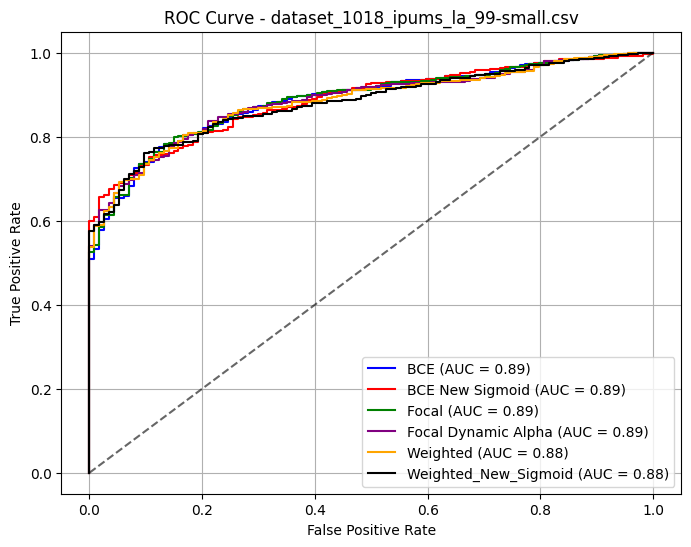

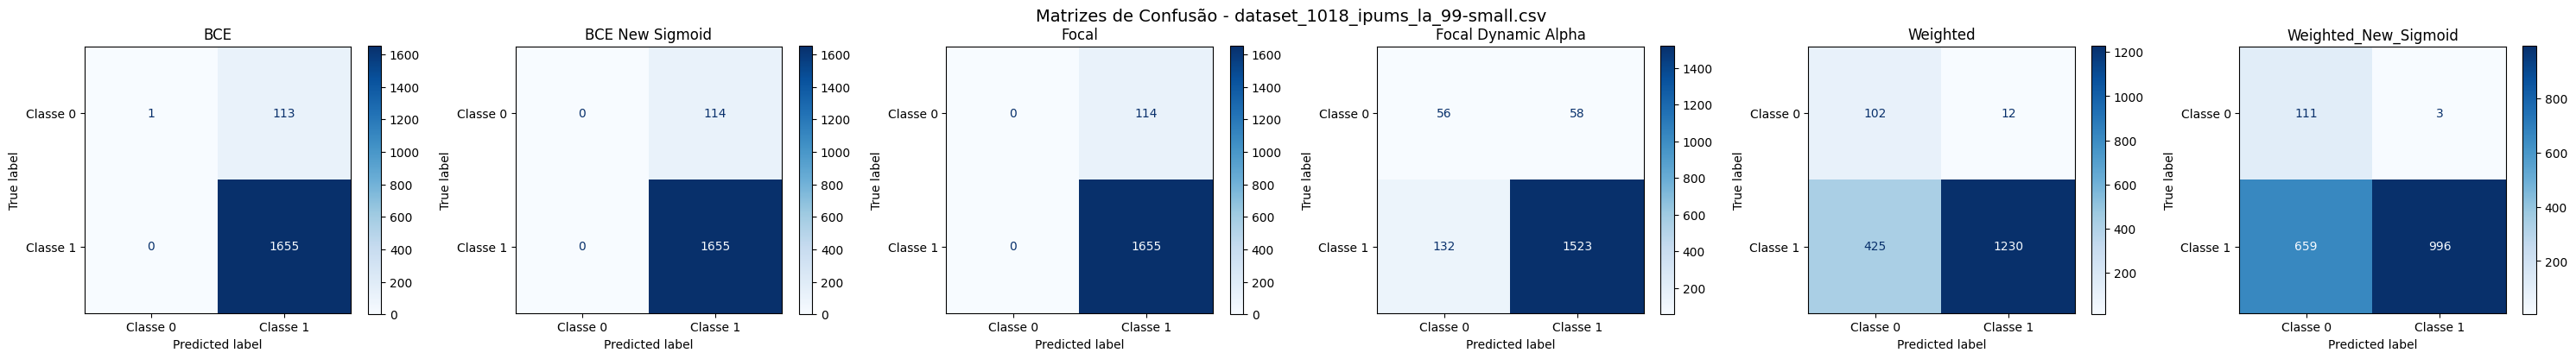


📁 Processando: dataset_1020_mfeat-karhunen.csv


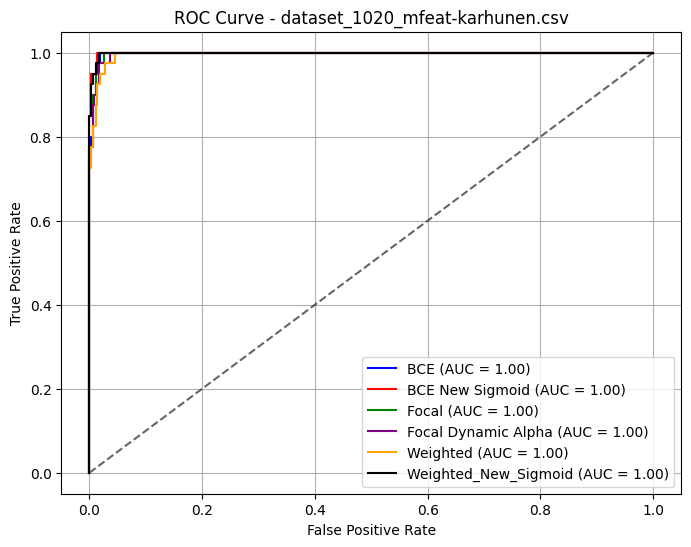

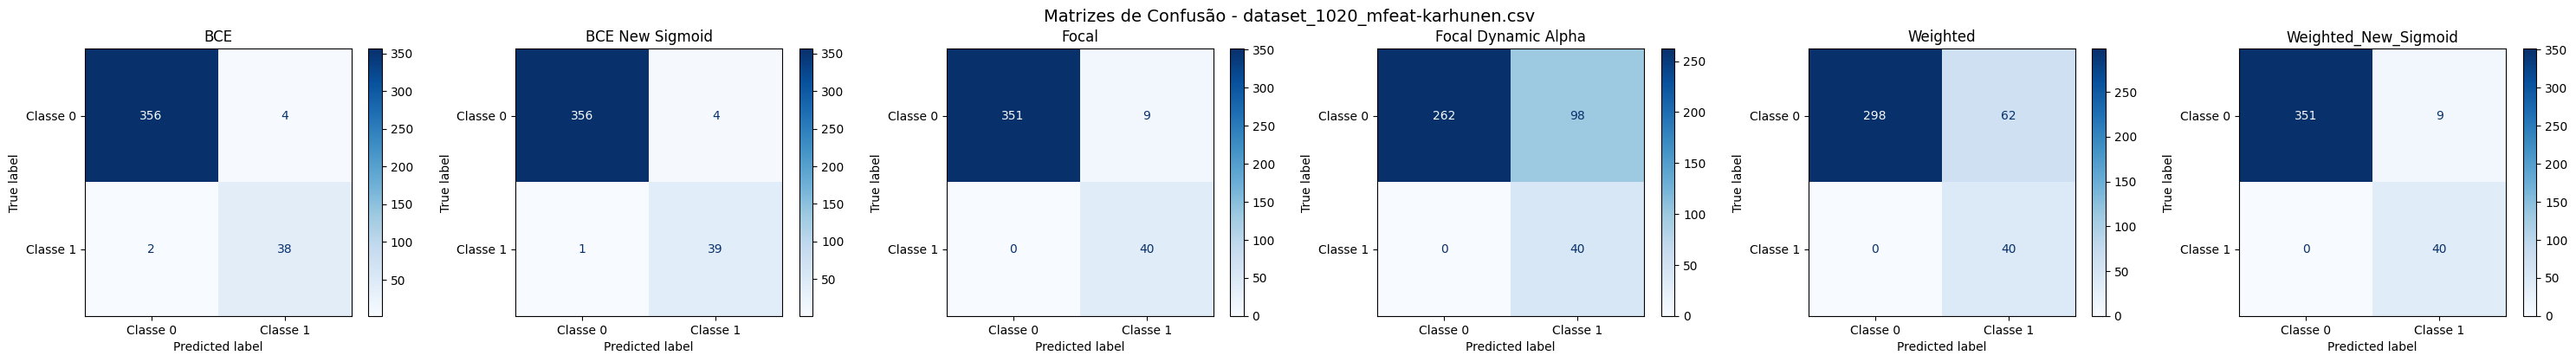


📁 Processando: dataset_1021_page-blocks.csv
Convergência alcançada em 272 iterações.
Convergência alcançada em 983 iterações.
Convergência alcançada em 366 iterações.


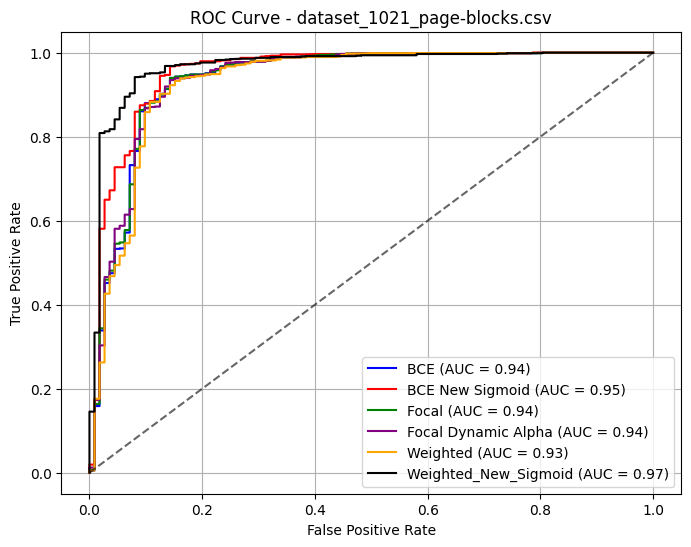

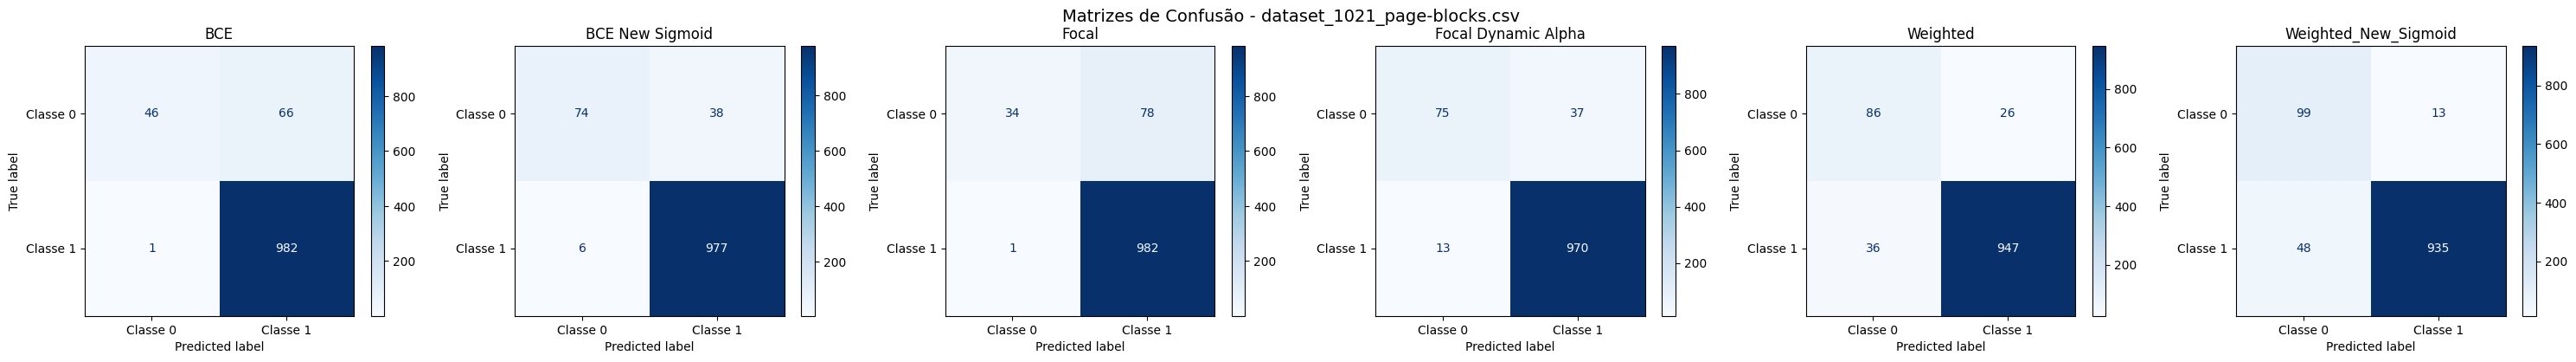


📁 Processando: dataset_1022_mfeat-pixel.csv
Convergência alcançada em 374 iterações.
Convergência alcançada em 402 iterações.


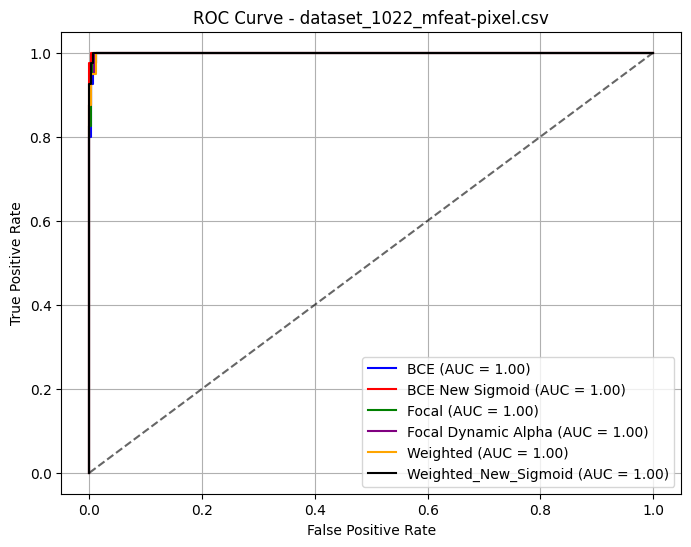

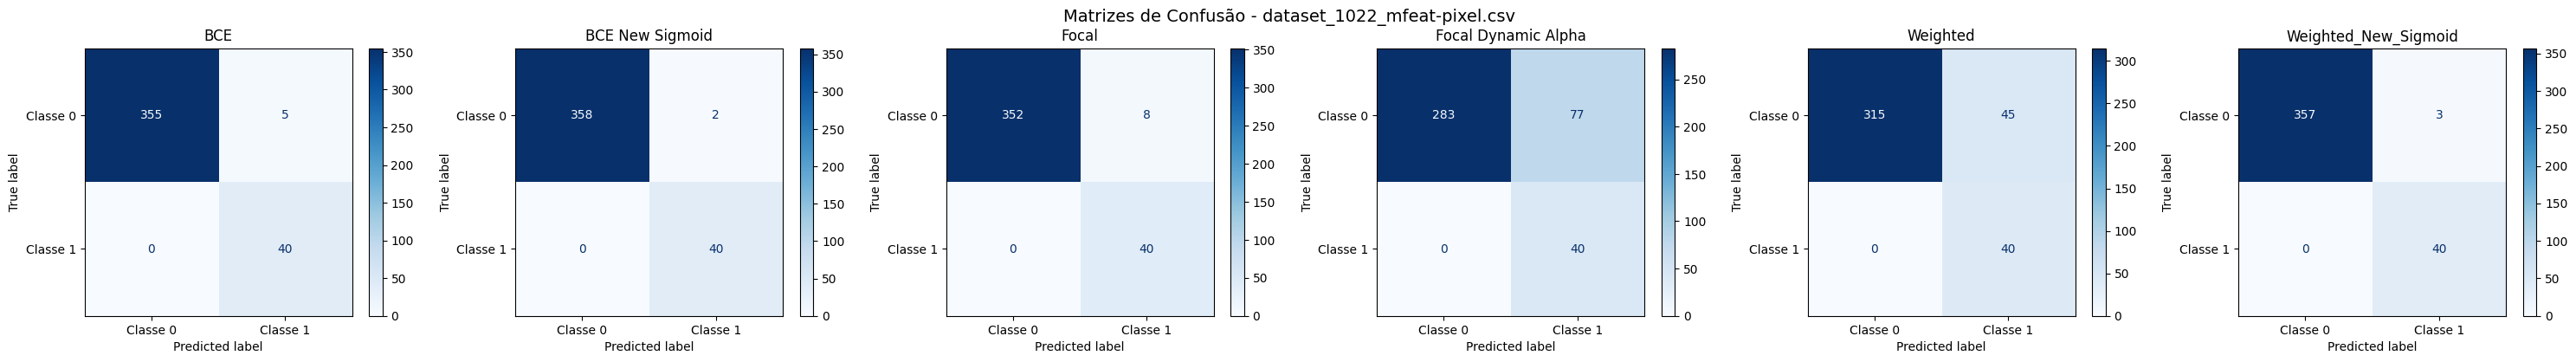


📁 Processando: dataset_1023_soybean.csv


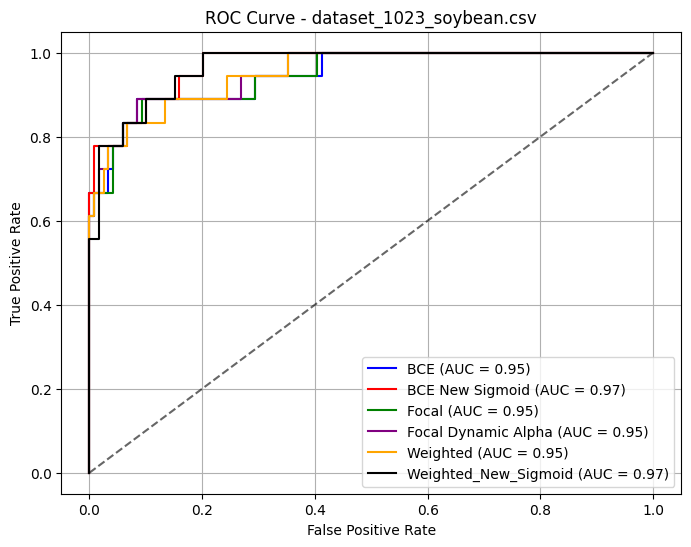

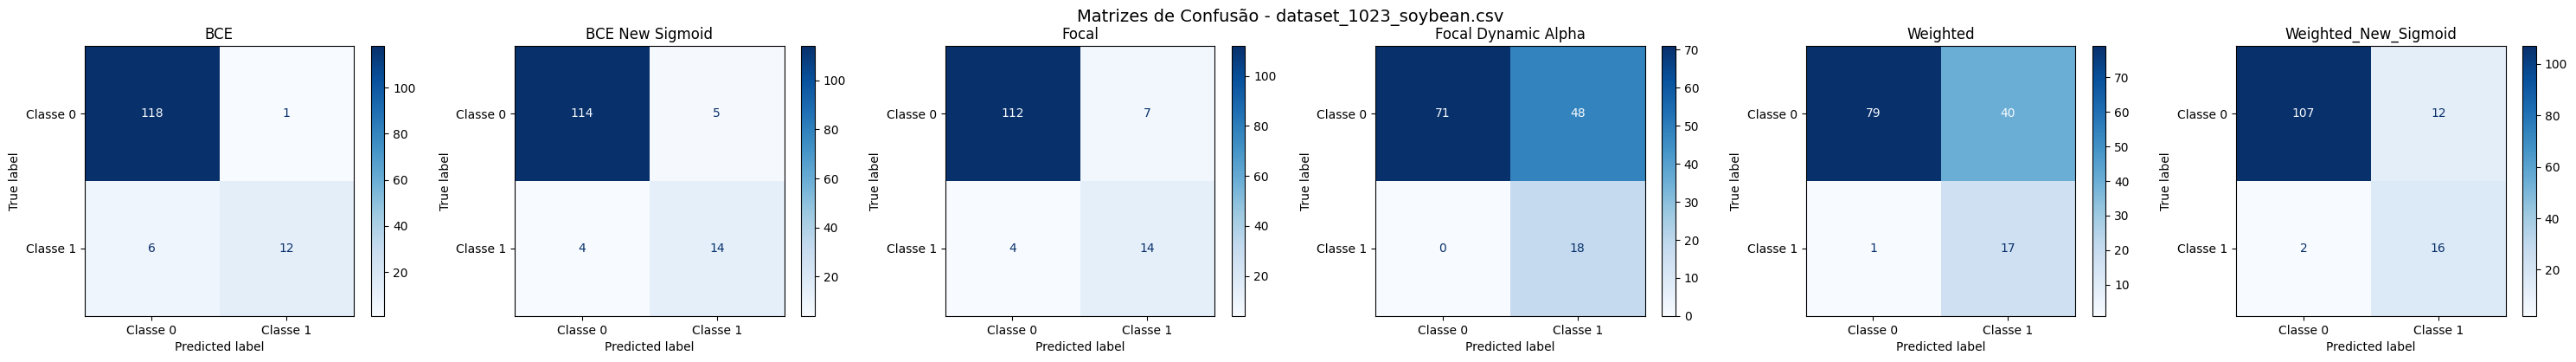


📁 Processando: dataset_1039_hiva_agnostic.csv


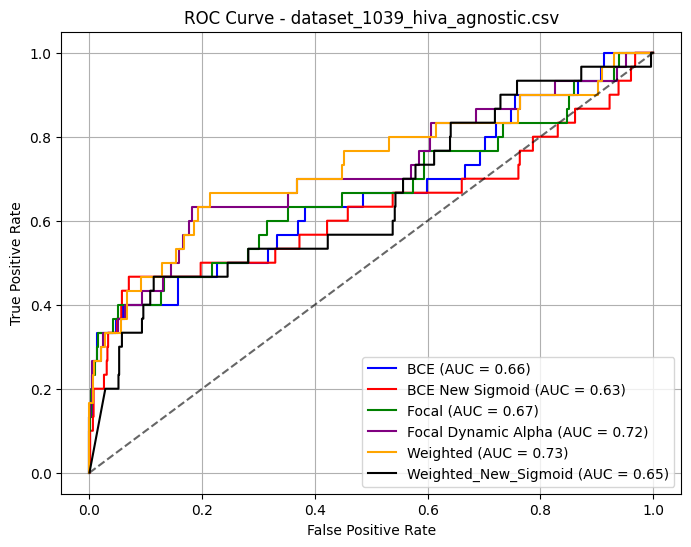

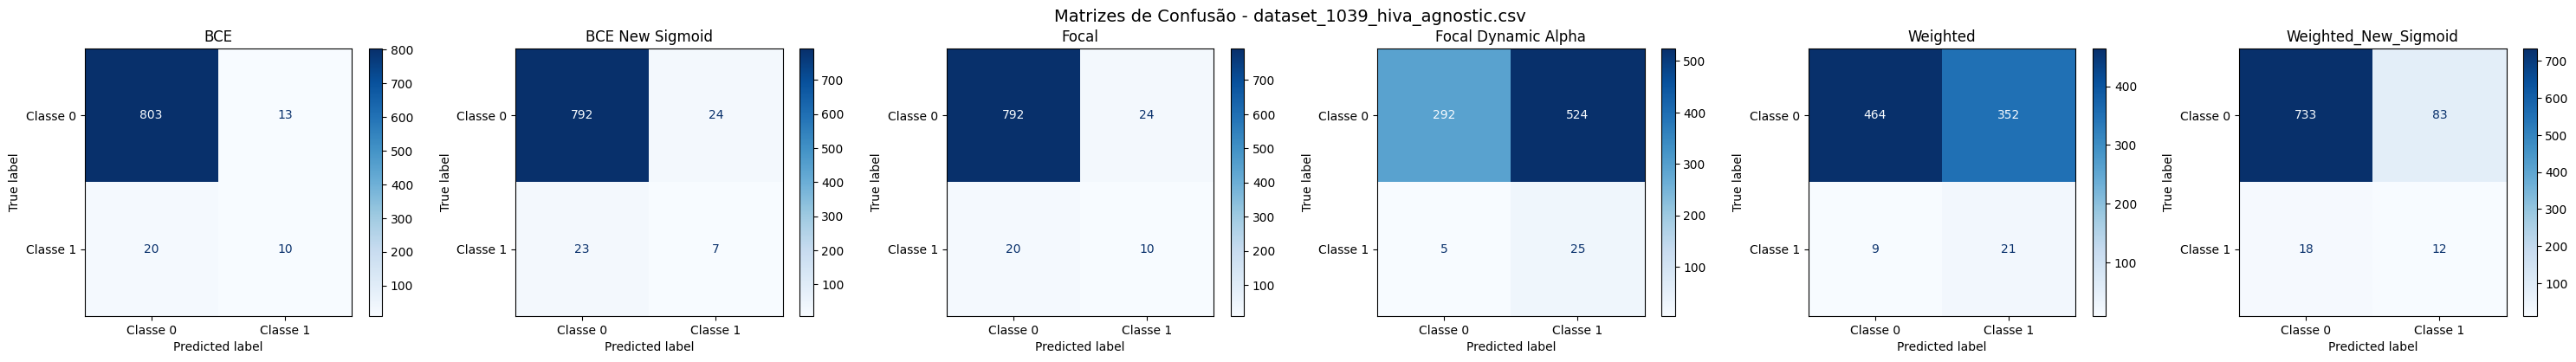


📁 Processando: dataset_1045_kc1-top5.csv
Convergência alcançada em 523 iterações.


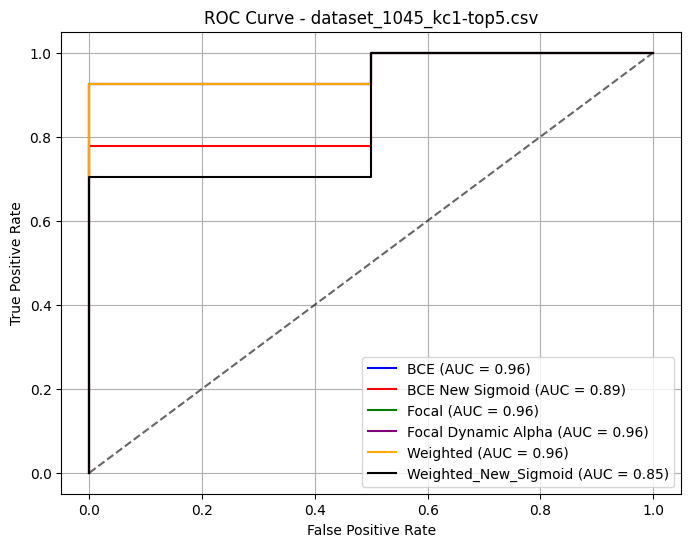

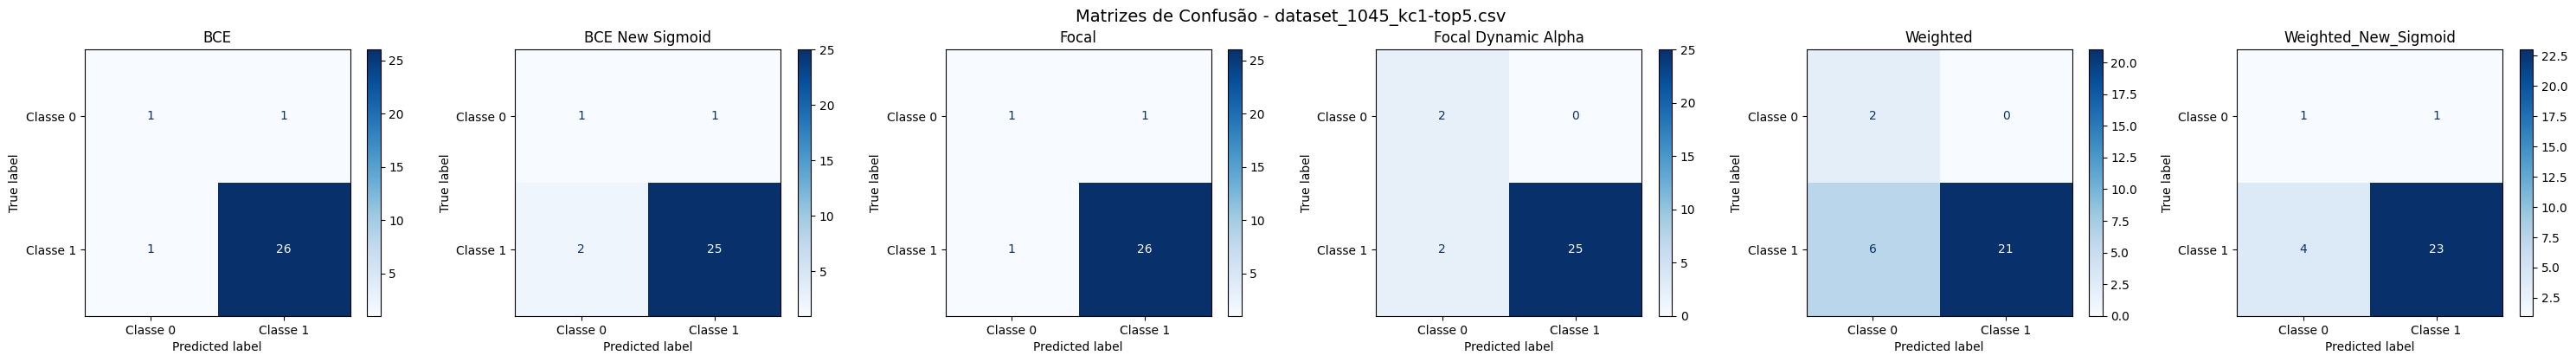


📁 Processando: dataset_1049_pc4.csv


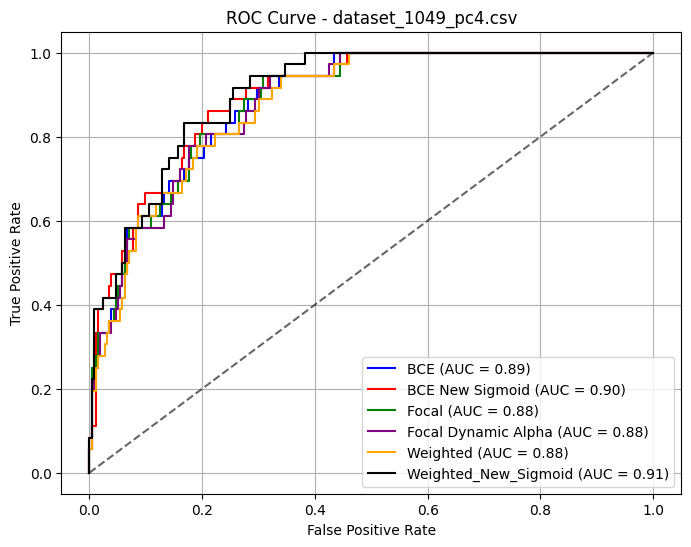

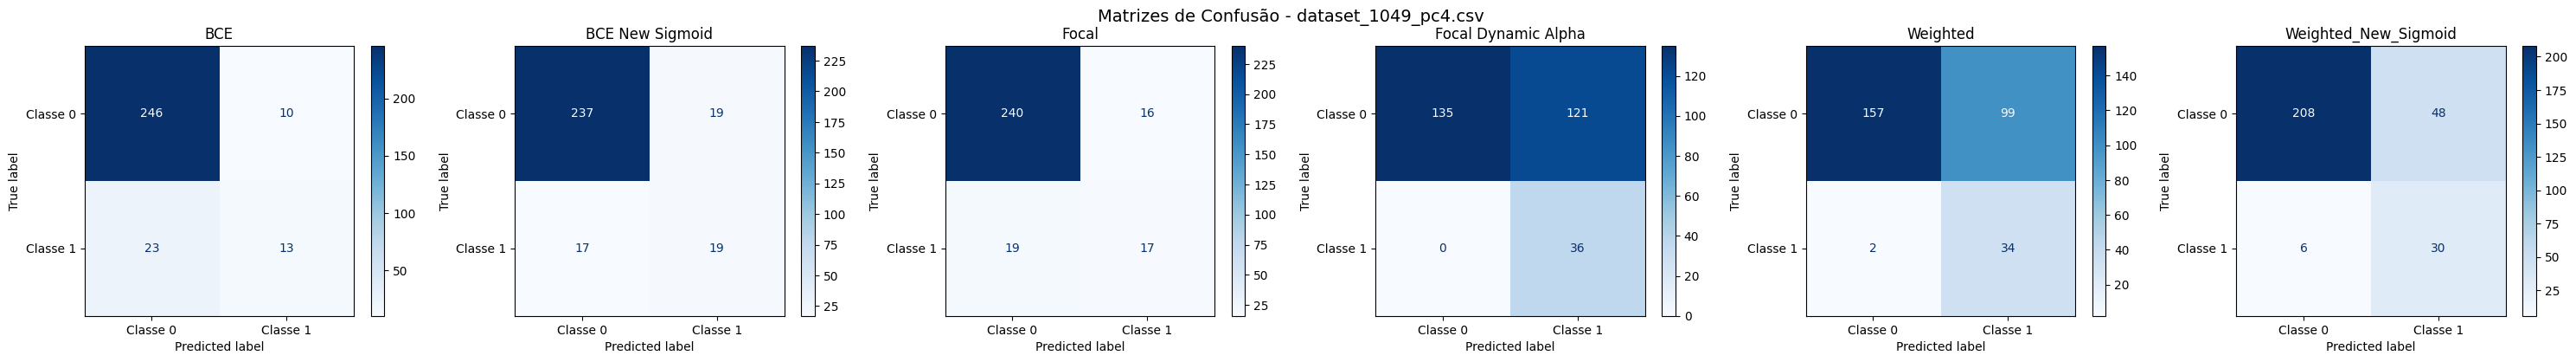


📁 Processando: dataset_1050_pc3.csv
Convergência alcançada em 817 iterações.
Convergência alcançada em 559 iterações.


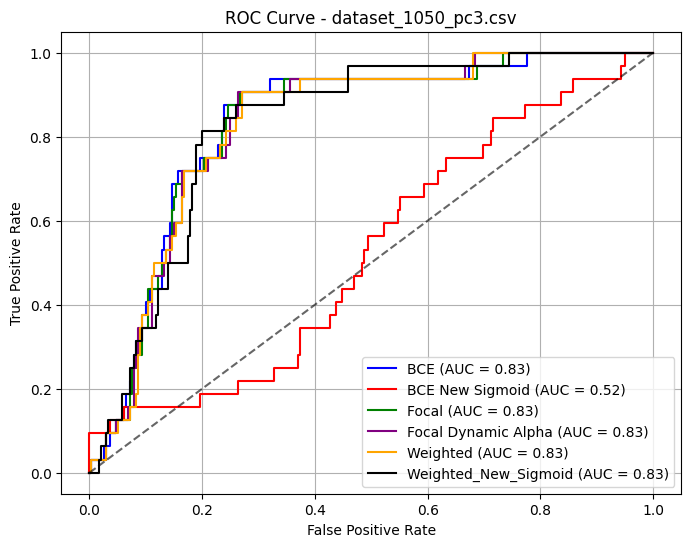

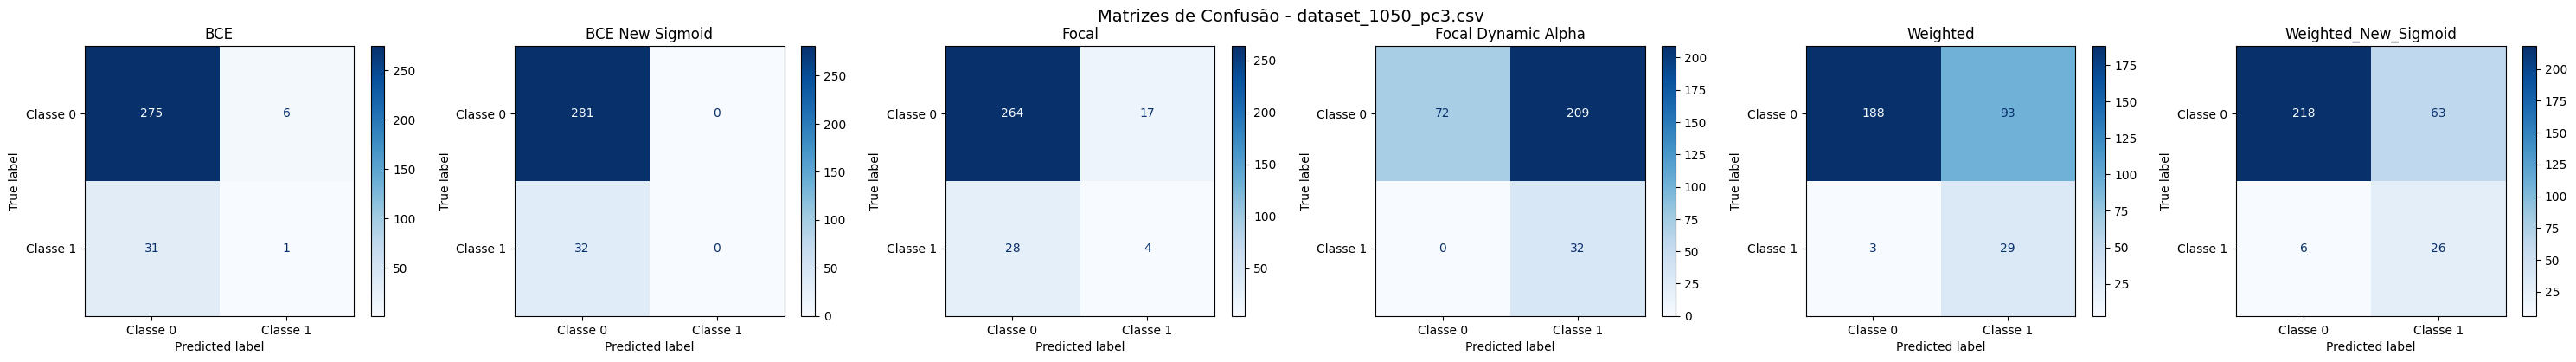


📁 Processando: dataset_1056_mc1.csv
Convergência alcançada em 148 iterações.
Convergência alcançada em 386 iterações.


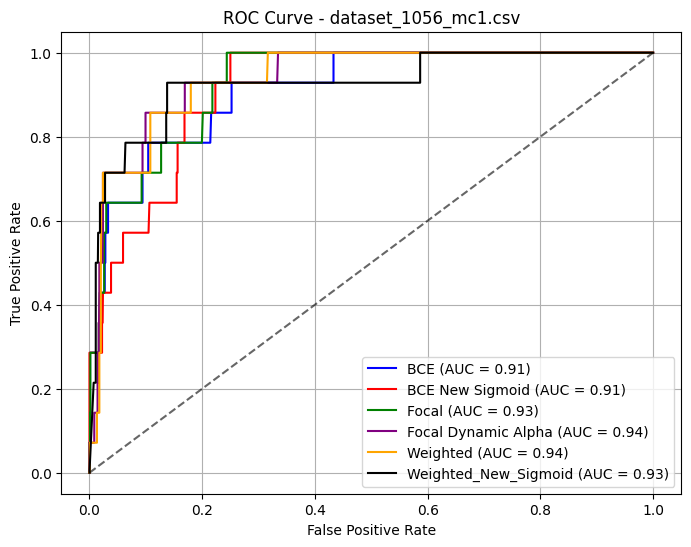

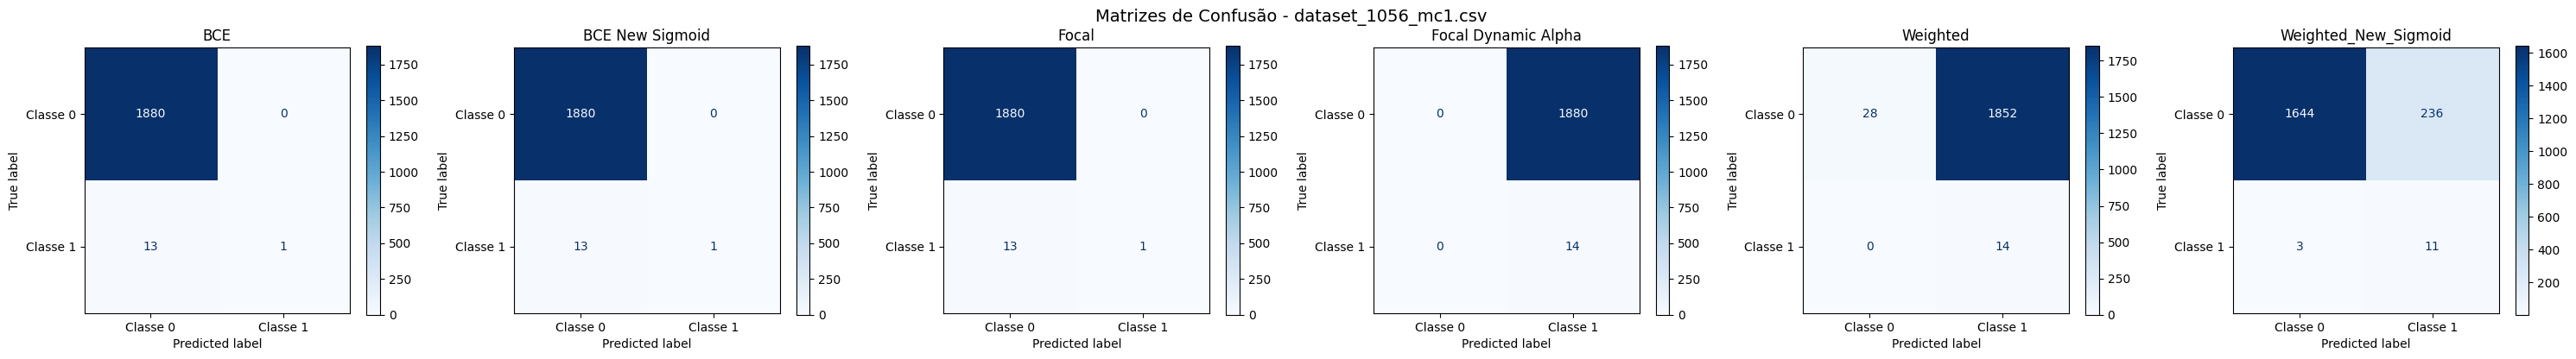


📁 Processando: dataset_1059_ar1.csv


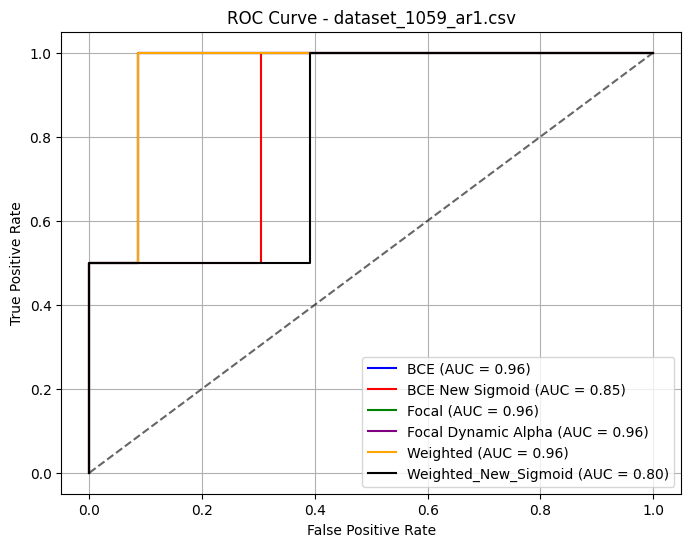

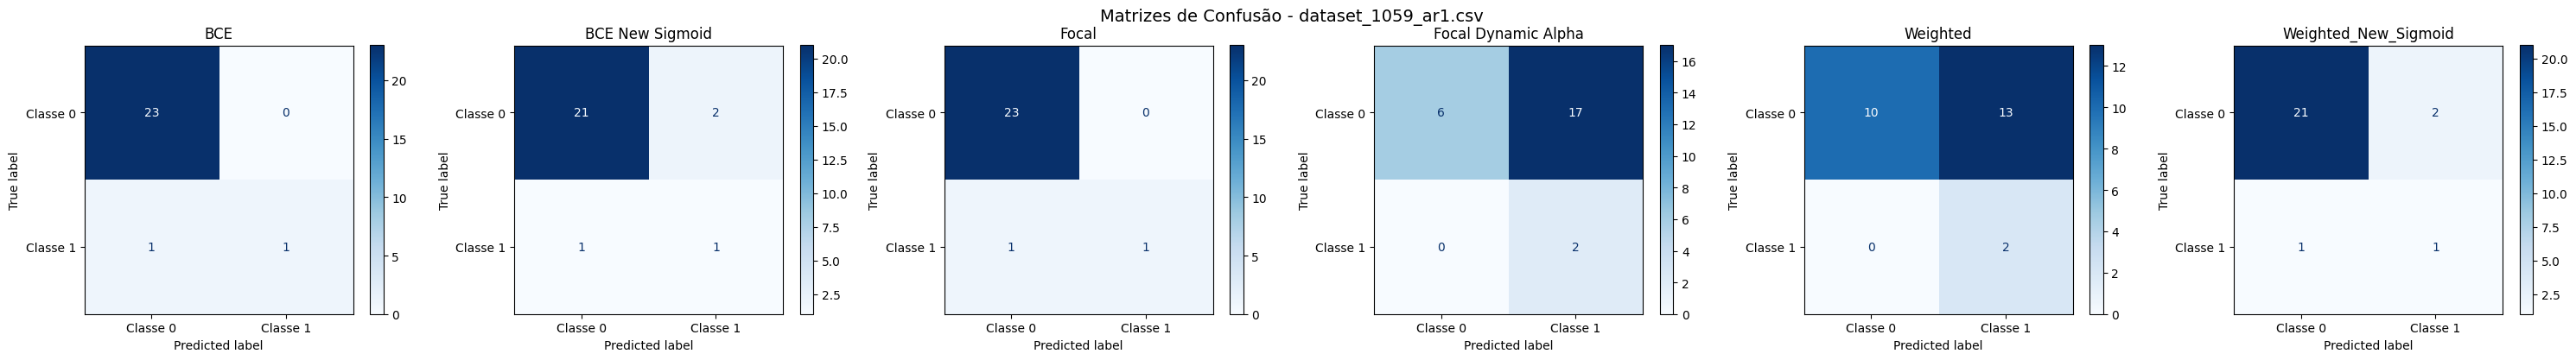


📁 Processando: dataset_1061_ar4.csv


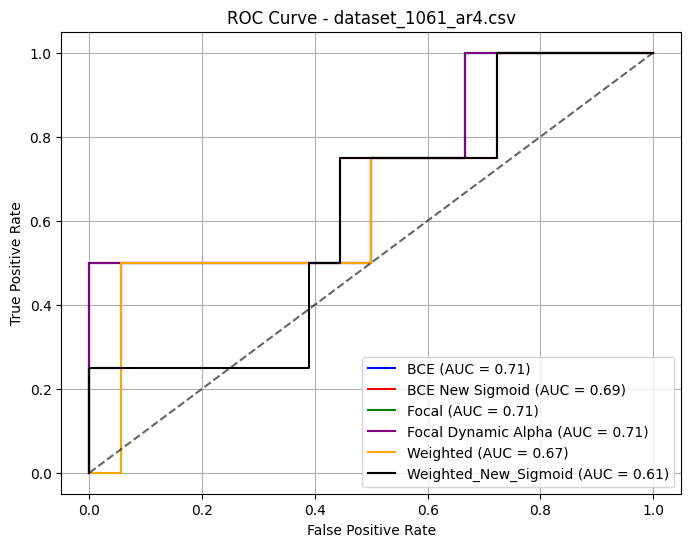

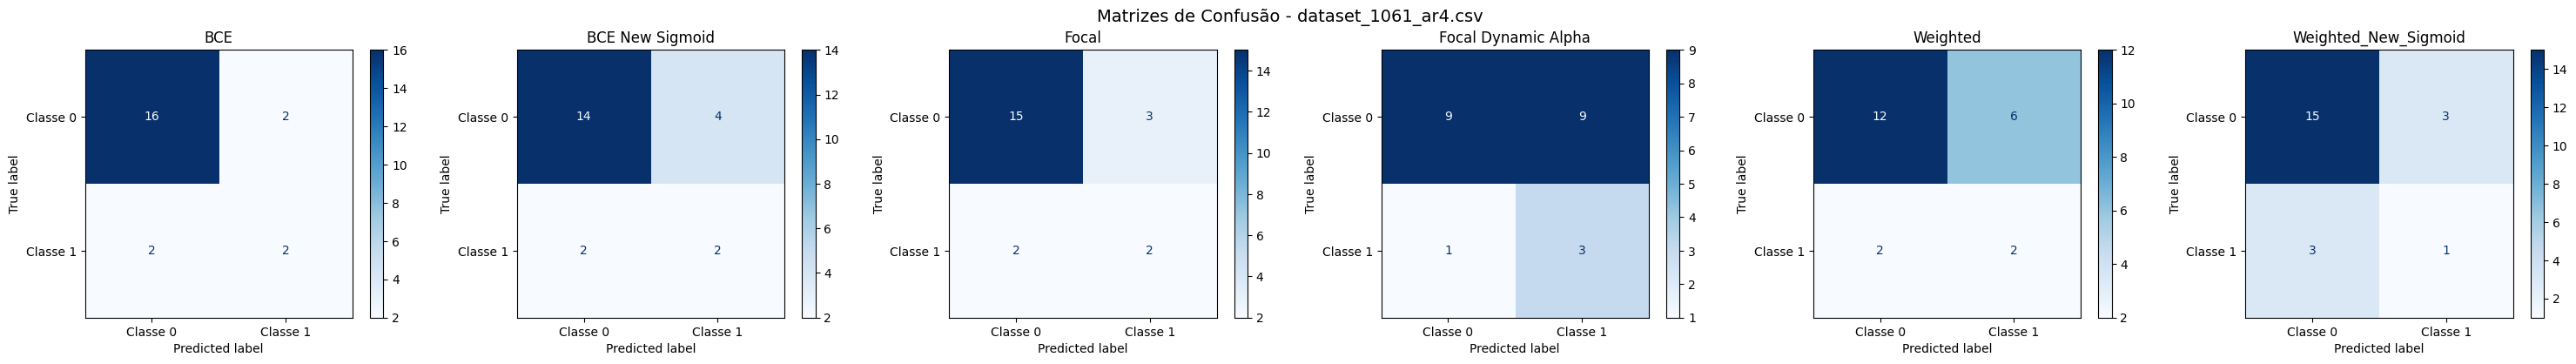


📁 Processando: dataset_1064_ar6.csv
Convergência alcançada em 926 iterações.


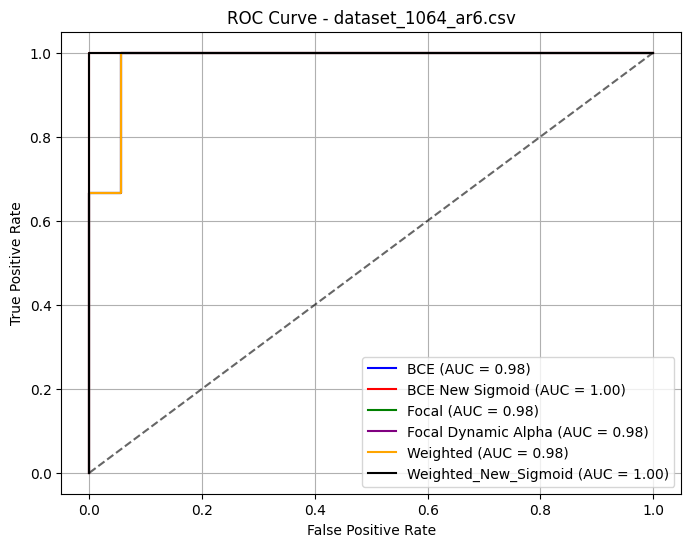

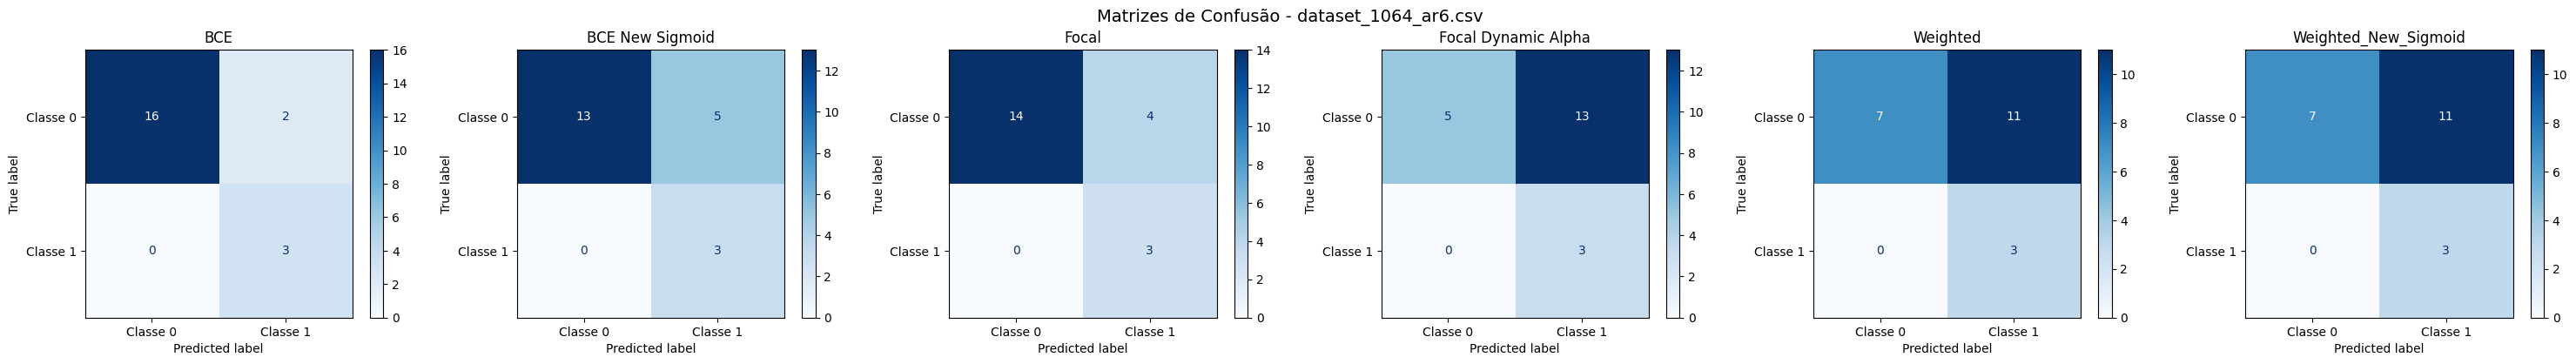


📁 Processando: dataset_1065_kc3.csv
Convergência alcançada em 810 iterações.


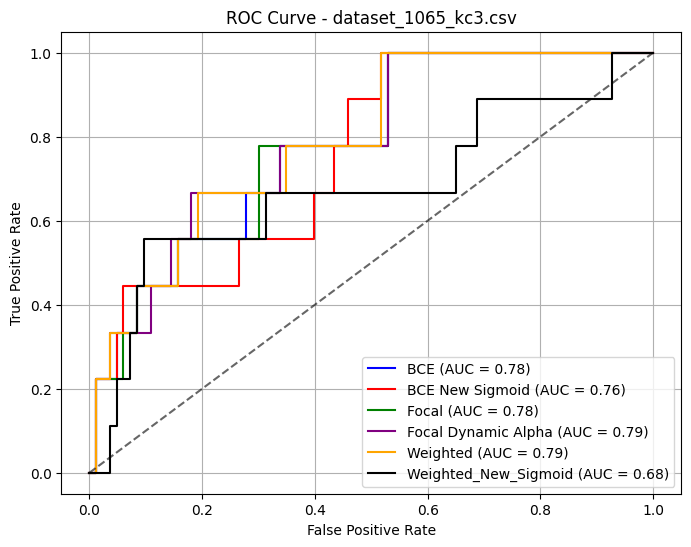

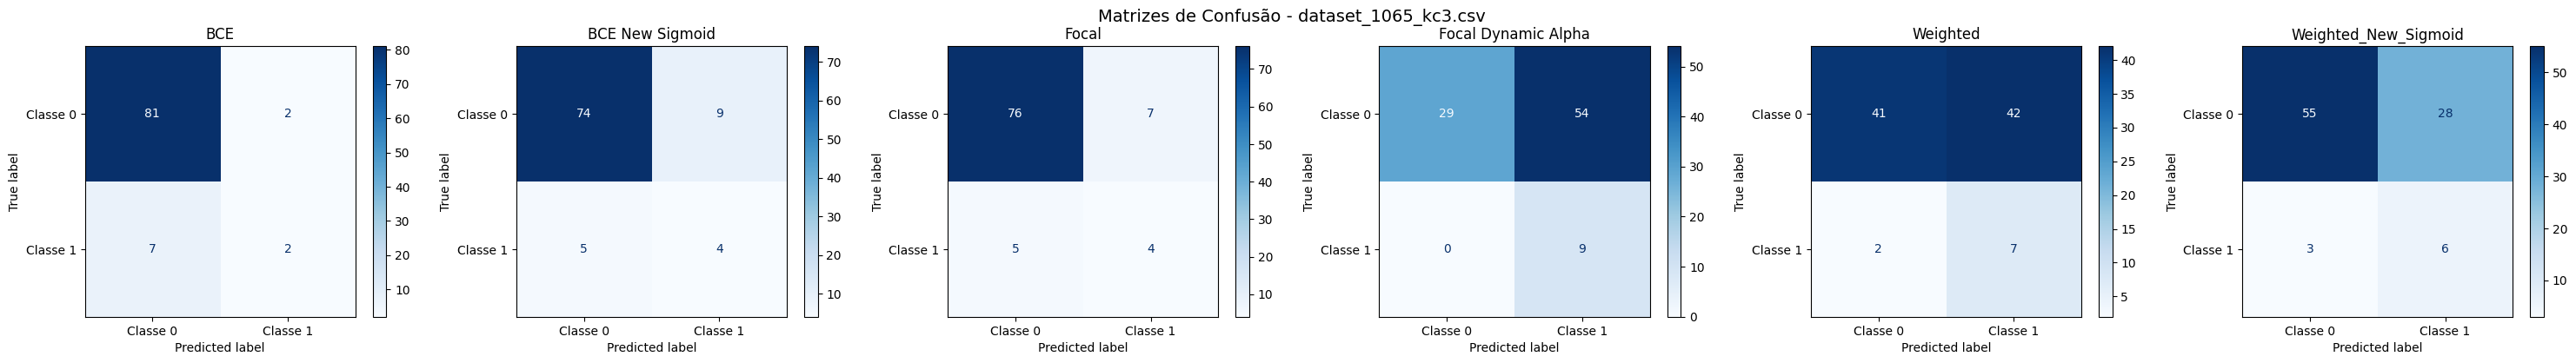


📁 Processando: dataset_311_oil_spill.csv


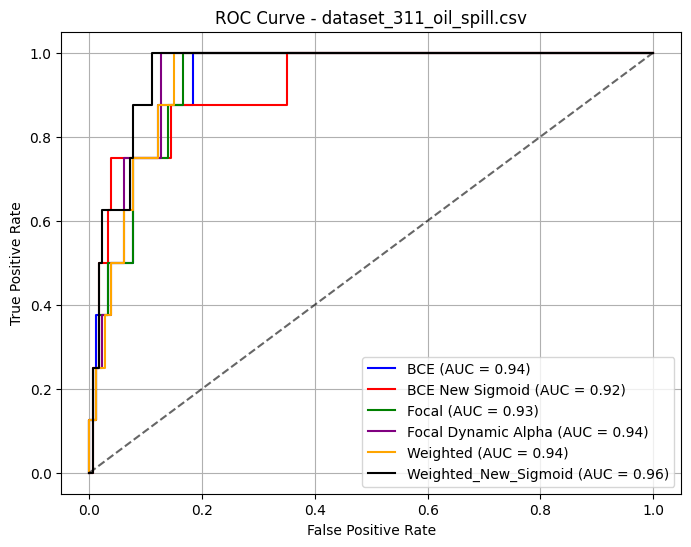

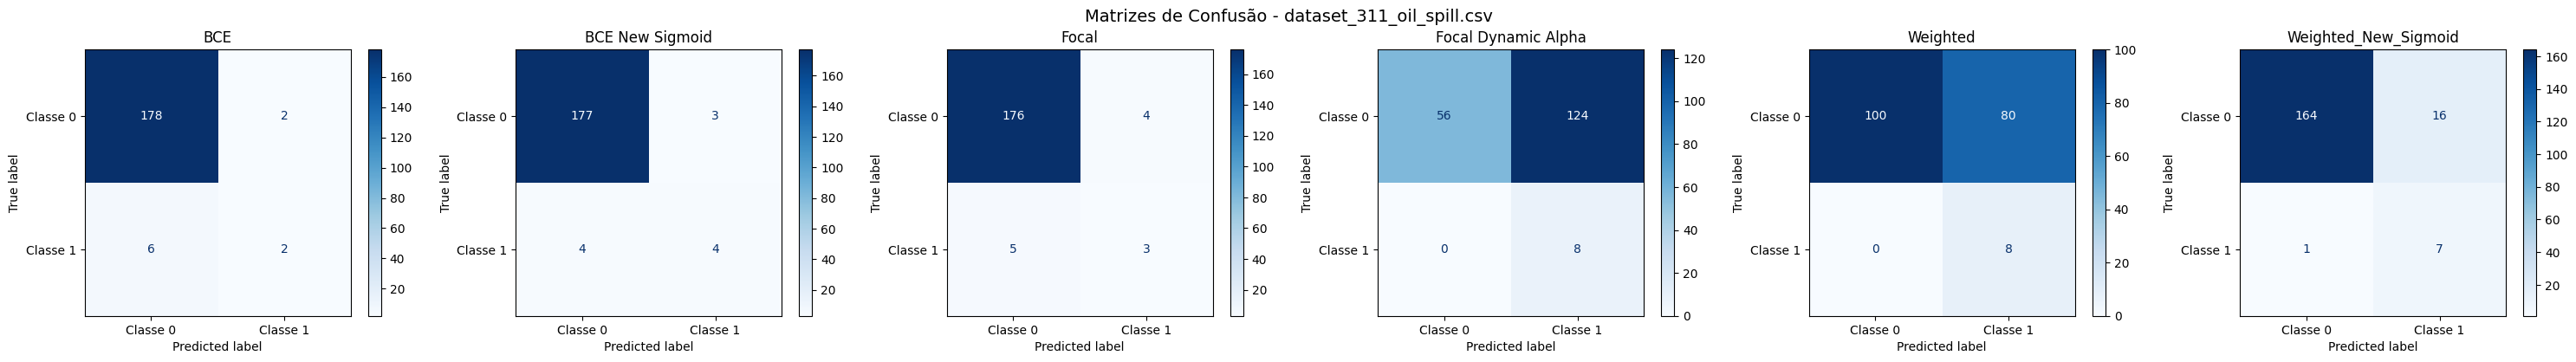


📁 Processando: dataset_312_scene.csv
Convergência alcançada em 770 iterações.


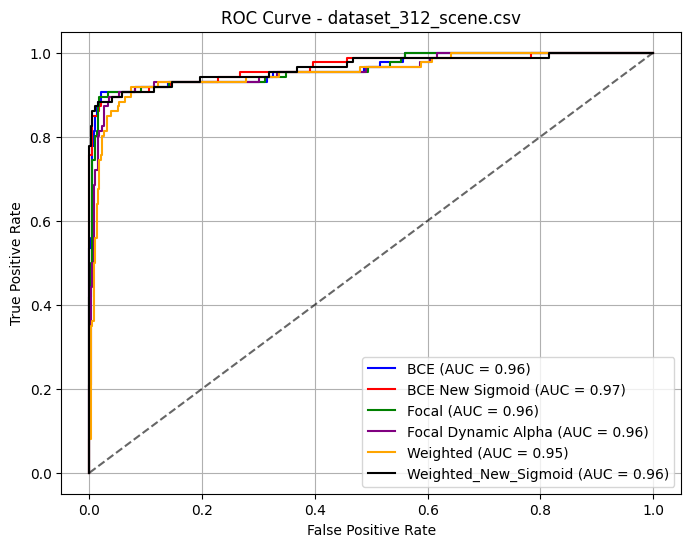

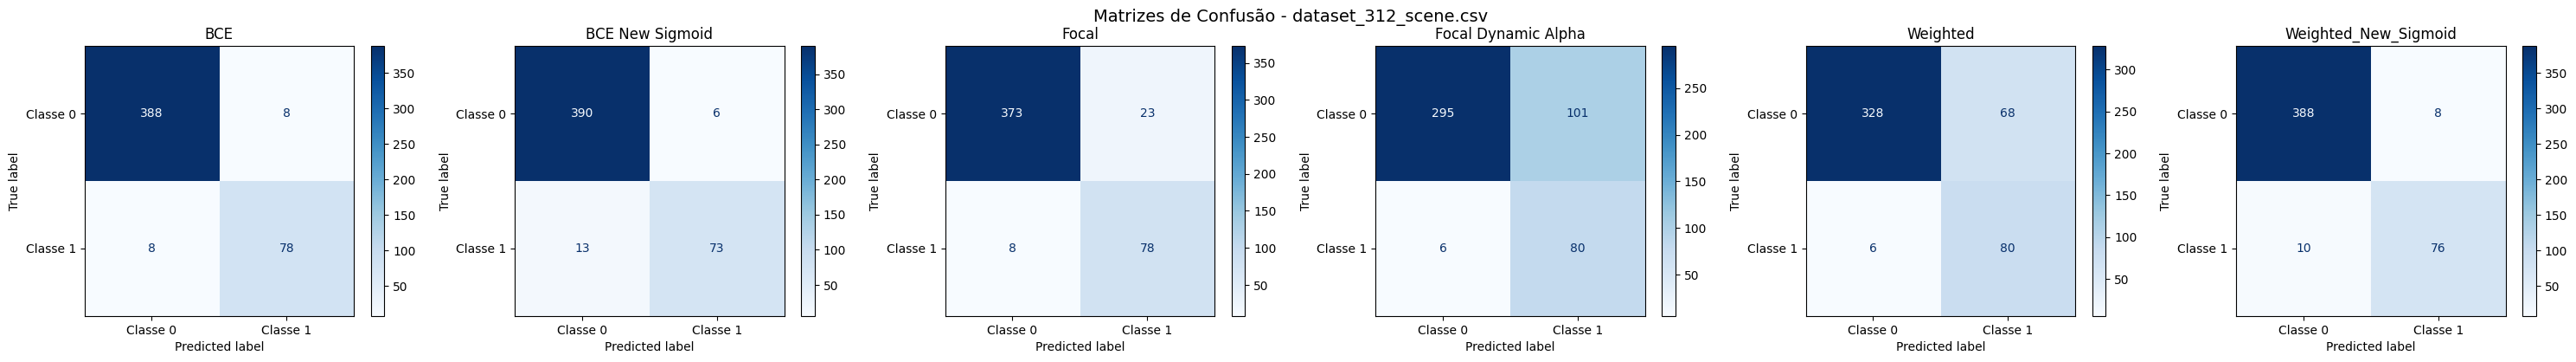


📁 Processando: dataset_316_yeast_ml8.csv
Convergência alcançada em 363 iterações.


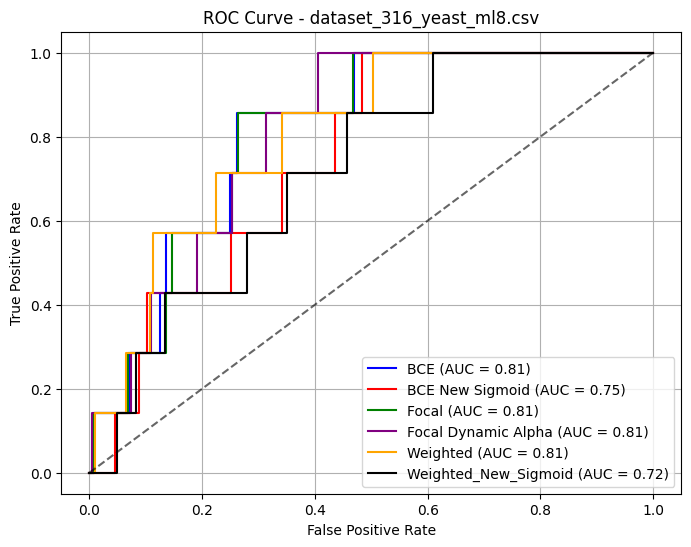

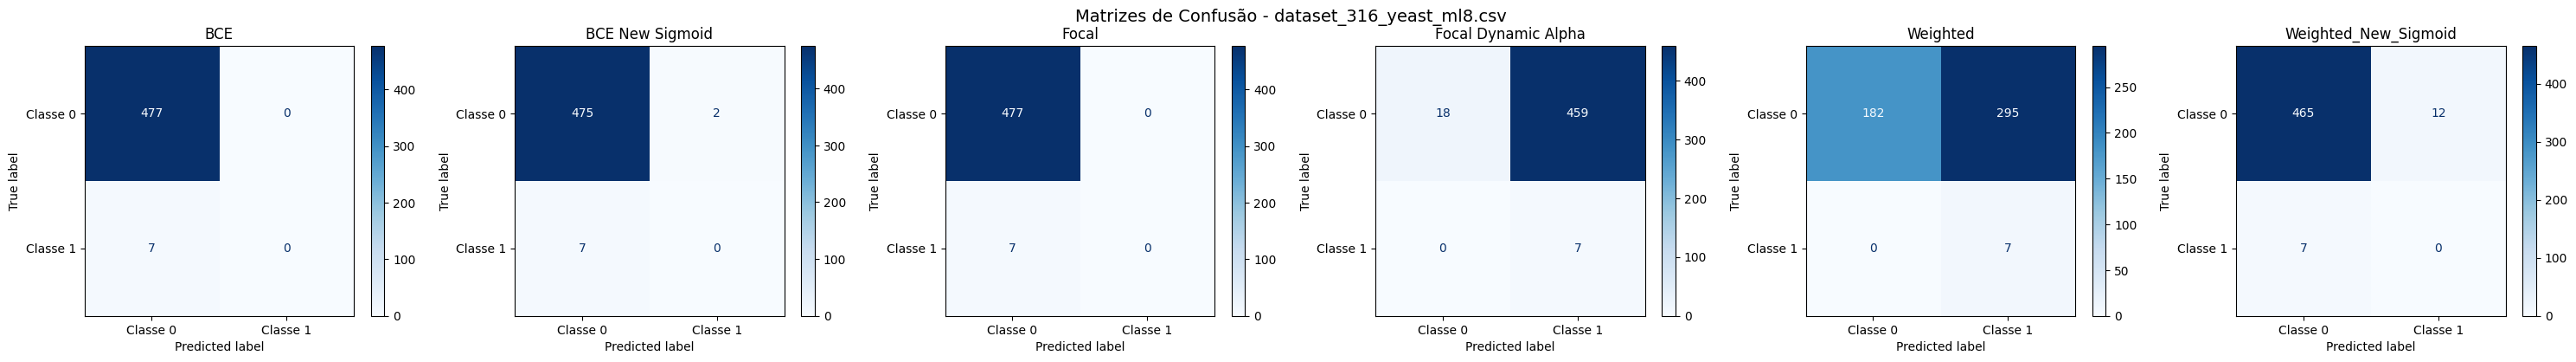


📁 Processando: dataset_38_sick.csv
Convergência alcançada em 277 iterações.
Convergência alcançada em 208 iterações.


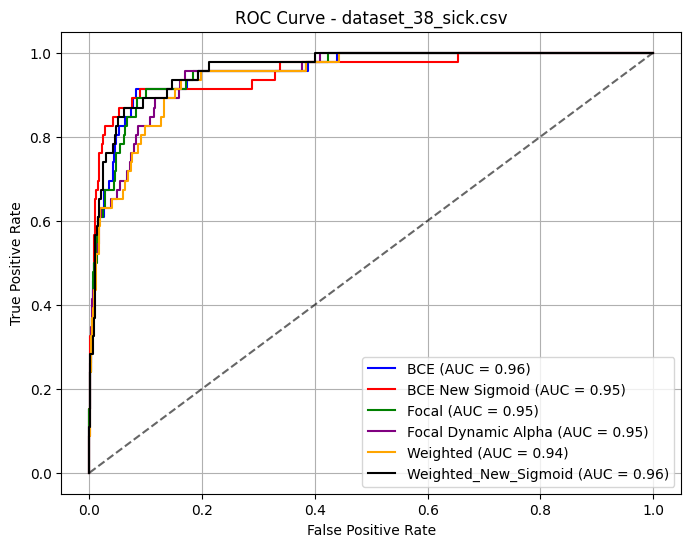

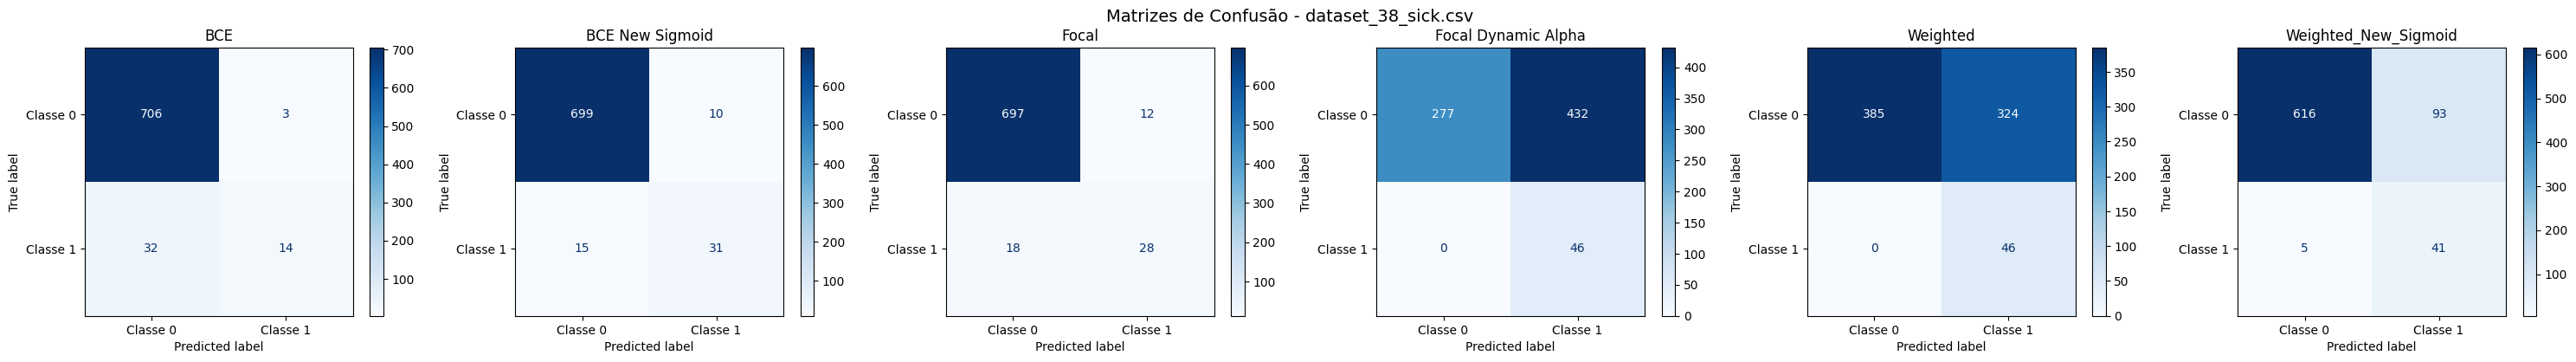


📁 Processando: dataset_450_analcatdata_lawsuit.csv


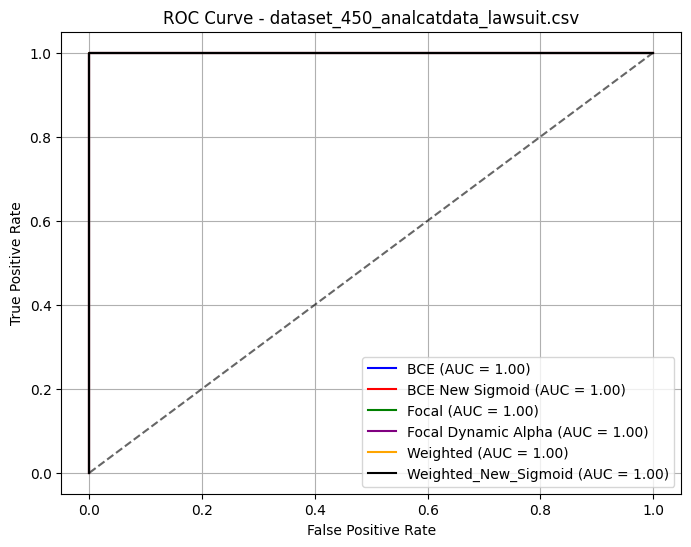

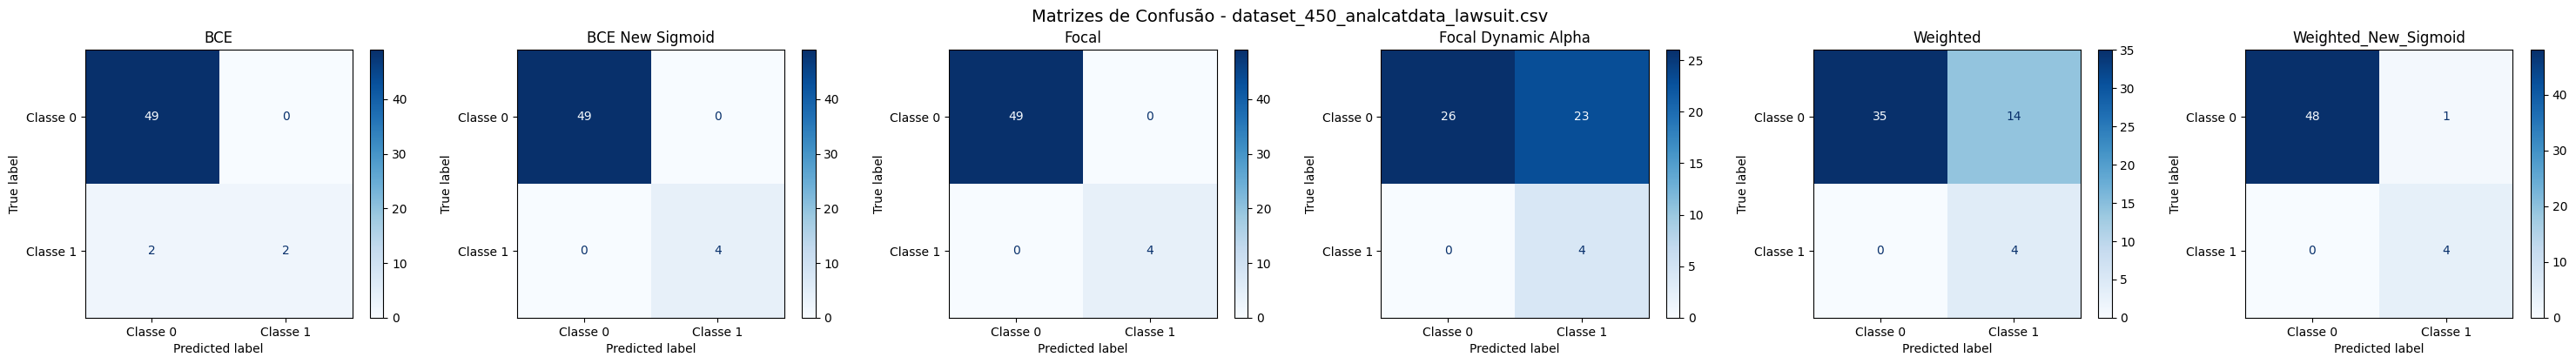


📁 Processando: dataset_463_backache.csv
Convergência alcançada em 204 iterações.


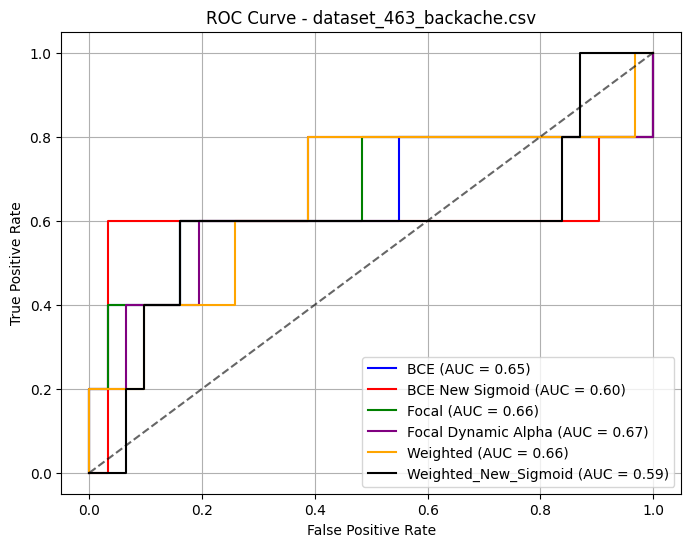

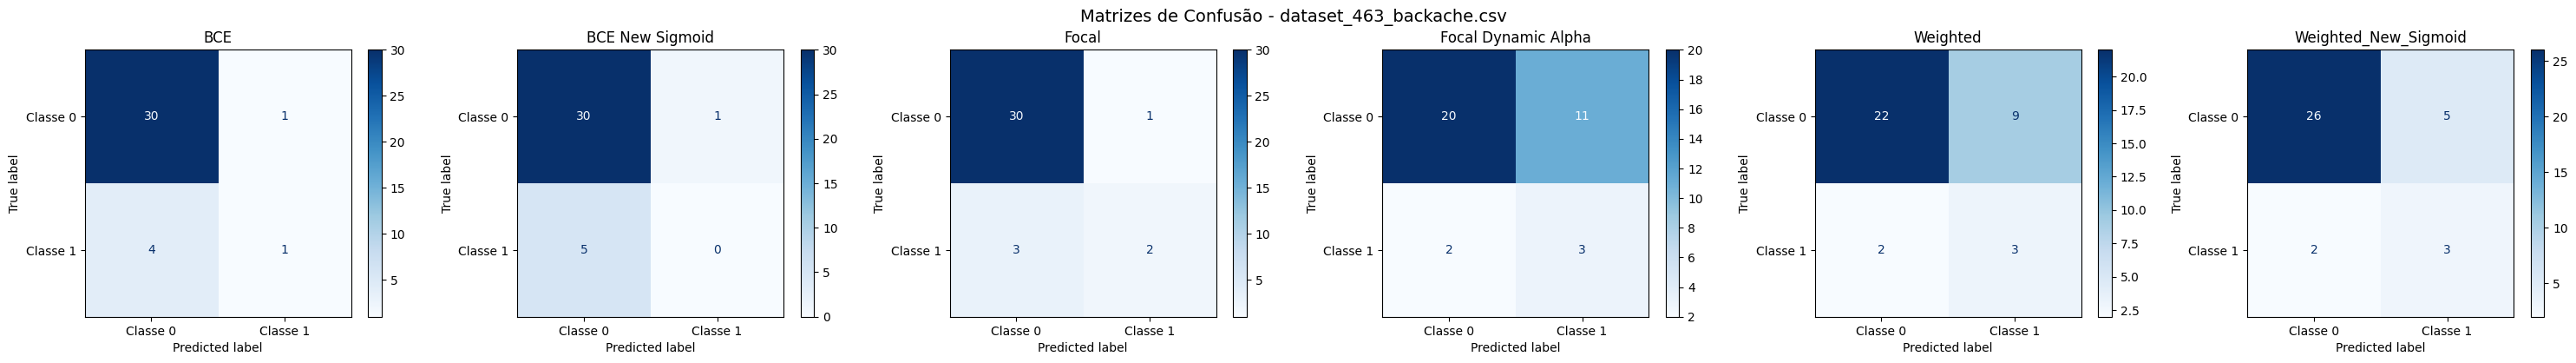


📁 Processando: dataset_757_meta.csv
Convergência alcançada em 874 iterações.
Convergência alcançada em 646 iterações.


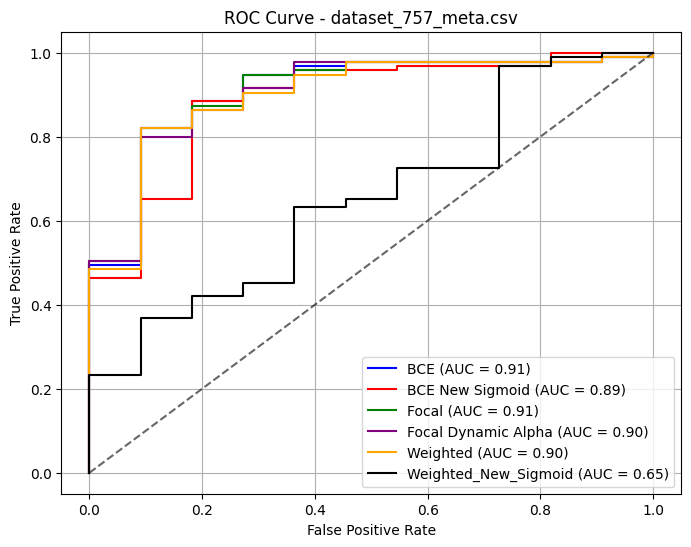

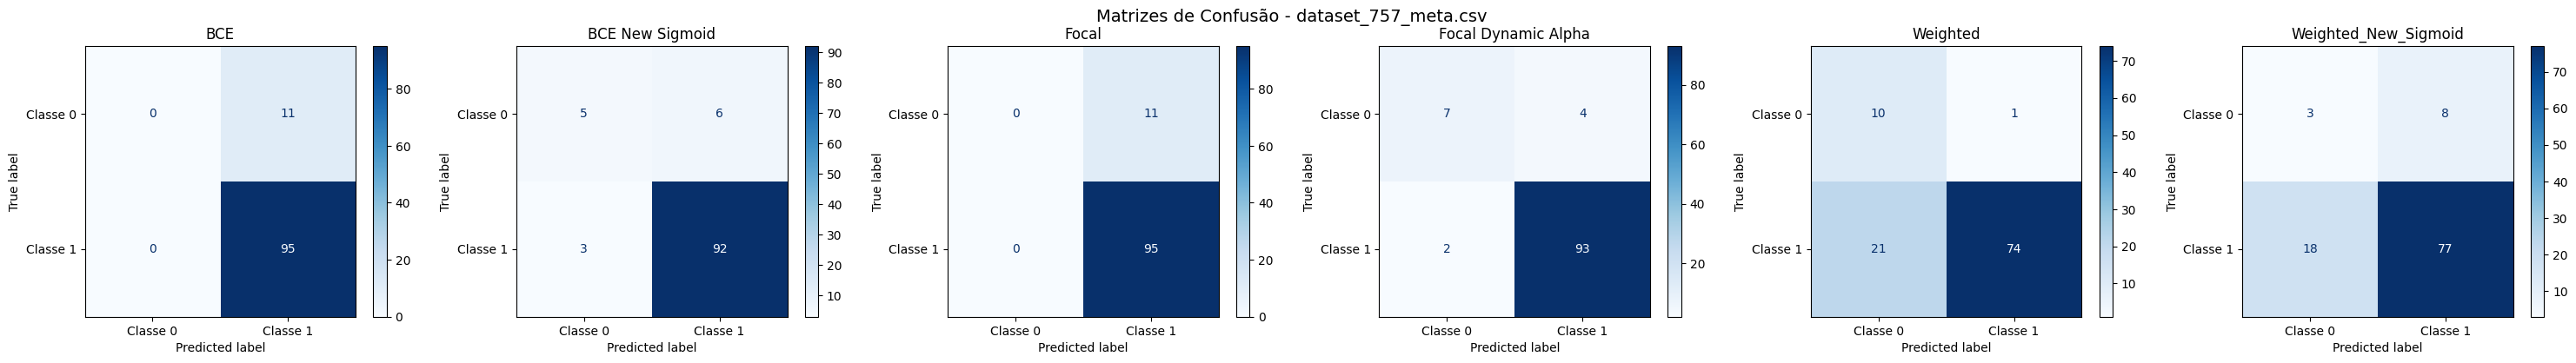


📁 Processando: dataset_764_analcatdata_apnea3.csv
Convergência alcançada em 679 iterações.
Convergência alcançada em 9 iterações.
Convergência alcançada em 506 iterações.
Convergência alcançada em 180 iterações.
Convergência alcançada em 447 iterações.
Convergência alcançada em 6 iterações.


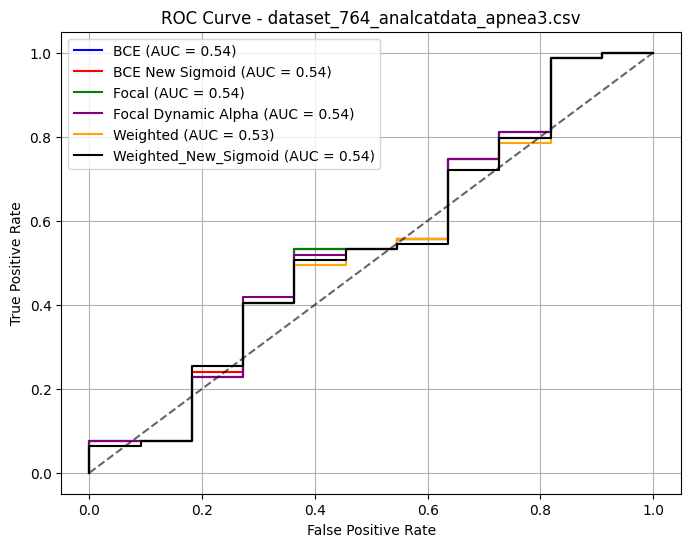

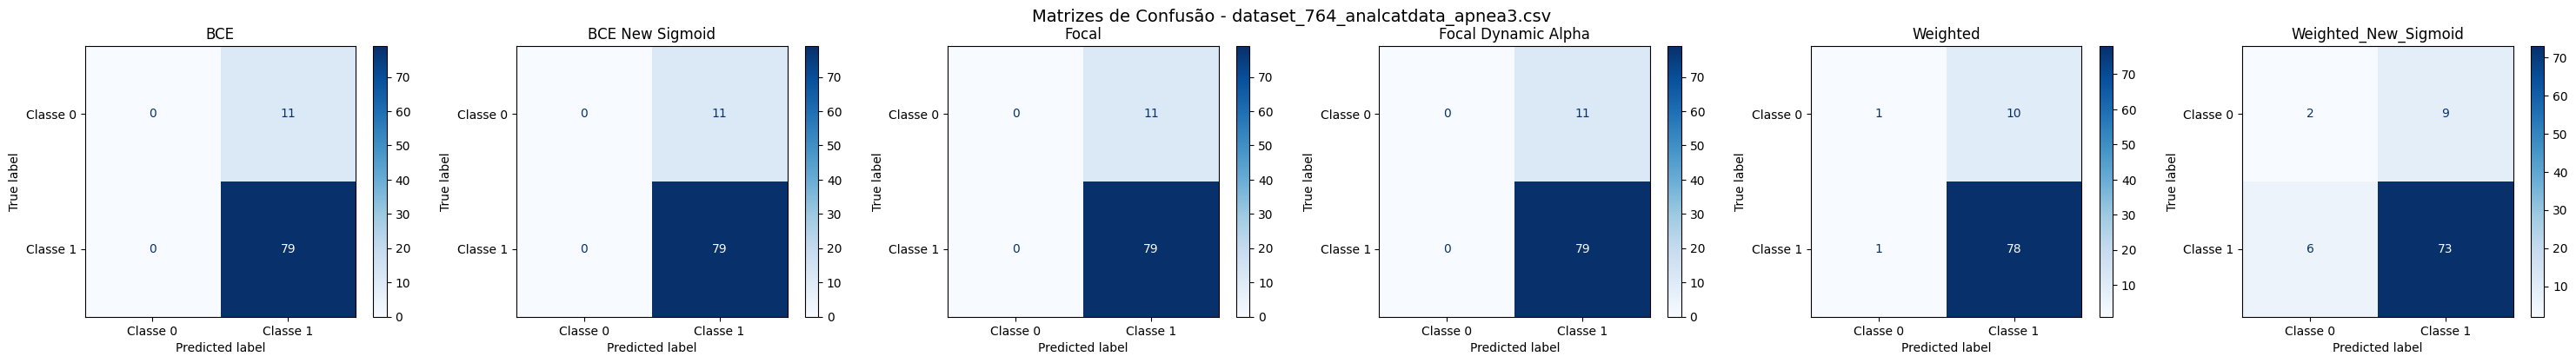


📁 Processando: dataset_765_analcatdata_apnea2.csv
Convergência alcançada em 614 iterações.
Convergência alcançada em 6 iterações.
Convergência alcançada em 471 iterações.
Convergência alcançada em 181 iterações.
Convergência alcançada em 424 iterações.
Convergência alcançada em 5 iterações.


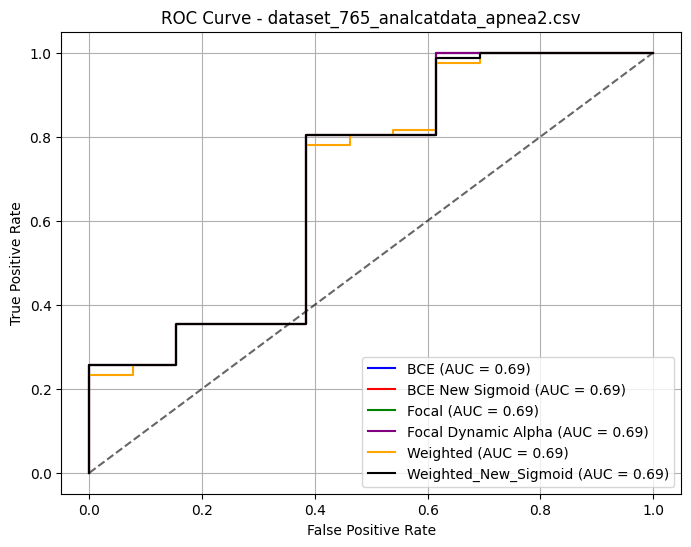

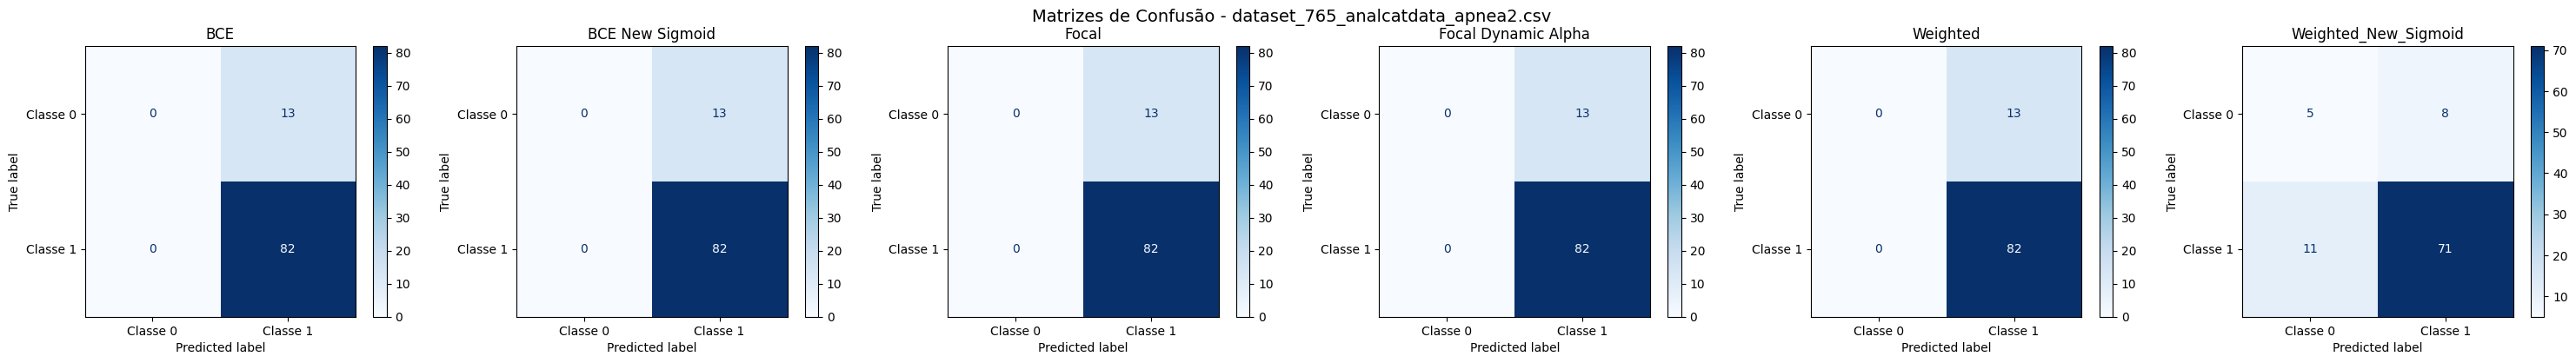


📁 Processando: dataset_767_analcatdata_apnea1.csv
Convergência alcançada em 678 iterações.
Convergência alcançada em 8 iterações.
Convergência alcançada em 503 iterações.
Convergência alcançada em 218 iterações.
Convergência alcançada em 502 iterações.
Convergência alcançada em 6 iterações.


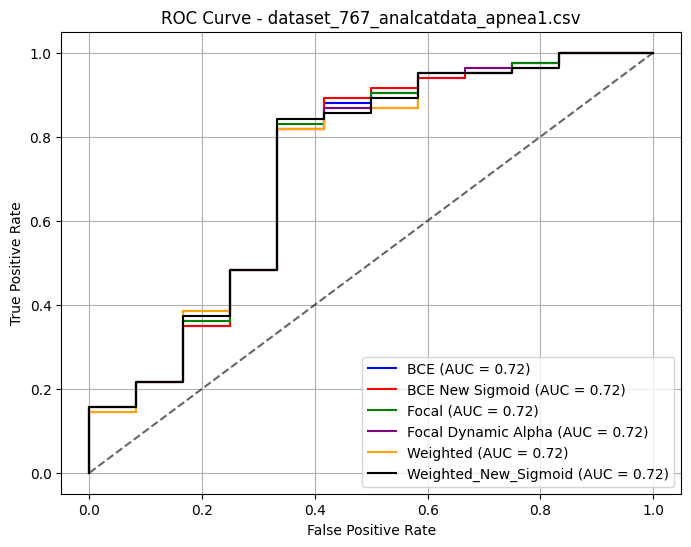

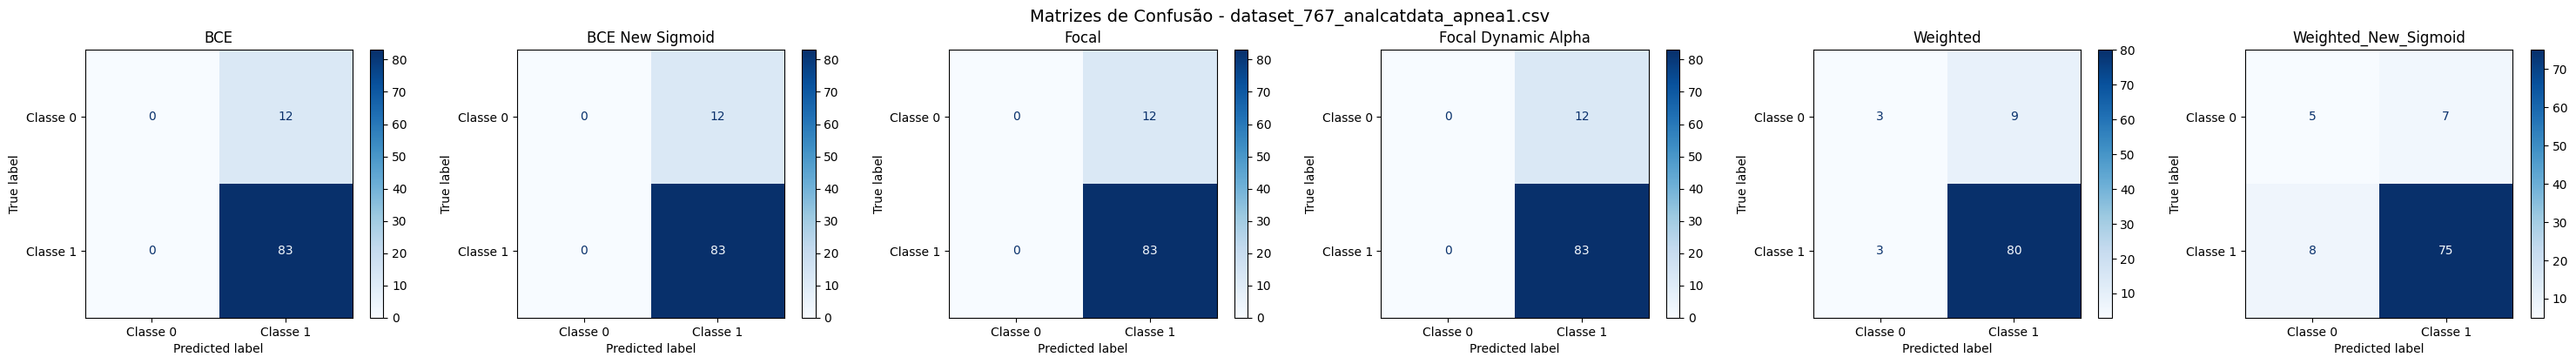


📁 Processando: dataset_865_analcatdata_neavote.csv
Convergência alcançada em 52 iterações.
Convergência alcançada em 709 iterações.
Convergência alcançada em 292 iterações.
Convergência alcançada em 638 iterações.


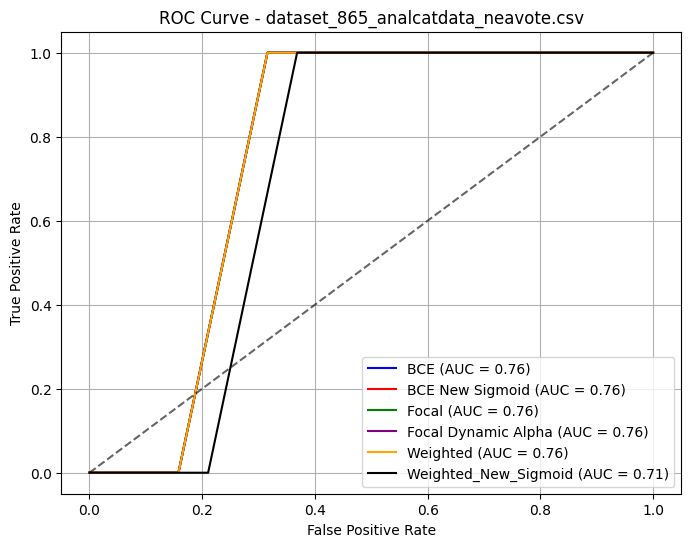

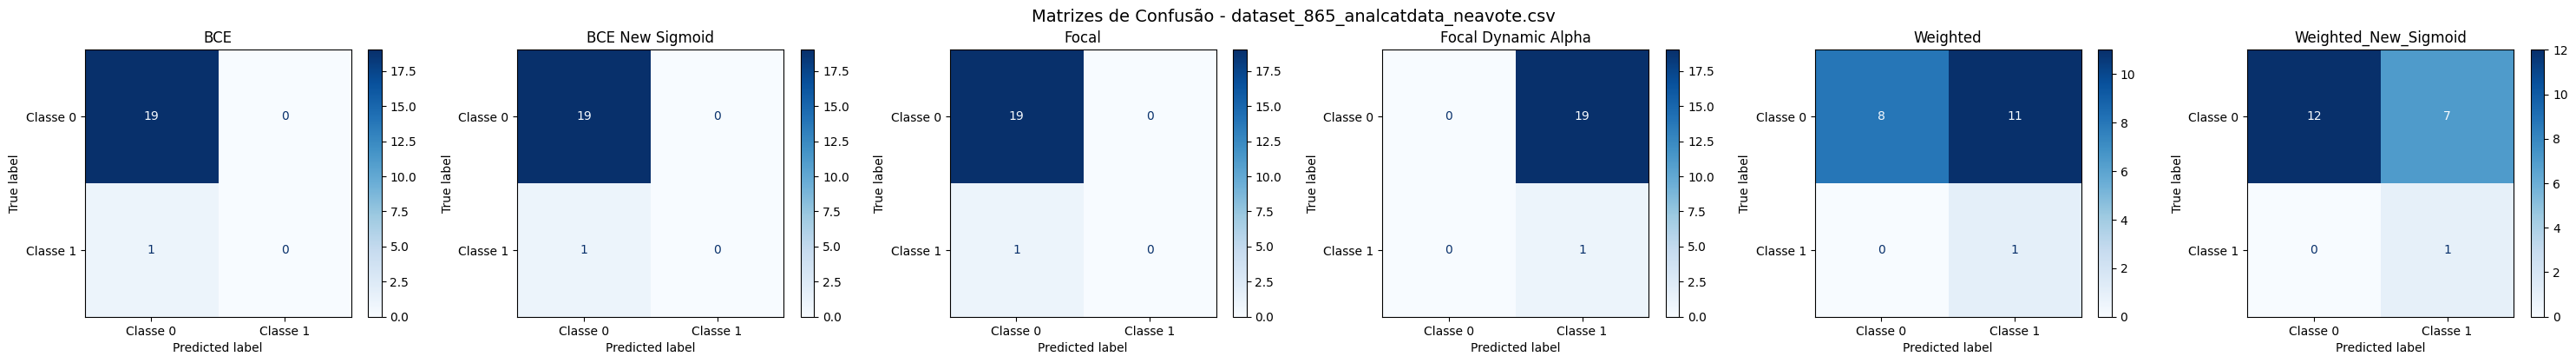


📁 Processando: dataset_867_visualizing_livestock.csv
Convergência alcançada em 744 iterações.
Convergência alcançada em 11 iterações.
Convergência alcançada em 536 iterações.
Convergência alcançada em 416 iterações.
Convergência alcançada em 823 iterações.
Convergência alcançada em 5 iterações.


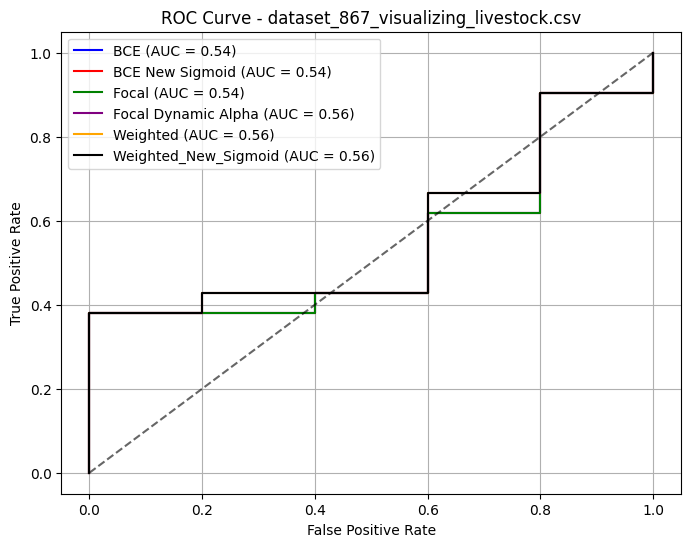

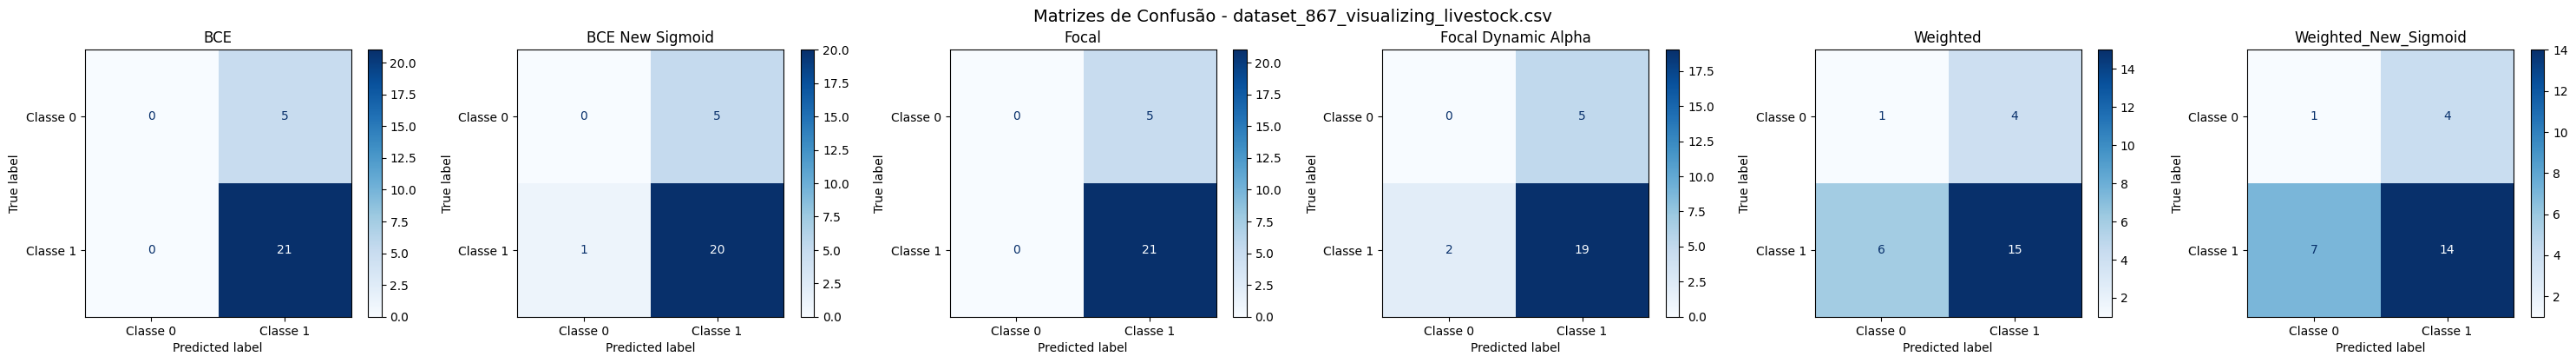


📁 Processando: dataset_875_analcatdata_chlamydia.csv
Convergência alcançada em 38 iterações.
Convergência alcançada em 944 iterações.
Convergência alcançada em 922 iterações.
Convergência alcançada em 30 iterações.


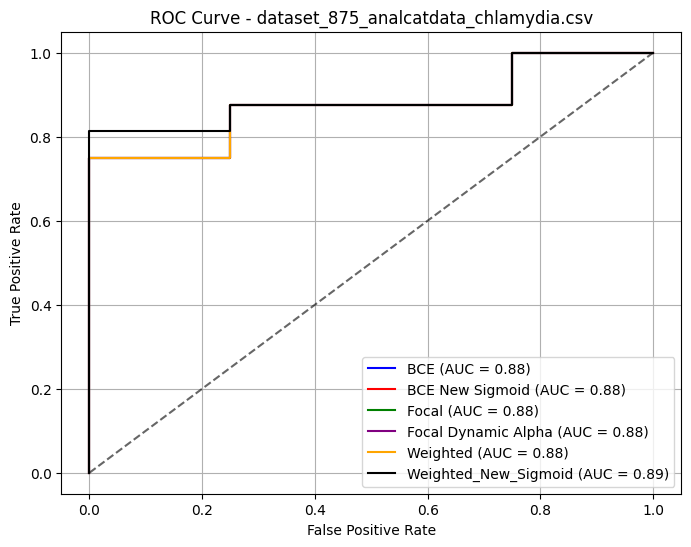

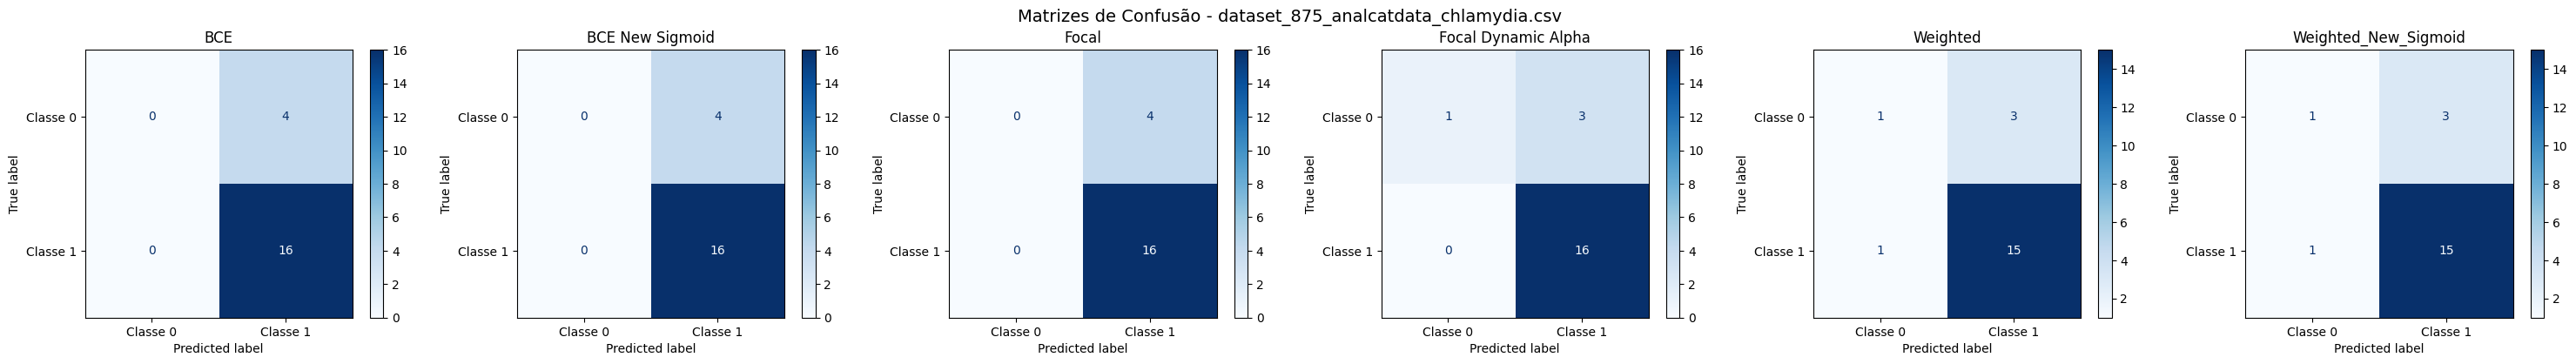


📁 Processando: dataset_940_water-treatment.csv


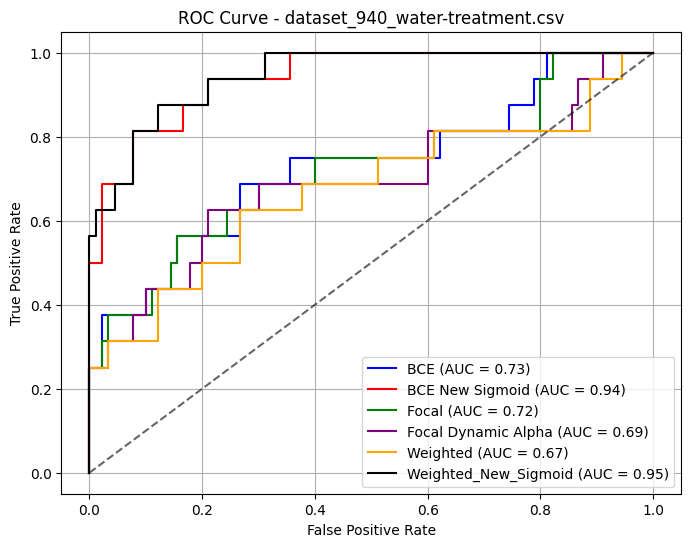

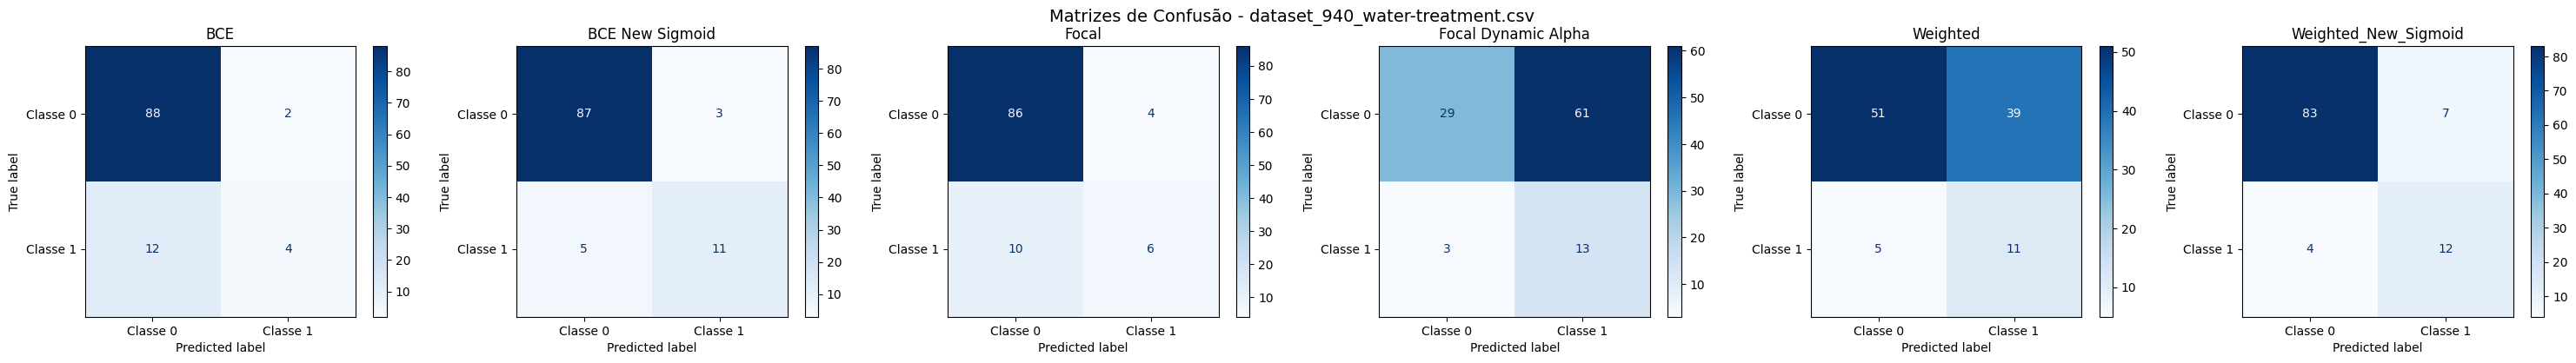


📁 Processando: dataset_947_arsenic-male-bladder.csv
Convergência alcançada em 567 iterações.
Convergência alcançada em 537 iterações.
Convergência alcançada em 327 iterações.


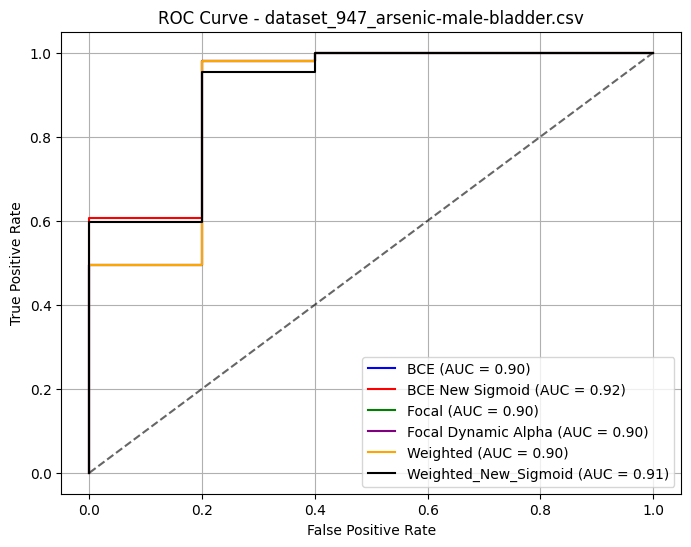

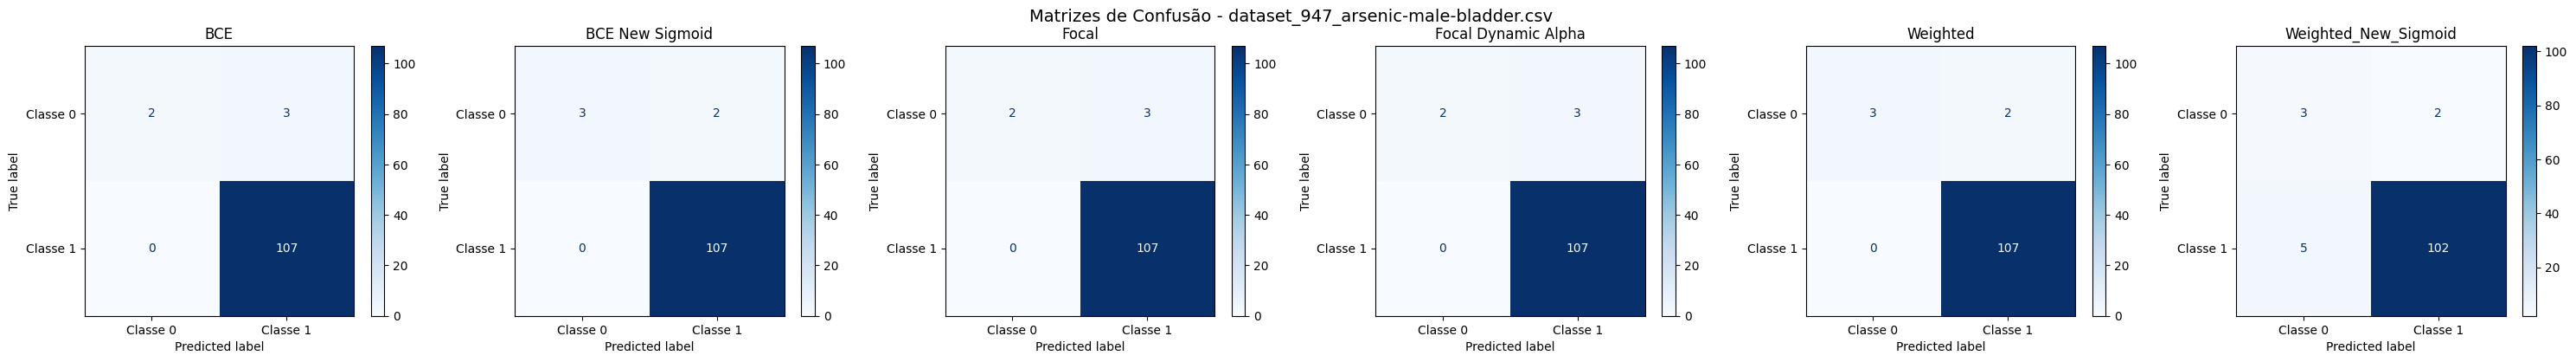


📁 Processando: dataset_949_arsenic-female-bladder.csv
Convergência alcançada em 206 iterações.
Convergência alcançada em 717 iterações.
Convergência alcançada em 618 iterações.
Convergência alcançada em 304 iterações.


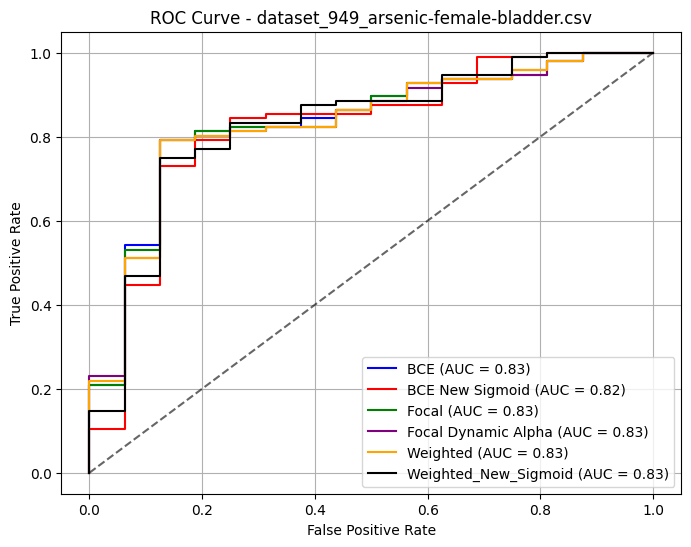

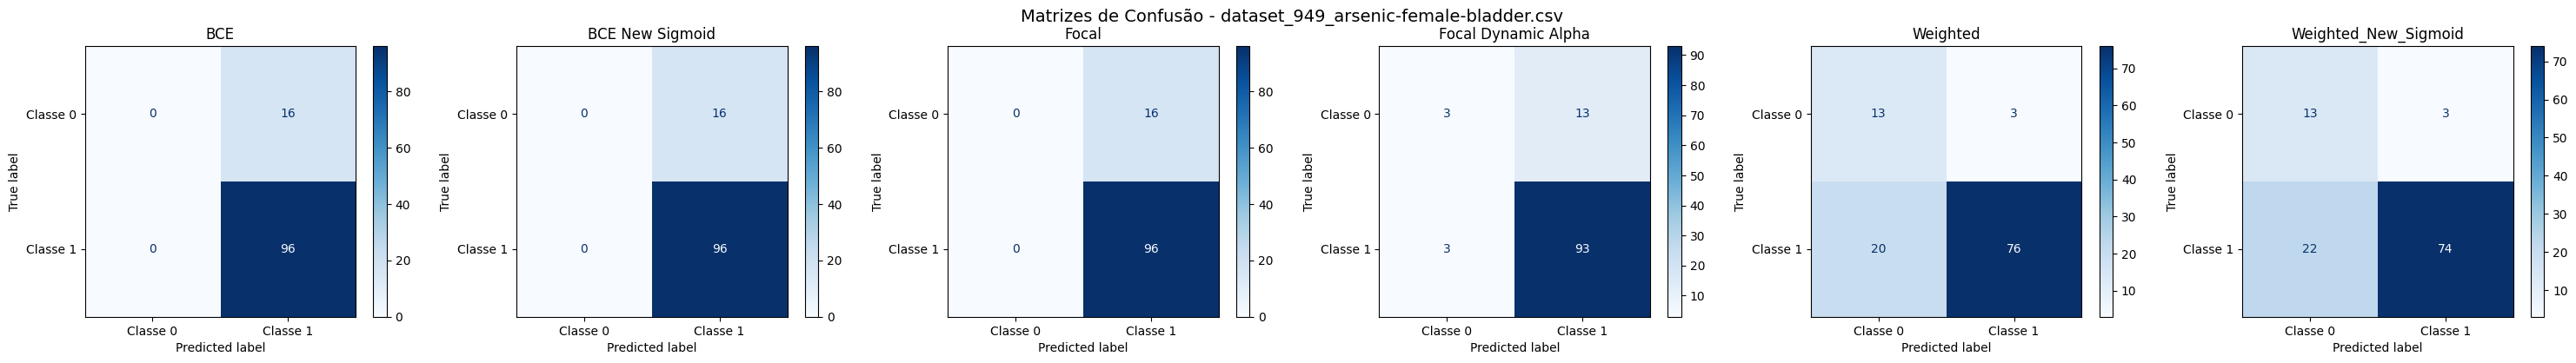


📁 Processando: dataset_950_arsenic-female-lung.csv
Convergência alcançada em 626 iterações.
Convergência alcançada em 565 iterações.
Convergência alcançada em 221 iterações.


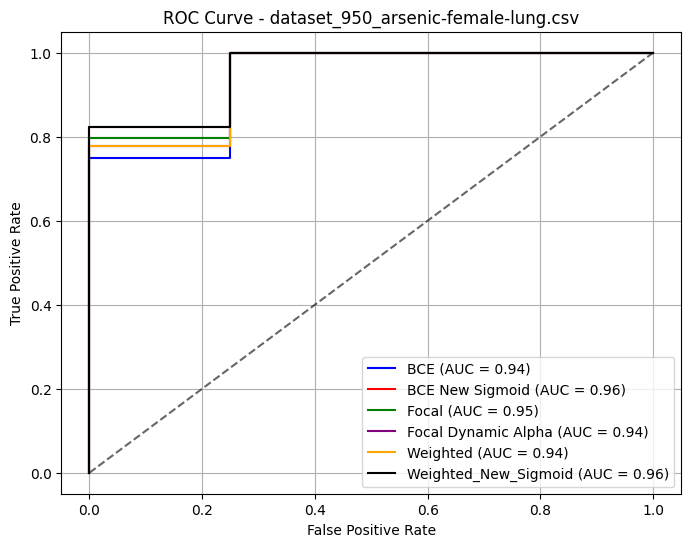

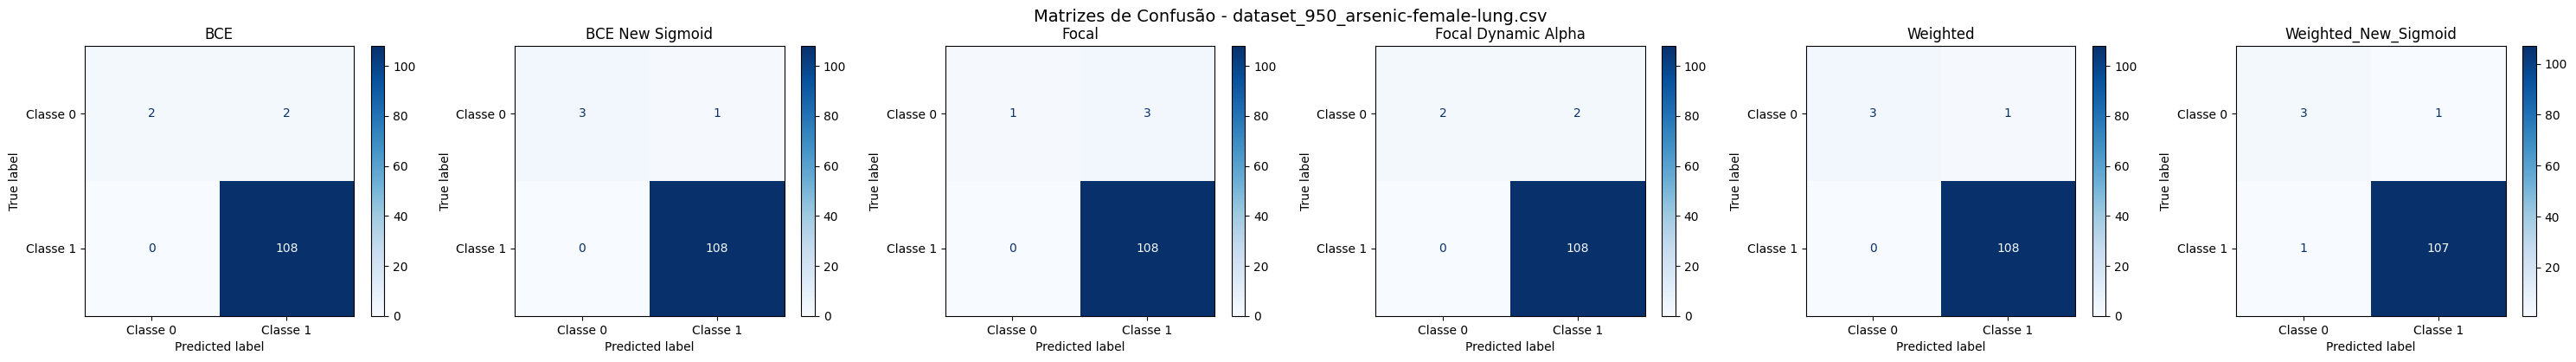


📁 Processando: dataset_951_arsenic-male-lung.csv
Convergência alcançada em 912 iterações.
Convergência alcançada em 612 iterações.


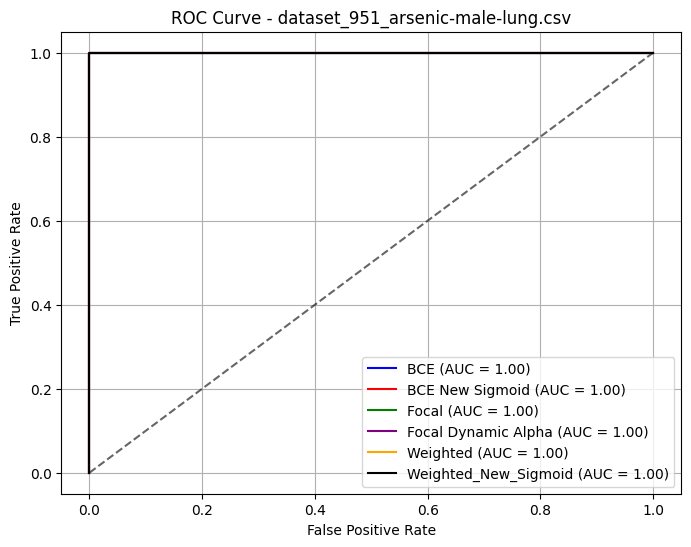

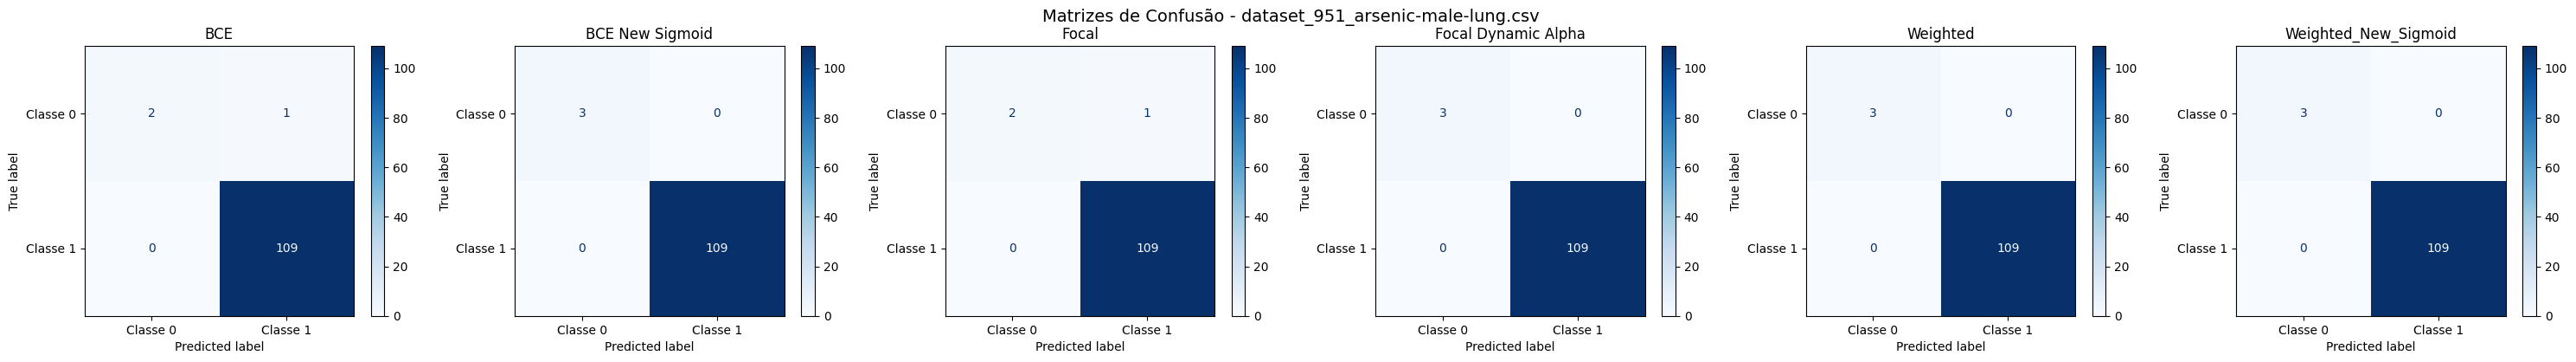


📁 Processando: dataset_954_spectrometer.csv


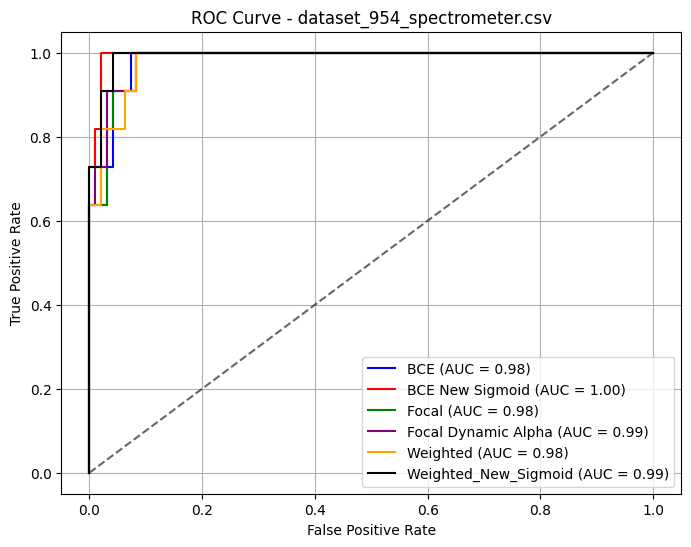

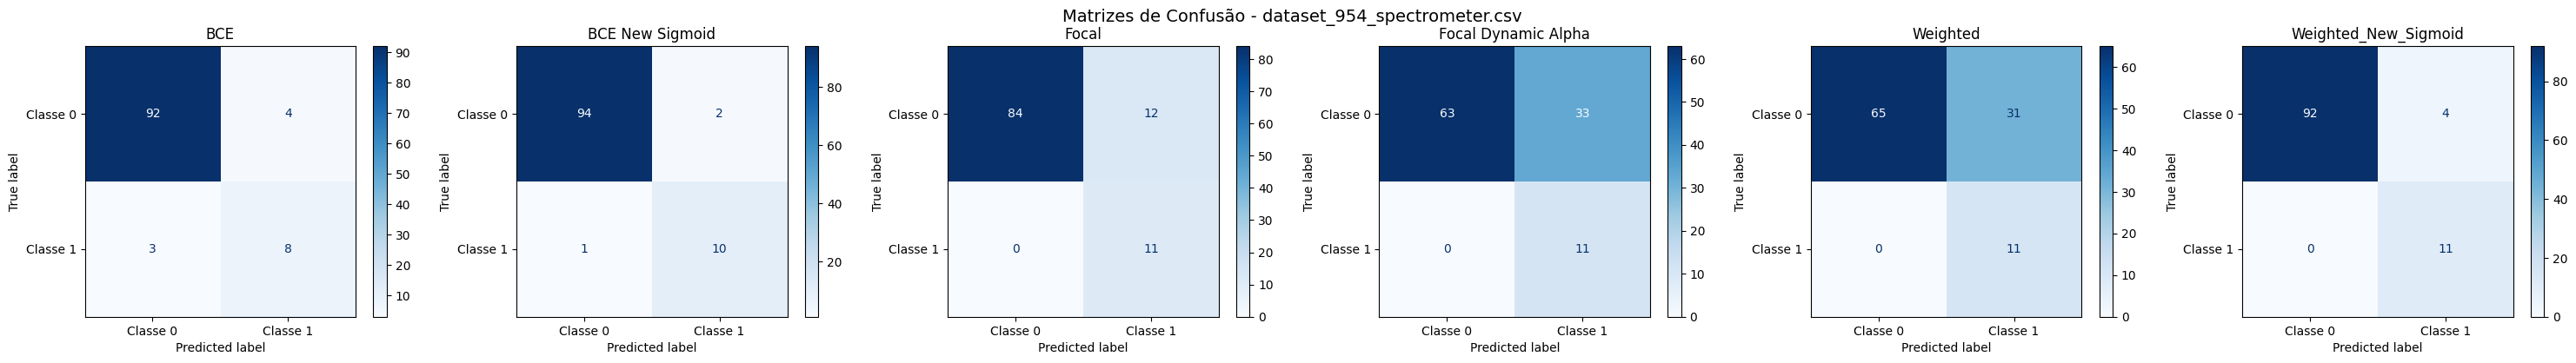


📁 Processando: dataset_958_segment.csv


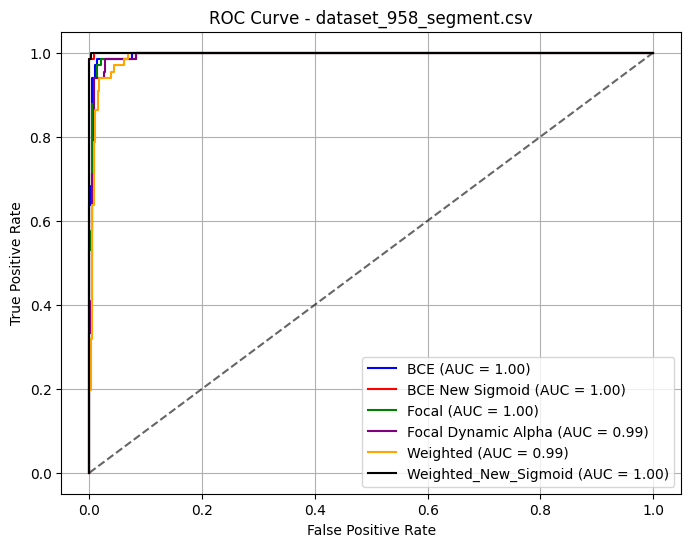

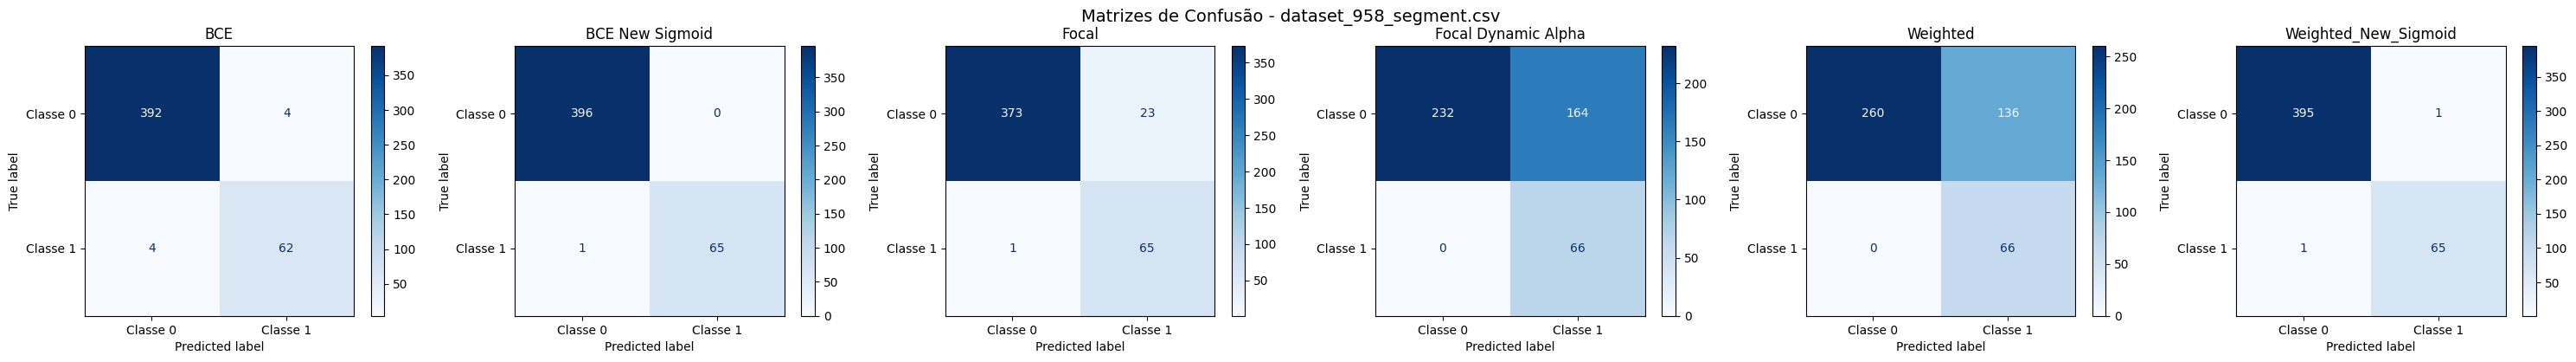


📁 Processando: dataset_962_mfeat-morphological.csv
Convergência alcançada em 827 iterações.
Convergência alcançada em 913 iterações.


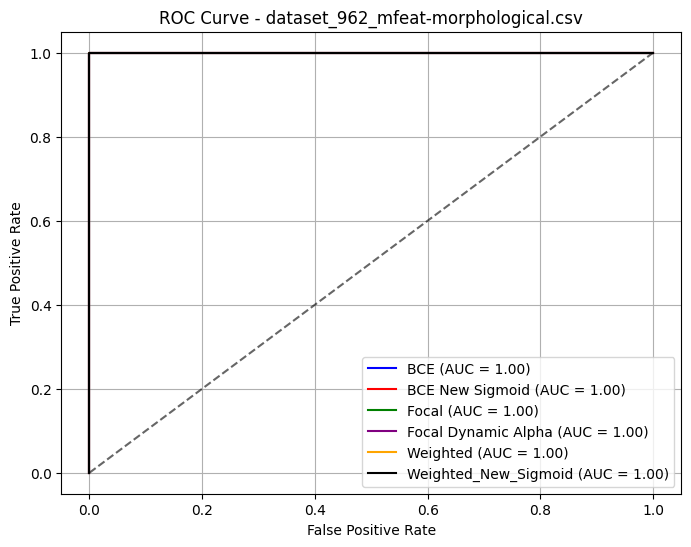

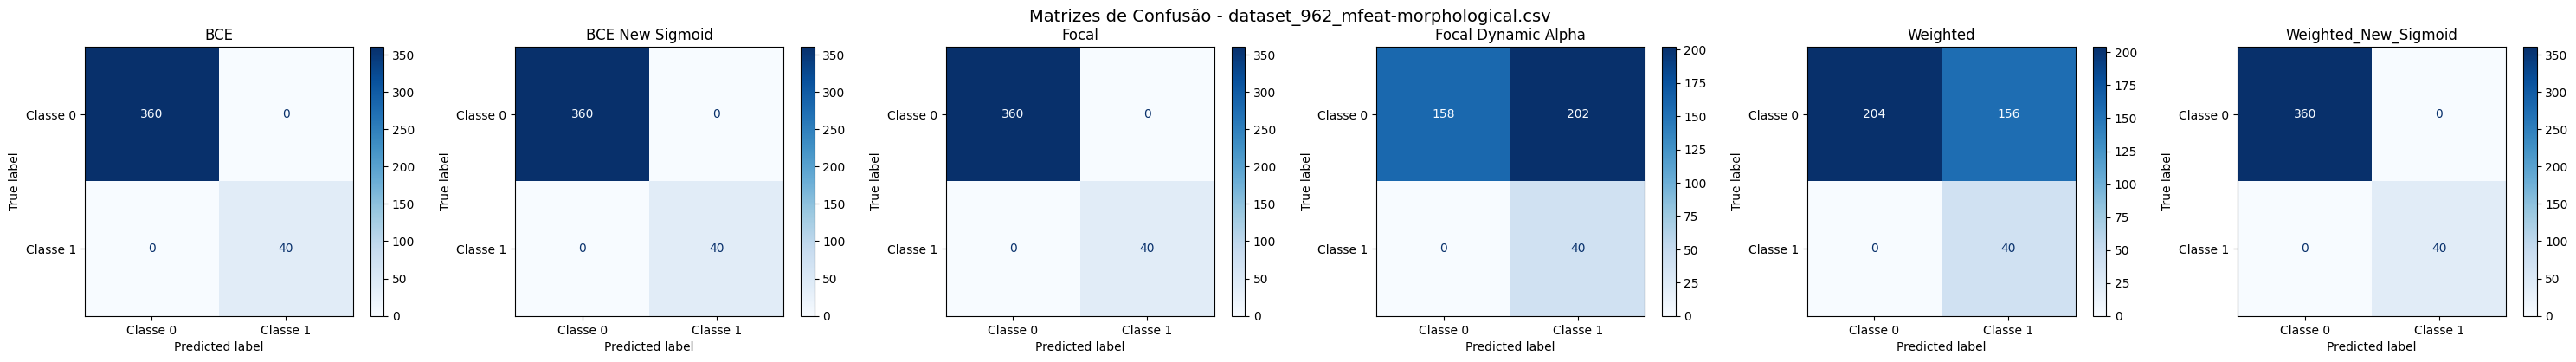


📁 Processando: dataset_966_analcatdata_halloffame.csv


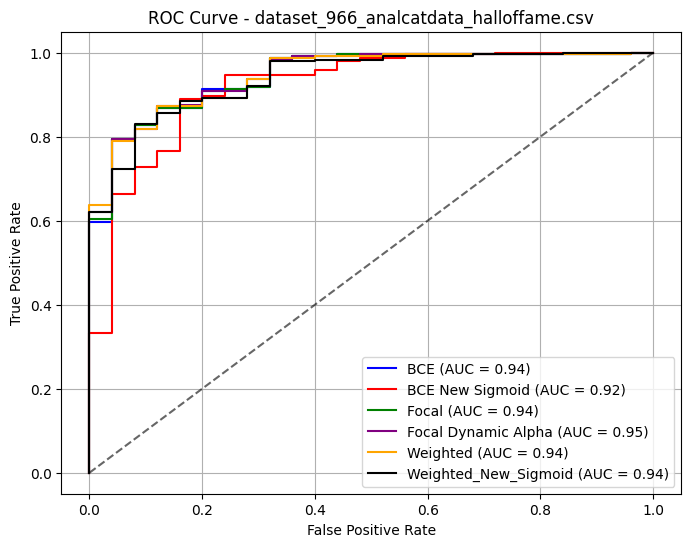

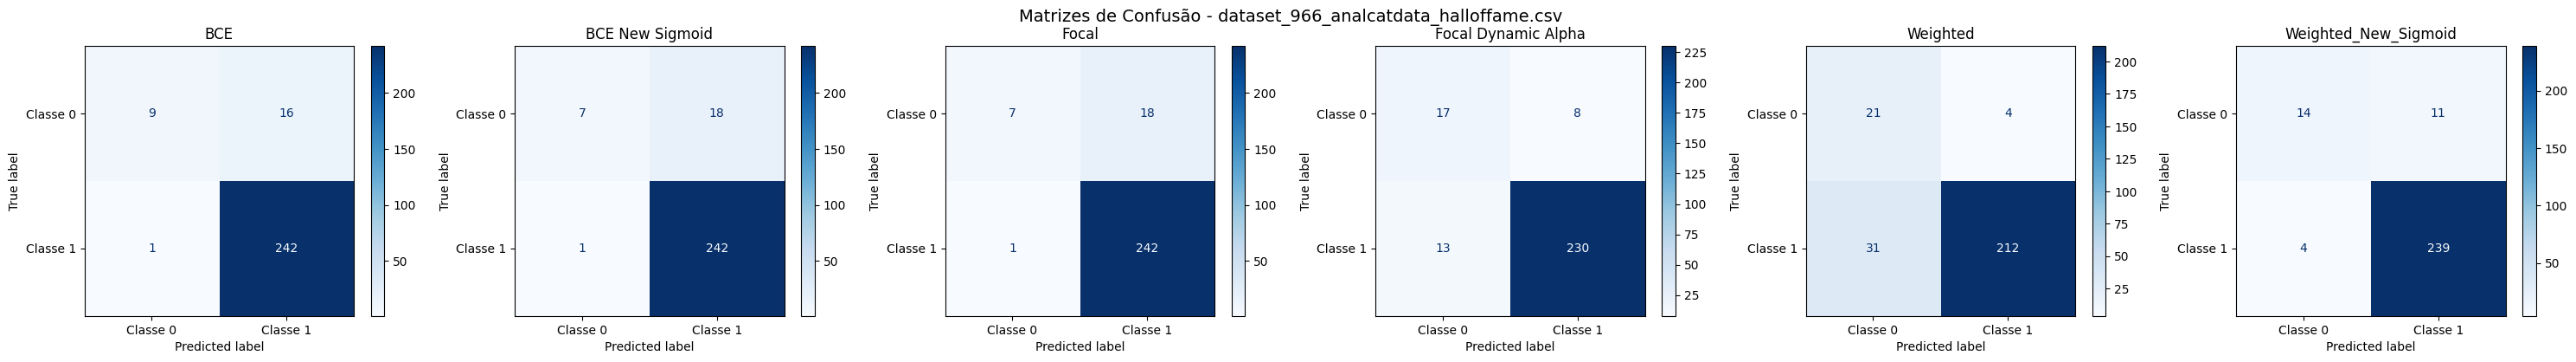


📁 Processando: dataset_968_analcatdata_birthday.csv
Convergência alcançada em 75 iterações.
Convergência alcançada em 61 iterações.


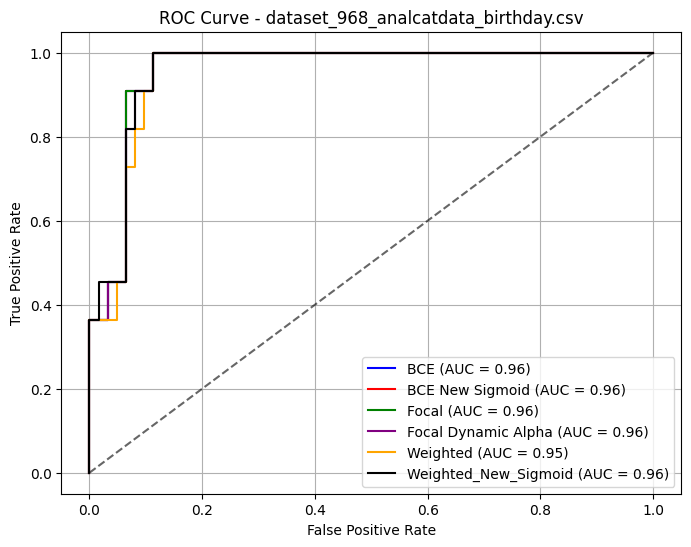

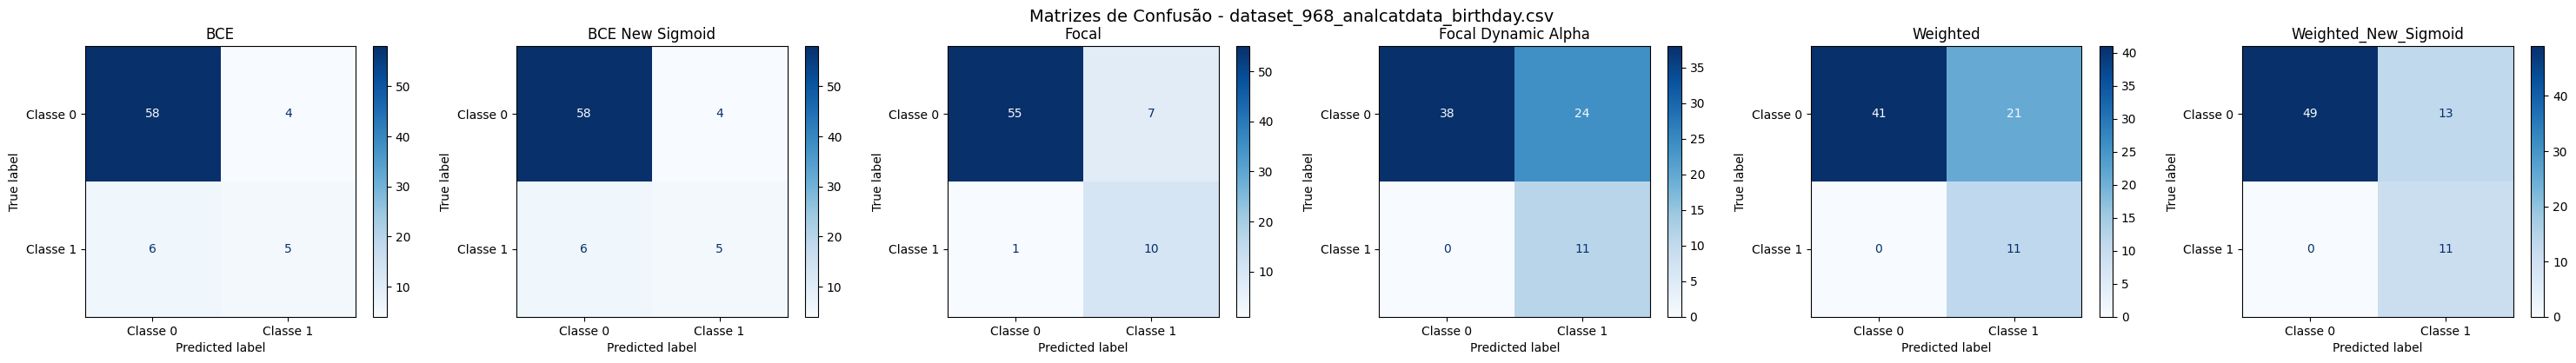


📁 Processando: dataset_971_mfeat-fourier.csv
Convergência alcançada em 502 iterações.
Convergência alcançada em 634 iterações.


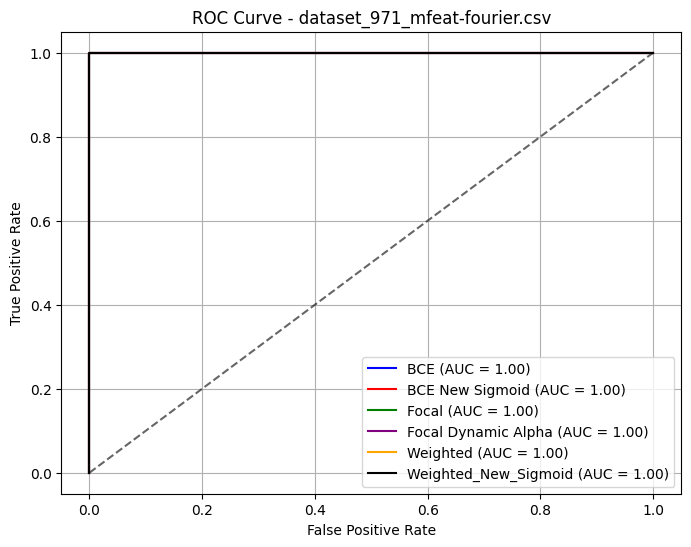

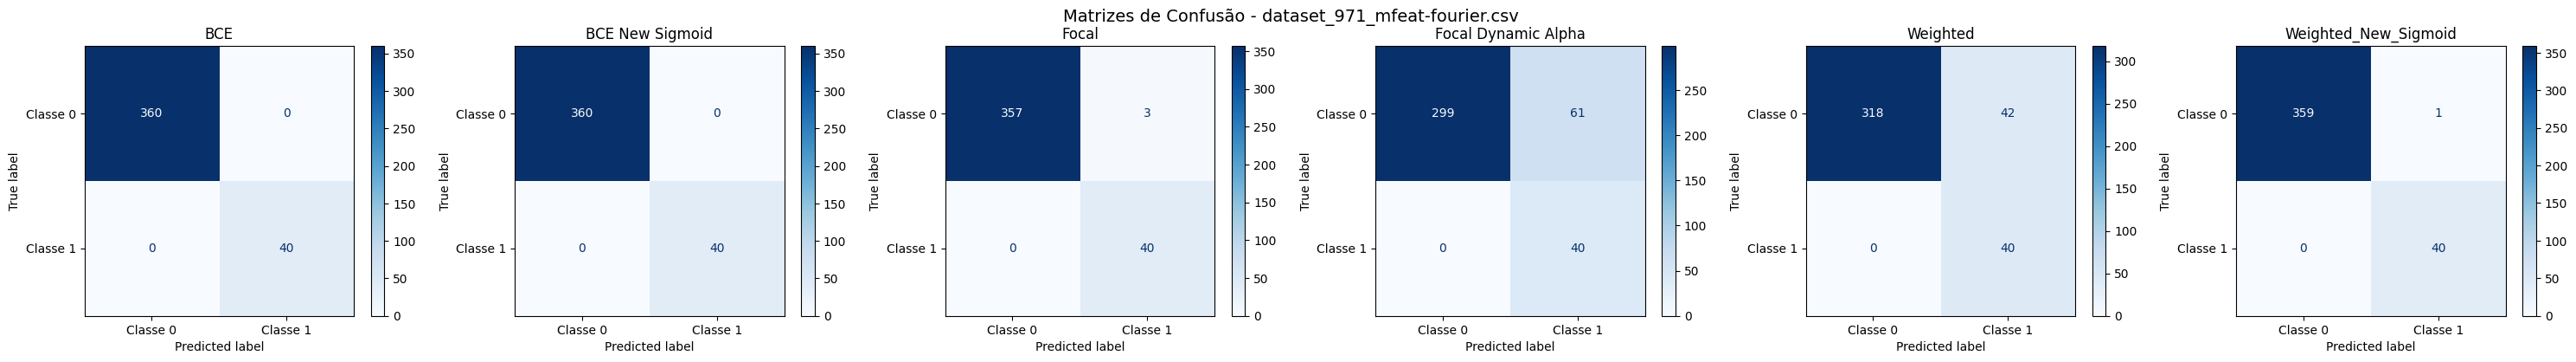


📁 Processando: dataset_976_JapaneseVowels.csv
Convergência alcançada em 369 iterações.
Convergência alcançada em 318 iterações.


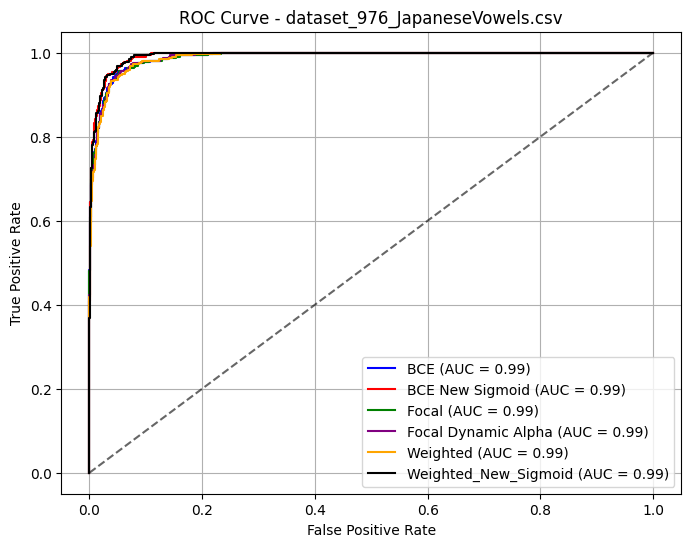

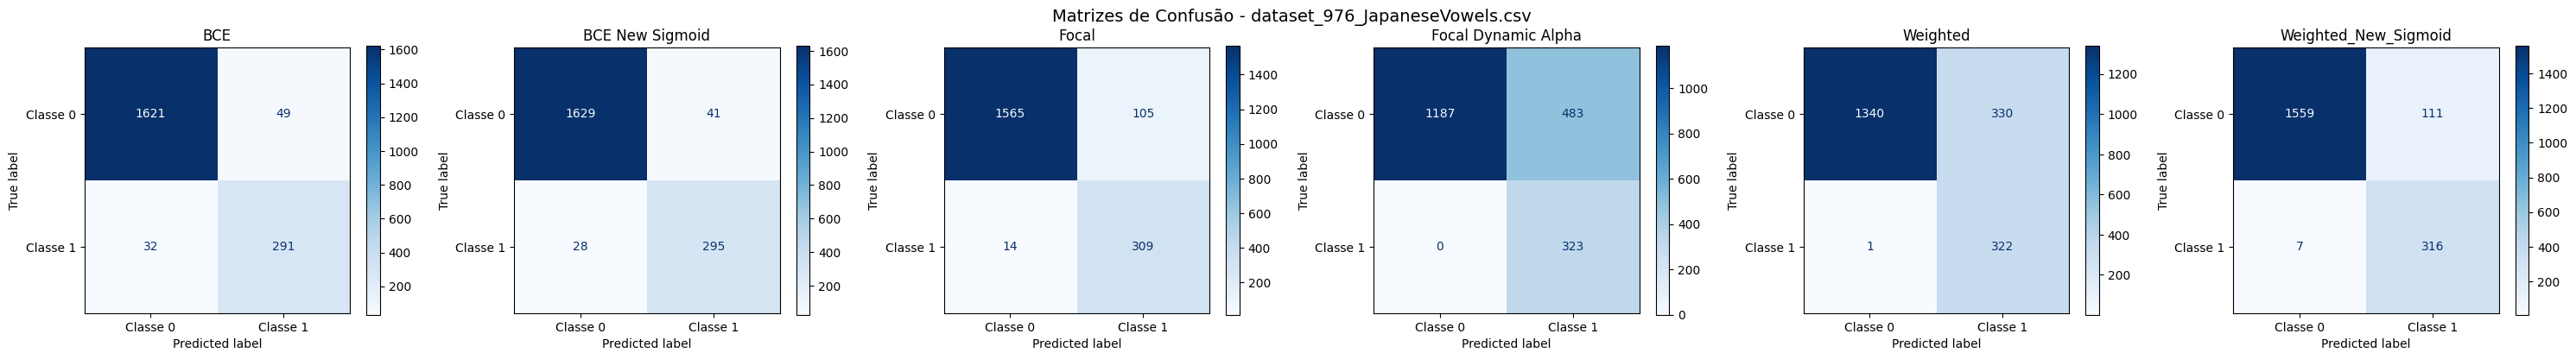


📁 Processando: dataset_978_mfeat-factors.csv
Convergência alcançada em 419 iterações.
Convergência alcançada em 988 iterações.


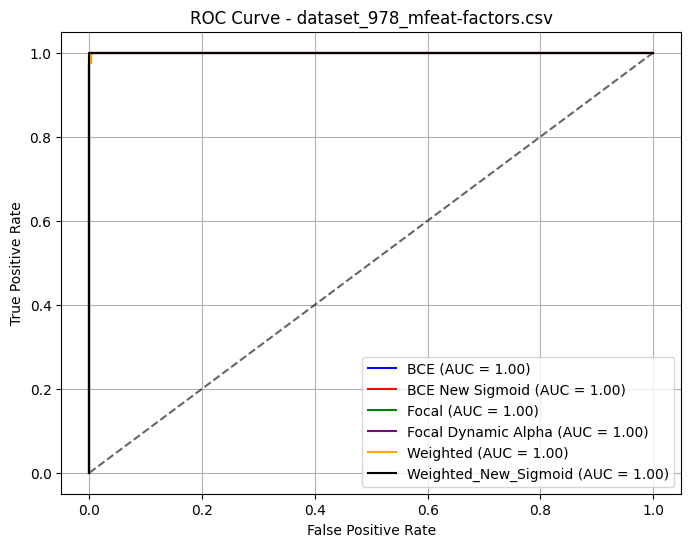

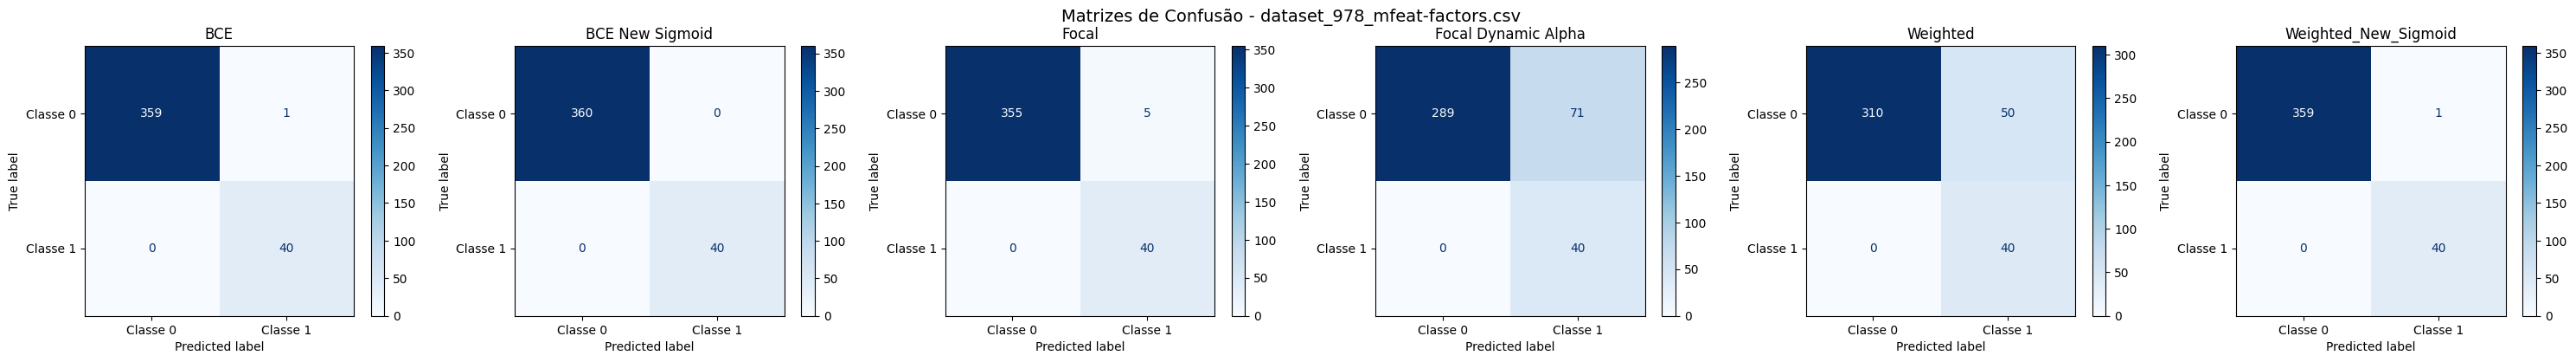


📁 Processando: dataset_980_optdigits.csv
Convergência alcançada em 860 iterações.
Convergência alcançada em 887 iterações.


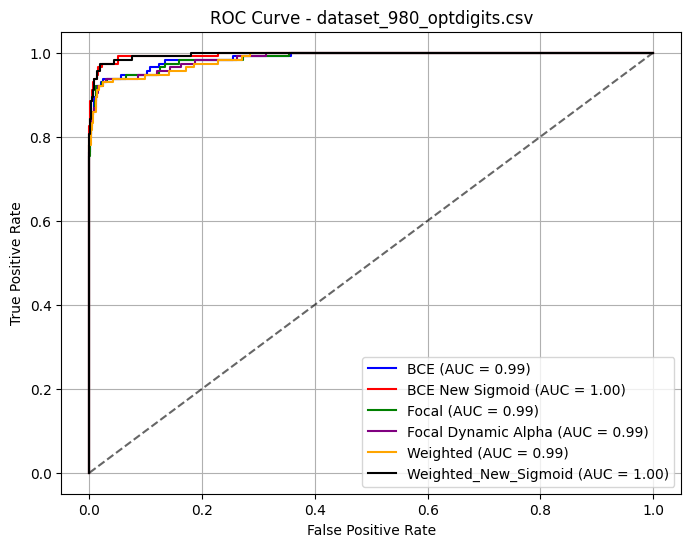

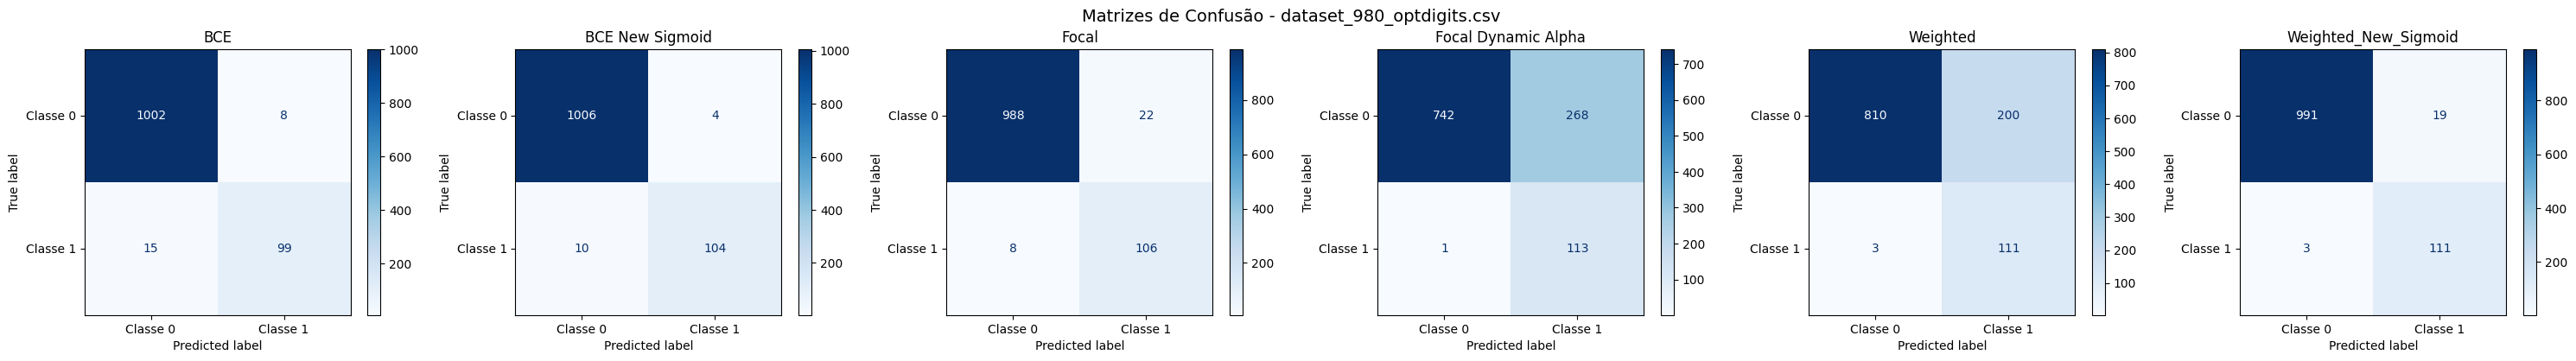


📁 Processando: dataset_984_analcatdata_draft.csv
Convergência alcançada em 790 iterações.
Convergência alcançada em 12 iterações.
Convergência alcançada em 577 iterações.
Convergência alcançada em 1 iterações.
Convergência alcançada em 313 iterações.
Convergência alcançada em 7 iterações.


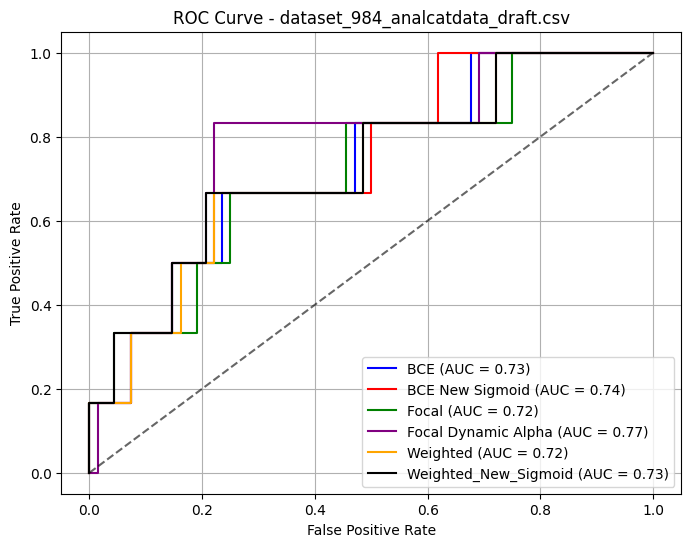

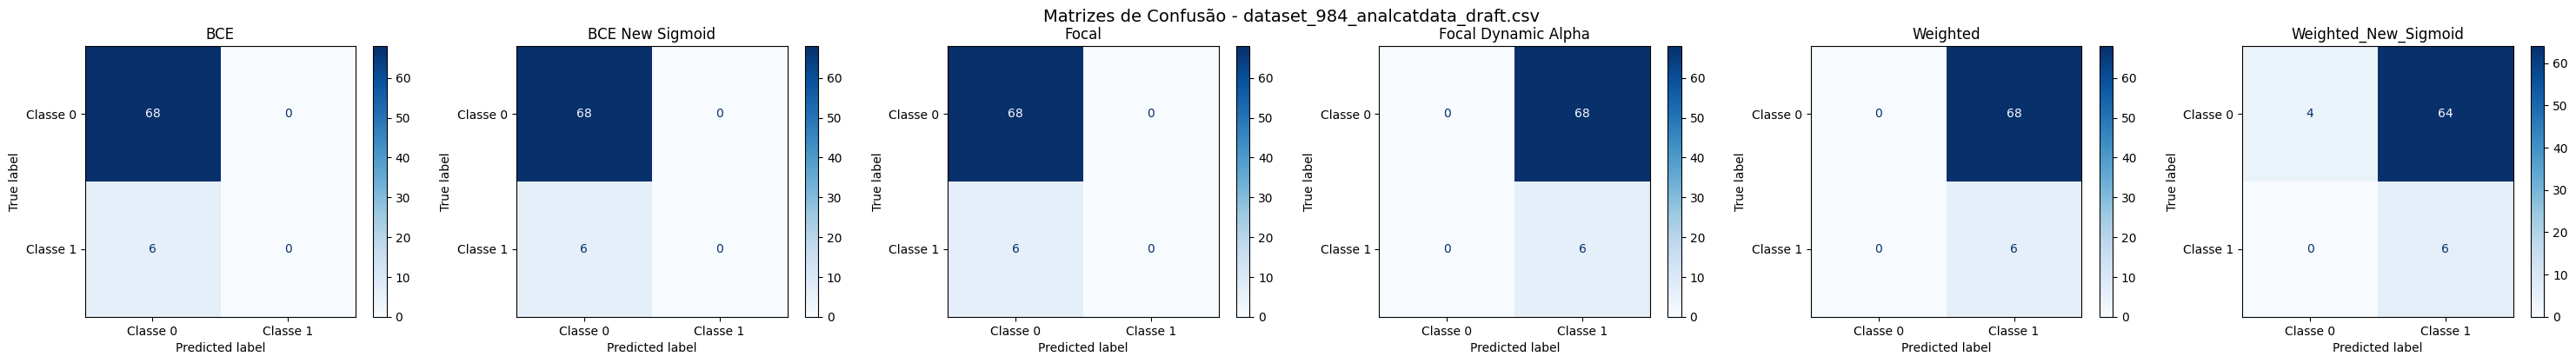


📁 Processando: dataset_987_collins.csv


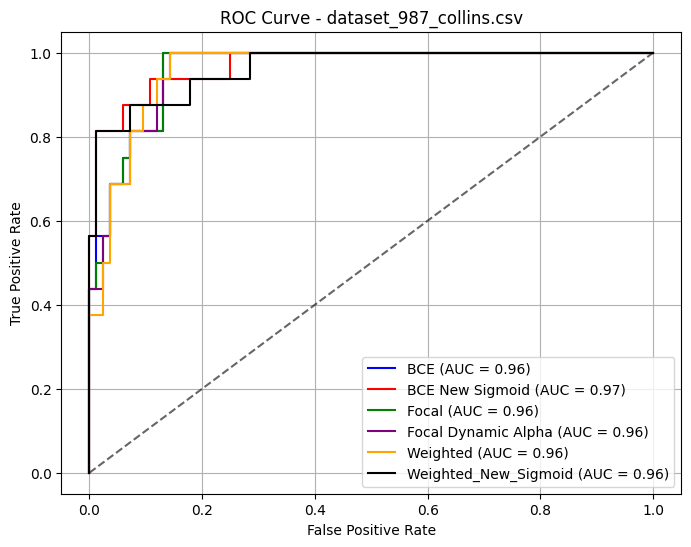

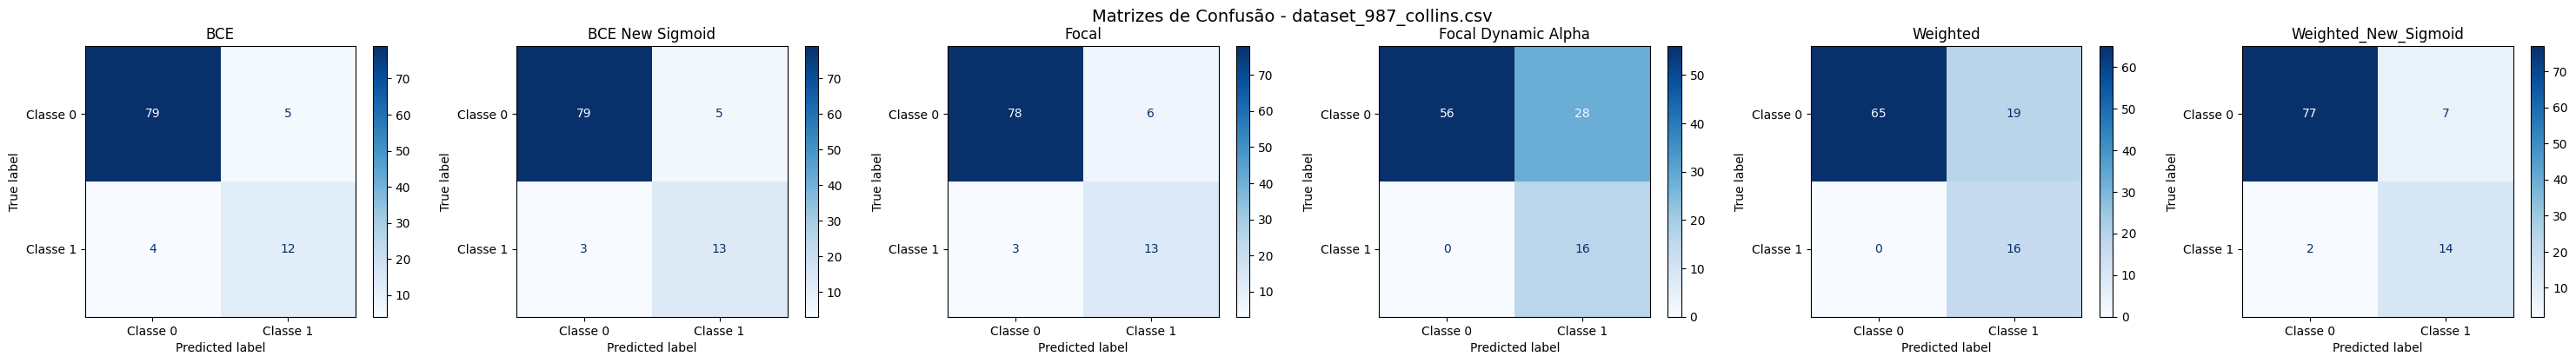


📁 Processando: dataset_995_mfeat-zernike.csv
Convergência alcançada em 915 iterações.


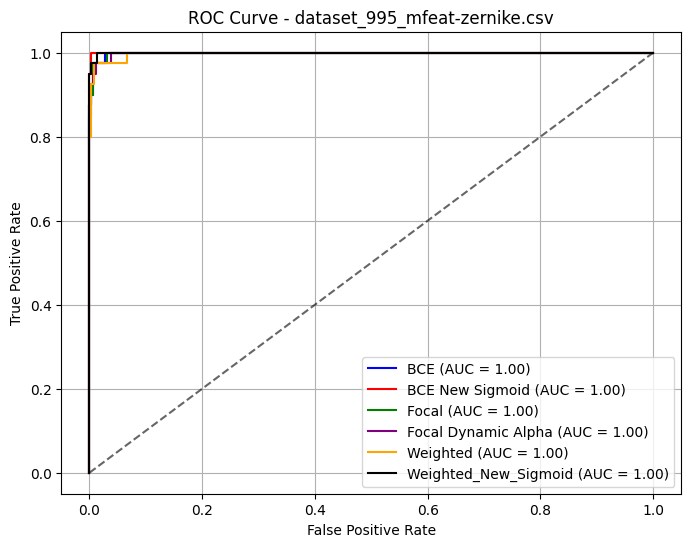

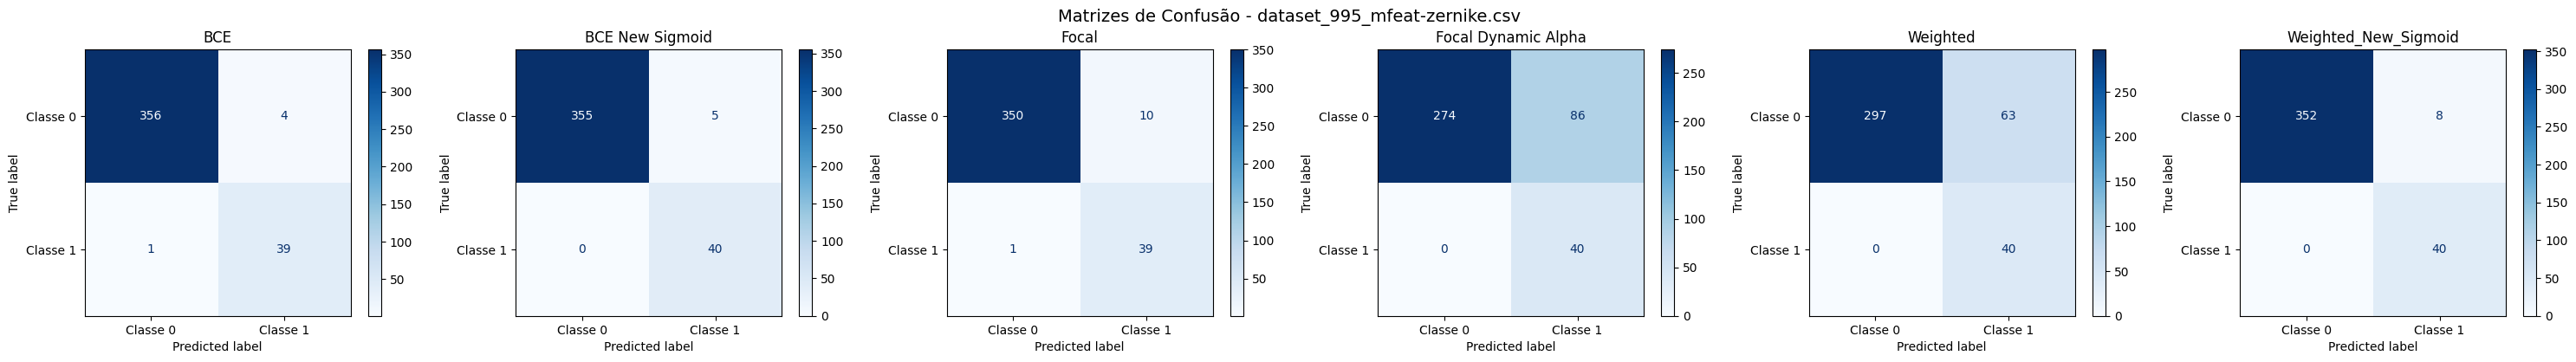

In [84]:
# Cores para a ROC
colors = ["blue", "red", "green", "purple", "orange","black"]
8

# Modelos
models = {
    "BCE": BCE_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "BCE New Sigmoid": BCE_Logistic_Sigmoid(lr=0.05, penalty='l2', max_iters=1000),
    "Focal": Focal_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Focal Dynamic Alpha": Focal_Loss_DynamicAlpha_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Weighted": Weighted_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Weighted_New_Sigmoid": WeightedNewSigmoid_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
}

# Para agregar por dataset, deixe aqui. Se for só por arquivo, mantenha dentro do loop.
metrics = { name: {"accuracy": [], "balanced_accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []}
            for name in models }



# Loop sobre arquivos
for file in csv_files:
    print(f"\n📁 Processando: {os.path.basename(file)}")
    try:
        df = pd.read_csv(file)
        df = preprocessamento_robusto(df)

        # Separar features e target
        X = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1]
        try:
            y = binarizar_target(y_raw).values
        except ValueError as e:
            print(f"⚠️ Dataset ignorado: {e}")
            continue

        # Verificação final
        if np.isnan(X).any() or np.isnan(y).any():
            print(f"⚠️ Ainda contém NaNs após tudo. Ignorando.")
            continue

        # Normalização
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        y_preds = {}
        plt.figure(figsize=(8, 6))

        for i, (name, model) in enumerate(models.items()):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)

            y_preds[name] = y_pred

            acc = accuracy_score(y_test, y_pred)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)

            metrics[name]["accuracy"].append(acc)
            metrics[name]["balanced_accuracy"].append(bal_acc)
            metrics[name]["precision"].append(prec)
            metrics[name]["recall"].append(rec)
            metrics[name]["f1"].append(f1)
            metrics[name]["auc"].append(roc_auc)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})", color=colors[i])

        plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {os.path.basename(file)}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Matriz de Confusão de cada modelo
        n_models = len(models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        axes = axes.flatten()

        for i, name in enumerate(models):
            ConfusionMatrixDisplay.from_predictions(
                y_test, y_preds[name],
                display_labels=["Classe 0", "Classe 1"],
                cmap="Blues",
                values_format='d',
                ax=axes[i]
            )
            axes[i].set_title(name)

        plt.suptitle(f"Matrizes de Confusão - {os.path.basename(file)}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erro ao processar {file}: {e}")

In [85]:
print(f"\n📊 MÉTRICAS PARA GLOBAL:")
for name in models:
    print(f"🔹 {name}")
    for metric in ["accuracy", "balanced_accuracy", "precision", "recall", "f1", "auc"]:
        vals = metrics[name][metric]
        m, s = np.mean(vals), np.std(vals)
        print(f"  {metric:<9}: {m:.4f} ± {s:.4f}")


📊 MÉTRICAS PARA GLOBAL:
🔹 BCE
  accuracy : 0.9293 ± 0.0557
  balanced_accuracy: 0.7086 ± 0.1831
  precision: 0.7340 ± 0.3071
  recall   : 0.6879 ± 0.3748
  f1       : 0.6881 ± 0.3404
  auc      : 0.8744 ± 0.1394
🔹 BCE New Sigmoid
  accuracy : 0.9256 ± 0.0701
  balanced_accuracy: 0.7443 ± 0.1961
  precision: 0.7020 ± 0.3482
  recall   : 0.7298 ± 0.3668
  f1       : 0.7028 ± 0.3564
  auc      : 0.8677 ± 0.1521
🔹 Focal
  accuracy : 0.9181 ± 0.0673
  balanced_accuracy: 0.7238 ± 0.1906
  precision: 0.6911 ± 0.3001
  recall   : 0.7492 ± 0.3503
  f1       : 0.7006 ± 0.3175
  auc      : 0.8743 ± 0.1398
🔹 Focal Dynamic Alpha
  accuracy : 0.6408 ± 0.2844
  balanced_accuracy: 0.7119 ± 0.1489
  precision: 0.4527 ± 0.3546
  recall   : 0.9689 ± 0.0743
  f1       : 0.5378 ± 0.3235
  auc      : 0.8755 ± 0.1374
🔹 Weighted
  accuracy : 0.7008 ± 0.2208
  balanced_accuracy: 0.7641 ± 0.1420
  precision: 0.4901 ± 0.3503
  recall   : 0.9212 ± 0.1254
  f1       : 0.5602 ± 0.2976
  auc      : 0.8717 ± 0.1403


In [86]:
# (Opcional) Função de intervalo de confiança
def paired_confidence_interval(a, b, confidence=0.95):
    diff = np.array(b) - np.array(a)
    m    = diff.mean()
    se   = diff.std(ddof=1) / np.sqrt(len(diff))
    h    = se * t.ppf((1 + confidence) / 2., len(diff)-1)
    return m, m-h, m+h

baseline_name = "BCE"
comparisons = [name for name in models if name != baseline_name]

print(f"Base de comparação: {baseline_name}\n")

for name in comparisons:
    # F1-score
    a = metrics[baseline_name]["f1"]
    b = metrics[name][             "f1"]
    stat, p = ttest_rel(a, b)
    md, low, high = paired_confidence_interval(a, b)
    print(f"→ {baseline_name} vs {name} — F1-score:")
    print(f"   t = {stat:.3f}, p = {p:.3f}; Δmean = {md:.3f}, 95% CI [{low:.3f}, {high:.3f}]")
    print("   " + ("significativo (p<0.05)\n" if p<0.05 else "não significativo (p≥0.05)\n"))
    
    # Balanced accuracy
    a = metrics[baseline_name]["balanced_accuracy"]
    b = metrics[name][             "balanced_accuracy"]
    stat, p = ttest_rel(a, b)
    md, low, high = paired_confidence_interval(a, b)
    print(f"→ {baseline_name} vs {name} — Balanced Accuracy:")
    print(f"   t = {stat:.3f}, p = {p:.3f}; Δmean = {md:.3f}, 95% CI [{low:.3f}, {high:.3f}]")
    print("   " + ("significativo (p<0.05)\n" if p<0.05 else "não significativo (p≥0.05)\n"))


Base de comparação: BCE

→ BCE vs BCE New Sigmoid — F1-score:
   t = -0.902, p = 0.372; Δmean = 0.015, 95% CI [-0.018, 0.047]
   não significativo (p≥0.05)

→ BCE vs BCE New Sigmoid — Balanced Accuracy:
   t = -3.182, p = 0.003; Δmean = 0.036, 95% CI [0.013, 0.058]
   significativo (p<0.05)

→ BCE vs Focal — F1-score:
   t = -1.018, p = 0.313; Δmean = 0.012, 95% CI [-0.012, 0.037]
   não significativo (p≥0.05)

→ BCE vs Focal — Balanced Accuracy:
   t = -1.788, p = 0.080; Δmean = 0.015, 95% CI [-0.002, 0.032]
   não significativo (p≥0.05)

→ BCE vs Focal Dynamic Alpha — F1-score:
   t = 4.703, p = 0.000; Δmean = -0.150, 95% CI [-0.215, -0.086]
   significativo (p<0.05)

→ BCE vs Focal Dynamic Alpha — Balanced Accuracy:
   t = -0.202, p = 0.840; Δmean = 0.003, 95% CI [-0.030, 0.036]
   não significativo (p≥0.05)

→ BCE vs Weighted — F1-score:
   t = 4.475, p = 0.000; Δmean = -0.128, 95% CI [-0.185, -0.070]
   significativo (p<0.05)

→ BCE vs Weighted — Balanced Accuracy:
   t = -2.990, 

# Anotações sobre os modelos:

## Focal Loss: 
    Ajusta função de custa da BCE para:
    1. Reduzir a influência de exemplos fáceis (que o modelo já acerta);
    2. Aumentar o foco em exemplos difíceis (geralmente da classe minoritária).
        Ela faz isso com dois hiperparâmetros:
        γ (gamma): foca mais em erros.
        α (alpha): pesa mais a classe minoritária, compensando o desequilíbrio.
## Focal com alpha dinamico: 
    Provavel melhora em recall e AUC pois força o modelo a se preocupar mais com a minori
    A classe minoritária recebe peso maior proporcionalmente.
    A classe majoritária recebe peso menor
    Ao usar α dinâmico, você tende a observar:
        Métrica             Efeito com α dinâmico
        Accuracy	        Pode cair ligeiramente
        Precision	        Pode diminuir
        Recall (minoria)	Aumenta
        F1 Score	        Melhora
        AUC	                Melhora
    Isso é desejável quando seu objetivo é detectar melhor a minoria, mesmo que isso custe um pouco de precisão.